In [31]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import SpectralEmbedding
import os, sys
from pathlib import Path



### Load the Iris Data set as sample data.
### The dataset is located here: https://archive.ics.uci.edu/ml/datasets/iris

### The data (matrix of size n x d or 150 x 4) is output to a text file - outTestMat.txt

### The file is to be loaded into Urerf and run to produce a similarity matrix (150x150)

In [20]:
iris = datasets.load_iris()
numFeatures = 4
X = iris.data[:, :numFeatures]
mat = []
for i in range(0, len(X)):
    mat.append(X[i])
mat = np.matrix(mat, dtype = float)

# #############################################################################
# Print to file to run in Urerf

with open('outTestMat.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%.2f')           
print("Feature matrix of shape", mat.shape, "outputted. Run Urerf in R now.")

Feature matrix of shape (150, 4) outputted. Run Urerf in R now.


### The test parameters detailed below are as follows: k value, depth, and embedding dimension.
### Note the default parameters:
        - num trees = 500
        - k = 10
        - depth = 4
        - dim = 2

In [21]:
k_varying = [10,15,20,30,60,90,120]
depth_varying = [4,6,8,10,12,15,20]
dim = [2,3,4,5,7,10,15,20,30]
dataMini_kvalue = []
dataKmeans_depth = []
dataGMM_kvalue = []
dataMini_depth = []
dataKmeans_kvalue = []
dataGMM_depth = []
dataMini_dim = []
dataKmeans_dim = []
dataGMM_dim = []

### Each of the clustering algorithms
#### - coded to select optimal parameters each time they are run. 

In [32]:
##### Clustering ######

def MiniBatchKMeansClustering(inputMat, clustInit = 1, clustInc = 1, batchSizeInit = 40, batchSizeInc = 10):
    maxClusters = 0
    maxSize = 0
    maxARI = 0
    clust = clustInit
    while clust < (len(inputMat)/4):
        #vary the cluster number
        batchSize = batchSizeInit
        clust = clust + clustInc
        while batchSize < len(inputMat):
            #vary the batch size
            batchSize = batchSize + batchSizeInc
            mb = MiniBatchKMeans(n_clusters = clust, batch_size = batchSize).fit(inputMat)
            cluster_centers_ = mb.cluster_centers_
            labels = mb.labels_
            
            ari = adjusted_rand_score(iris.target, labels)
            print('|BatchSize |% 1.2f' %  batchSize, "| Clusters | % 1.1f" % clust, "| ARI | % 1.3f" % ari, "|")

            #capture best clusters and batchsize
            if (ari > maxARI):
                maxClusters = clust
                maxSize = batchSize
                maxARI = ari
                ss = silhouette_score(inputMat, labels)
    print("Best Batch Size:", maxSize, "Best Num Clusters:", maxClusters)
    return maxClusters, maxSize, maxARI

def GMMClustering(inputMat, clustInit = 1, clustInc = 1):
    maxClusters = 0
    maxSize = 0
    maxARI = 0
    clust = clustInit
    while clust < (len(inputMat)/4):
        #vary the cluster number
        clust = clust + clustInc
        gm = GaussianMixture(n_components = clust)
        gm.fit(inputMat)
        labels = gm.predict(inputMat)
        ari = adjusted_rand_score(iris.target, labels)
        print("| Clusters | % 1.1f" % clust, "| ARI | % 1.3f" % ari, "|")

        #capture best clusters and batchsize
        if (ari > maxARI):
            maxClusters = clust
            maxARI = ari
            ss = silhouette_score(inputMat, labels)
    print("Best Num Clusters:", maxClusters)
    return maxClusters, maxARI

def KMeansClustering(inputMat, clustInit = 1, clustInc = 1):
    maxClusters = 0
    maxSize = 0
    maxARI = 0
    clust = clustInit
    while clust < (len(inputMat)/4):
        #vary the cluster number
        clust = clust + clustInc
        km = KMeans(n_clusters = clust).fit(inputMat)
        cluster_centers_ = km.cluster_centers_
        labels = km.labels_
            
        ari = adjusted_rand_score(iris.target, labels)
        print("| Clusters | % 1.1f" % clust, "| ARI | % 1.3f" % ari, "|")

        #capture best clusters and batchsize
        if (ari > maxARI):
            maxClusters = clust
            maxARI = ari
            ss = silhouette_score(inputMat, labels)
    print("Best Num Clusters:", maxClusters)
    return maxClusters, maxARI

def SpectralClust(inputMat, clustInit = 1, clustInc = 1):
    maxClusters = 0
    maxSize = 0
    maxARI = 0
    clust = clustInit
    while clust < (len(inputMat)/4):
        #vary the cluster number
        clust = clust + clustInc
        sc = SpectralClustering(n_clusters = clust).fit(inputMat)
        labels = sc.labels_
            
        ari = adjusted_rand_score(iris.target, labels)
        print("| Clusters | % 1.1f" % clust, "| ARI | % 1.3f" % ari, "|")

        #capture best clusters and batchsize
        if (ari > maxARI):
            maxClusters = clust
            maxARI = ari
            ss = silhouette_score(inputMat, labels)
    print("Best Num Clusters:", maxClusters)
    return maxClusters, maxARI


### Plotting functions for labeled data in 2D and 3D

In [23]:
###### Plotting ######
def graph2DLabels(mat, labels):
    fig = plt.figure(3, figsize=(10, 10))
    ax = plt.Axes(fig, rect=[0, 0, .5, .5])
    z = list(labels)
    N = len(mat[:,1])
    x = [mat[:,0]]
    y = [mat[:,1]]
    cmap = matplotlib.cm.get_cmap('plasma')
    normalize = matplotlib.colors.Normalize(vmin=min(z), vmax=max(z))
    colors = [cmap(normalize(value)) for value in z]
    plt.scatter(x, y, color = colors)
    plt.title("Iris Dataset")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
def graph3DLabels(mat, labels):
    fig = plt.figure(4, figsize=(10, 10))
    ax = Axes3D(fig, rect=[0, 0, .5, .5], elev=40, azim=150)
    ax.scatter(mat[:, 0], mat[:, 1], mat[:, 2], c=labels, cmap = "plasma")
    ax.set_title("Iris Dataset")
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')

### Plot the iris data using the first two dimension and first 3 dimensions.

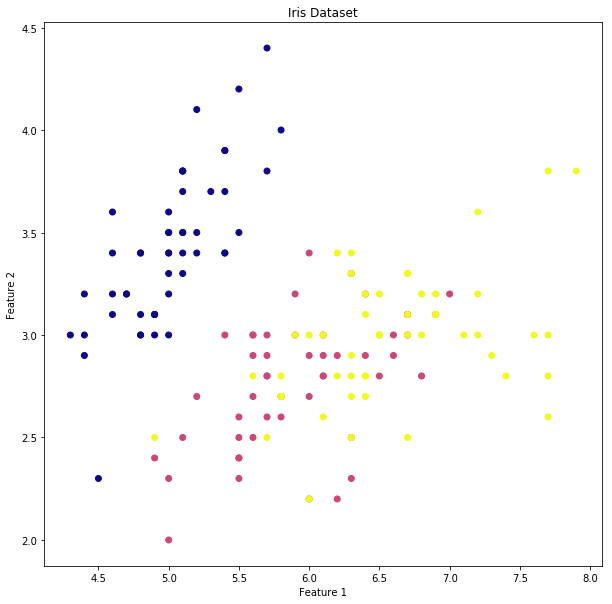

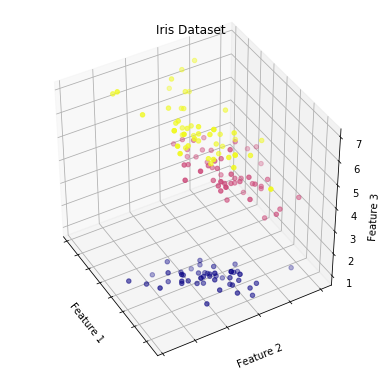

In [24]:
plt.figure(1)
graph2DLabels(mat, iris.target)
plt.figure(2)
graph3DLabels(mat, iris.target)

### This code loads the similarity matrix produced from Urerf, embeds it into a set number of dimensions, and clusters it using all three clustering algorithms.
    - The output is printed below
    - The best ARI score and number of clusters for each algorithm is saved in an array
    - the number of trials for each algorithm is set to 25

In [25]:
matrix = open('inTestMat.txt').read()
matrix = [item.split() for item in matrix.split('\n')[:-1]]
inputMat = np.matrix(matrix, dtype = float)
print(inputMat.shape)
trial_num = 25
t = float(trial_num)
for i in range(len(dim)):
    n = dim[i]
    print(n)
    embedding = SpectralEmbedding(n_components=n, affinity = 'precomputed')
    inputMat_transformed = embedding.fit_transform(inputMat)

    maxClusters = 0
    maxSize = 0
    maxAri = 0
    print("MINI BATCH K MEANS")
    for j in range(0, trial_num):
        x, y, z = MiniBatchKMeansClustering(inputMat_transformed, 1, 1, 0, 50)
        maxClusters += x
        maxSize += y
        maxAri += z
    dataMini_dim.append([n, maxClusters/t,  maxAri/t])
    maxClusters = 0
    maxAri = 0
    print("K MEANS")
    for j in range(0, trial_num):
        x, y = KMeansClustering(inputMat_transformed, 1, 1)
        maxClusters+= x
        maxAri += y 
    dataKmeans_dim.append([n, maxClusters/t,  maxAri/t])
    maxClusters = 0
    maxAri = 0
    print("GMM")
    for j in range(0, trial_num):
        x, y = GMMClustering(inputMat_transformed, 1, 1)
        maxClusters += x
        maxAri += y
    dataGMM_dim.append([n, maxClusters/t,  maxAri/t])

(150, 150)
2
MINI BATCH K MEANS
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.771 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.659 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.667 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.656 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.589 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.577 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.583 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 150.00 | Clusters |  7.0 |

|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.349 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.254 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.252 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.230 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.255 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.215 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.205 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.223 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.210 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.201 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.201 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.207 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.216 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.199 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.219 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.180 

|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.124 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.102 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.110 

|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.453 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.786 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.771 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.786 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.667 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.667 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.667 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.656 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.656 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.587 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.587 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.427 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.546 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.534 |
|BatchSize | 100

|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.219 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.201 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.218 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.194 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.204 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.208 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.221 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.188 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.187 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.183 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.189 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.184 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.160 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.182 

|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.098 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.104 

|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.625 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.547 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.547 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.523 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.374 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.396 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.393 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.508 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.515 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.394 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.352 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.491 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.358 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.346 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.344 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.351 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.328 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.292 |
|BatchSi

|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.193 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.182 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.187 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.185 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.185 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.163 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.163 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.150 

|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.107 

|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.571 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.611 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.393 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.376 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.393 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.367 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.355 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.387 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.353 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.349 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.367 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.332 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.326 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.344 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.334 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.288 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.323 |
|BatchS

|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.160 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.182 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.164 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.174 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.167 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.150 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.160 

|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.111 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.108 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.100 

|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.373 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.355 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.518 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.348 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.399 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.329 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.346 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.310 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.397 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.342 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.287 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.323 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.311 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.318 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.275 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.298 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.243 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.258 |
|

|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.156 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.133 

|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.108 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.112 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.092 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.095 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.097 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50

|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.387 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.355 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.351 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.349 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.358 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.349 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.344 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.327 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.268 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.321 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.260 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.279 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.294 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.253 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.253 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.237 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.268 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.218 |


|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.171 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.176 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.158 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.149 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.147 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.132 

|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.100 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.102 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.786 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.786 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.672 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 150.00 |

|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.258 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.318 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.256 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.312 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.286 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.210 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.247 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.222 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.206 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.203 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.237 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.230 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.206 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.171 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.200 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.228 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.193 

| Clusters |  36.0 | ARI |  0.105 |
| Clusters |  37.0 | ARI |  0.100 |
| Clusters |  38.0 | ARI |  0.087 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.786 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.581 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.550 |
| Clusters |  9.0 | ARI |  0.355 |
| Clusters |  10.0 | ARI |  0.348 |
| Clusters |  11.0 | ARI |  0.323 |
| Clusters |  12.0 | ARI |  0.317 |
| Clusters |  13.0 | ARI |  0.312 |
| Clusters |  14.0 | ARI |  0.252 |
| Clusters |  15.0 | ARI |  0.247 |
| Clusters |  16.0 | ARI |  0.227 |
| Clusters |  17.0 | ARI |  0.223 |
| Clusters |  18.0 | ARI |  0.192 |
| Clusters |  19.0 | ARI |  0.182 |
| Clusters |  20.0 | ARI |  0.170 |
| Clusters |  21.0 | ARI |  0.180 |
| Clusters |  22.0 | ARI |  0.185 |
| Clusters |  23.0 | ARI |  0.151 |
| Clusters |  24.0 | ARI |  0.157 |
| Clusters |  25.0 | ARI |  0.151 |
| Clusters |  2

| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.550 |
| Clusters |  9.0 | ARI |  0.354 |
| Clusters |  10.0 | ARI |  0.349 |
| Clusters |  11.0 | ARI |  0.322 |
| Clusters |  12.0 | ARI |  0.324 |
| Clusters |  13.0 | ARI |  0.317 |
| Clusters |  14.0 | ARI |  0.247 |
| Clusters |  15.0 | ARI |  0.215 |
| Clusters |  16.0 | ARI |  0.228 |
| Clusters |  17.0 | ARI |  0.203 |
| Clusters |  18.0 | ARI |  0.185 |
| Clusters |  19.0 | ARI |  0.169 |
| Clusters |  20.0 | ARI |  0.179 |
| Clusters |  21.0 | ARI |  0.183 |
| Clusters |  22.0 | ARI |  0.156 |
| Clusters |  23.0 | ARI |  0.151 |
| Clusters |  24.0 | ARI |  0.138 |
| Clusters |  25.0 | ARI |  0.150 |
| Clusters |  26.0 | ARI |  0.142 |
| Clusters |  27.0 | ARI |  0.132 |
| Clusters |  28.0 | ARI |  0.122 |
| Clusters |  29.0 | ARI |  0.131 |
| Clusters |  30.0 | ARI |  0.134 |
| Clusters |  31.0 | ARI |  0.122 |
| Clusters |  32.0 | ARI |  0.118 |
| Clusters |  33.0 | ARI |  0.11

| Clusters |  14.0 | ARI |  0.255 |
| Clusters |  15.0 | ARI |  0.241 |
| Clusters |  16.0 | ARI |  0.229 |
| Clusters |  17.0 | ARI |  0.190 |
| Clusters |  18.0 | ARI |  0.189 |
| Clusters |  19.0 | ARI |  0.194 |
| Clusters |  20.0 | ARI |  0.187 |
| Clusters |  21.0 | ARI |  0.179 |
| Clusters |  22.0 | ARI |  0.157 |
| Clusters |  23.0 | ARI |  0.154 |
| Clusters |  24.0 | ARI |  0.158 |
| Clusters |  25.0 | ARI |  0.138 |
| Clusters |  26.0 | ARI |  0.143 |
| Clusters |  27.0 | ARI |  0.142 |
| Clusters |  28.0 | ARI |  0.123 |
| Clusters |  29.0 | ARI |  0.142 |
| Clusters |  30.0 | ARI |  0.130 |
| Clusters |  31.0 | ARI |  0.120 |
| Clusters |  32.0 | ARI |  0.105 |
| Clusters |  33.0 | ARI |  0.118 |
| Clusters |  34.0 | ARI |  0.102 |
| Clusters |  35.0 | ARI |  0.115 |
| Clusters |  36.0 | ARI |  0.102 |
| Clusters |  37.0 | ARI |  0.101 |
| Clusters |  38.0 | ARI |  0.096 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.756 |
| Cluster

| Clusters |  19.0 | ARI |  0.197 |
| Clusters |  20.0 | ARI |  0.182 |
| Clusters |  21.0 | ARI |  0.157 |
| Clusters |  22.0 | ARI |  0.176 |
| Clusters |  23.0 | ARI |  0.150 |
| Clusters |  24.0 | ARI |  0.141 |
| Clusters |  25.0 | ARI |  0.154 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.145 |
| Clusters |  28.0 | ARI |  0.147 |
| Clusters |  29.0 | ARI |  0.124 |
| Clusters |  30.0 | ARI |  0.122 |
| Clusters |  31.0 | ARI |  0.116 |
| Clusters |  32.0 | ARI |  0.124 |
| Clusters |  33.0 | ARI |  0.111 |
| Clusters |  34.0 | ARI |  0.119 |
| Clusters |  35.0 | ARI |  0.111 |
| Clusters |  36.0 | ARI |  0.111 |
| Clusters |  37.0 | ARI |  0.111 |
| Clusters |  38.0 | ARI |  0.100 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.756 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.581 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.528 |
| Clusters |  

| Clusters |  24.0 | ARI |  0.178 |
| Clusters |  25.0 | ARI |  0.140 |
| Clusters |  26.0 | ARI |  0.132 |
| Clusters |  27.0 | ARI |  0.146 |
| Clusters |  28.0 | ARI |  0.136 |
| Clusters |  29.0 | ARI |  0.120 |
| Clusters |  30.0 | ARI |  0.125 |
| Clusters |  31.0 | ARI |  0.108 |
| Clusters |  32.0 | ARI |  0.125 |
| Clusters |  33.0 | ARI |  0.109 |
| Clusters |  34.0 | ARI |  0.104 |
| Clusters |  35.0 | ARI |  0.119 |
| Clusters |  36.0 | ARI |  0.114 |
| Clusters |  37.0 | ARI |  0.105 |
| Clusters |  38.0 | ARI |  0.091 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.771 |
| Clusters |  4.0 | ARI |  0.580 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.576 |
| Clusters |  7.0 | ARI |  0.629 |
| Clusters |  8.0 | ARI |  0.536 |
| Clusters |  9.0 | ARI |  0.539 |
| Clusters |  10.0 | ARI |  0.362 |
| Clusters |  11.0 | ARI |  0.479 |
| Clusters |  12.0 | ARI |  0.506 |
| Clusters |  13.0 | ARI |  0.419 |
| Clusters |  1

| Clusters |  28.0 | ARI |  0.133 |
| Clusters |  29.0 | ARI |  0.124 |
| Clusters |  30.0 | ARI |  0.126 |
| Clusters |  31.0 | ARI |  0.126 |
| Clusters |  32.0 | ARI |  0.120 |
| Clusters |  33.0 | ARI |  0.107 |
| Clusters |  34.0 | ARI |  0.118 |
| Clusters |  35.0 | ARI |  0.103 |
| Clusters |  36.0 | ARI |  0.093 |
| Clusters |  37.0 | ARI |  0.109 |
| Clusters |  38.0 | ARI |  0.089 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.771 |
| Clusters |  4.0 | ARI |  0.580 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.469 |
| Clusters |  7.0 | ARI |  0.541 |
| Clusters |  8.0 | ARI |  0.536 |
| Clusters |  9.0 | ARI |  0.376 |
| Clusters |  10.0 | ARI |  0.326 |
| Clusters |  11.0 | ARI |  0.368 |
| Clusters |  12.0 | ARI |  0.411 |
| Clusters |  13.0 | ARI |  0.346 |
| Clusters |  14.0 | ARI |  0.311 |
| Clusters |  15.0 | ARI |  0.254 |
| Clusters |  16.0 | ARI |  0.217 |
| Clusters |  17.0 | ARI |  0.220 |
| Clusters |  1

| Clusters |  33.0 | ARI |  0.116 |
| Clusters |  34.0 | ARI |  0.116 |
| Clusters |  35.0 | ARI |  0.108 |
| Clusters |  36.0 | ARI |  0.097 |
| Clusters |  37.0 | ARI |  0.105 |
| Clusters |  38.0 | ARI |  0.092 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.612 |
| Clusters |  4.0 | ARI |  0.580 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.470 |
| Clusters |  7.0 | ARI |  0.541 |
| Clusters |  8.0 | ARI |  0.545 |
| Clusters |  9.0 | ARI |  0.534 |
| Clusters |  10.0 | ARI |  0.349 |
| Clusters |  11.0 | ARI |  0.347 |
| Clusters |  12.0 | ARI |  0.296 |
| Clusters |  13.0 | ARI |  0.321 |
| Clusters |  14.0 | ARI |  0.256 |
| Clusters |  15.0 | ARI |  0.276 |
| Clusters |  16.0 | ARI |  0.218 |
| Clusters |  17.0 | ARI |  0.235 |
| Clusters |  18.0 | ARI |  0.209 |
| Clusters |  19.0 | ARI |  0.217 |
| Clusters |  20.0 | ARI |  0.242 |
| Clusters |  21.0 | ARI |  0.169 |
| Clusters |  22.0 | ARI |  0.187 |
| Clusters |  2

| Clusters |  5.0 | ARI |  0.584 |
| Clusters |  6.0 | ARI |  0.572 |
| Clusters |  7.0 | ARI |  0.577 |
| Clusters |  8.0 | ARI |  0.408 |
| Clusters |  9.0 | ARI |  0.376 |
| Clusters |  10.0 | ARI |  0.343 |
| Clusters |  11.0 | ARI |  0.363 |
| Clusters |  12.0 | ARI |  0.361 |
| Clusters |  13.0 | ARI |  0.290 |
| Clusters |  14.0 | ARI |  0.367 |
| Clusters |  15.0 | ARI |  0.229 |
| Clusters |  16.0 | ARI |  0.231 |
| Clusters |  17.0 | ARI |  0.226 |
| Clusters |  18.0 | ARI |  0.188 |
| Clusters |  19.0 | ARI |  0.223 |
| Clusters |  20.0 | ARI |  0.184 |
| Clusters |  21.0 | ARI |  0.180 |
| Clusters |  22.0 | ARI |  0.176 |
| Clusters |  23.0 | ARI |  0.186 |
| Clusters |  24.0 | ARI |  0.192 |
| Clusters |  25.0 | ARI |  0.155 |
| Clusters |  26.0 | ARI |  0.154 |
| Clusters |  27.0 | ARI |  0.132 |
| Clusters |  28.0 | ARI |  0.136 |
| Clusters |  29.0 | ARI |  0.135 |
| Clusters |  30.0 | ARI |  0.139 |
| Clusters |  31.0 | ARI |  0.107 |
| Clusters |  32.0 | ARI |  0.121

|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.171 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.156 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.145 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.157 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.124 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.137 

|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.102 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.098 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.095 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.090 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.103 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize |

|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.406 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.413 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.323 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.377 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.329 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.325 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.381 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.304 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.298 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.291 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.284 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.249 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.265 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.276 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.269 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.251 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.270 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.239 |
|Ba

|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.168 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.149 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.157 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.163 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.135 

|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.108 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.089 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.102 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.089 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.215 |
|BatchSize | 15

|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.302 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.355 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.264 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.359 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.300 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.263 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.269 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.261 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.272 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.236 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.256 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.234 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.233 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.228 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.194 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.194 

|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.124 

|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.102 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.096 |
Best Batch Size: 150 Best Num Clusters: 4
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.394 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.441 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.786 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.648 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.585 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.558 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.529 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.529 |
|BatchSize | 150.00 | C

|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.261 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.247 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.250 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.272 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.243 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.241 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.219 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.237 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.234 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.202 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.192 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.197 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.202 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.201 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.178 

|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.114 

|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.091 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.090 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.093 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.093 |
Best Batch Size: 50 Best Num Clusters: 4
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.786 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.441 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.441 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.572 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.630 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.571 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.517 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.517 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.529 |
|BatchSize | 50.00 | Clu

|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.251 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.275 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.267 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.239 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.245 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.246 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.229 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.232 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.230 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.216 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.200 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.192 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.203 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.189 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.142 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.112 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.105 

|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.094 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.085 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.093 |
Best Batch Size: 50 Best Num Clusters: 4
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.457 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.173 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.441 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.441 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.441 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.615 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.615 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.615 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.529 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.517 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.529 |
|BatchSize | 50.00 | Clu

|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.283 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.284 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.248 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.232 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.210 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.245 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.239 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.188 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.223 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.229 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.210 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.221 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.194 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.207 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.205 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.192 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.198 

|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.124 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.109 

|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.086 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.093 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.094 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.200 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.160 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.336 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.441 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.441 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.400 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.615 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.615 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.615 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.614 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.529 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.517 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.468 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.490 |
|BatchSize | 150.00 | Clus

|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.238 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.234 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.246 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.232 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.237 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.198 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.194 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.196 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.201 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.201 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.245 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.187 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.172 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.198 

|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.112 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.103 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.111 

| Clusters |  22.0 | ARI |  0.151 |
| Clusters |  23.0 | ARI |  0.143 |
| Clusters |  24.0 | ARI |  0.143 |
| Clusters |  25.0 | ARI |  0.143 |
| Clusters |  26.0 | ARI |  0.135 |
| Clusters |  27.0 | ARI |  0.129 |
| Clusters |  28.0 | ARI |  0.122 |
| Clusters |  29.0 | ARI |  0.116 |
| Clusters |  30.0 | ARI |  0.110 |
| Clusters |  31.0 | ARI |  0.112 |
| Clusters |  32.0 | ARI |  0.111 |
| Clusters |  33.0 | ARI |  0.105 |
| Clusters |  34.0 | ARI |  0.106 |
| Clusters |  35.0 | ARI |  0.102 |
| Clusters |  36.0 | ARI |  0.094 |
| Clusters |  37.0 | ARI |  0.093 |
| Clusters |  38.0 | ARI |  0.097 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.441 |
| Clusters |  4.0 | ARI |  0.646 |
| Clusters |  5.0 | ARI |  0.529 |
| Clusters |  6.0 | ARI |  0.493 |
| Clusters |  7.0 | ARI |  0.452 |
| Clusters |  8.0 | ARI |  0.406 |
| Clusters |  9.0 | ARI |  0.327 |
| Clusters |  10.0 | ARI |  0.302 |
| Clusters |  11.0 | ARI |  0.300 |
| Clusters |  1

| Clusters |  26.0 | ARI |  0.135 |
| Clusters |  27.0 | ARI |  0.128 |
| Clusters |  28.0 | ARI |  0.118 |
| Clusters |  29.0 | ARI |  0.117 |
| Clusters |  30.0 | ARI |  0.111 |
| Clusters |  31.0 | ARI |  0.107 |
| Clusters |  32.0 | ARI |  0.104 |
| Clusters |  33.0 | ARI |  0.111 |
| Clusters |  34.0 | ARI |  0.106 |
| Clusters |  35.0 | ARI |  0.103 |
| Clusters |  36.0 | ARI |  0.097 |
| Clusters |  37.0 | ARI |  0.096 |
| Clusters |  38.0 | ARI |  0.086 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.441 |
| Clusters |  4.0 | ARI |  0.646 |
| Clusters |  5.0 | ARI |  0.529 |
| Clusters |  6.0 | ARI |  0.493 |
| Clusters |  7.0 | ARI |  0.452 |
| Clusters |  8.0 | ARI |  0.406 |
| Clusters |  9.0 | ARI |  0.326 |
| Clusters |  10.0 | ARI |  0.304 |
| Clusters |  11.0 | ARI |  0.300 |
| Clusters |  12.0 | ARI |  0.250 |
| Clusters |  13.0 | ARI |  0.254 |
| Clusters |  14.0 | ARI |  0.234 |
| Clusters |  15.0 | ARI |  0.219 |
| Clusters |  1

| Clusters |  30.0 | ARI |  0.114 |
| Clusters |  31.0 | ARI |  0.111 |
| Clusters |  32.0 | ARI |  0.111 |
| Clusters |  33.0 | ARI |  0.105 |
| Clusters |  34.0 | ARI |  0.101 |
| Clusters |  35.0 | ARI |  0.104 |
| Clusters |  36.0 | ARI |  0.103 |
| Clusters |  37.0 | ARI |  0.097 |
| Clusters |  38.0 | ARI |  0.086 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.441 |
| Clusters |  4.0 | ARI |  0.646 |
| Clusters |  5.0 | ARI |  0.529 |
| Clusters |  6.0 | ARI |  0.493 |
| Clusters |  7.0 | ARI |  0.452 |
| Clusters |  8.0 | ARI |  0.406 |
| Clusters |  9.0 | ARI |  0.327 |
| Clusters |  10.0 | ARI |  0.304 |
| Clusters |  11.0 | ARI |  0.302 |
| Clusters |  12.0 | ARI |  0.261 |
| Clusters |  13.0 | ARI |  0.249 |
| Clusters |  14.0 | ARI |  0.234 |
| Clusters |  15.0 | ARI |  0.221 |
| Clusters |  16.0 | ARI |  0.203 |
| Clusters |  17.0 | ARI |  0.203 |
| Clusters |  18.0 | ARI |  0.193 |
| Clusters |  19.0 | ARI |  0.173 |
| Clusters |  2

| Clusters |  36.0 | ARI |  0.095 |
| Clusters |  37.0 | ARI |  0.092 |
| Clusters |  38.0 | ARI |  0.091 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.441 |
| Clusters |  4.0 | ARI |  0.615 |
| Clusters |  5.0 | ARI |  0.529 |
| Clusters |  6.0 | ARI |  0.493 |
| Clusters |  7.0 | ARI |  0.452 |
| Clusters |  8.0 | ARI |  0.406 |
| Clusters |  9.0 | ARI |  0.327 |
| Clusters |  10.0 | ARI |  0.304 |
| Clusters |  11.0 | ARI |  0.302 |
| Clusters |  12.0 | ARI |  0.287 |
| Clusters |  13.0 | ARI |  0.249 |
| Clusters |  14.0 | ARI |  0.237 |
| Clusters |  15.0 | ARI |  0.229 |
| Clusters |  16.0 | ARI |  0.193 |
| Clusters |  17.0 | ARI |  0.193 |
| Clusters |  18.0 | ARI |  0.180 |
| Clusters |  19.0 | ARI |  0.161 |
| Clusters |  20.0 | ARI |  0.166 |
| Clusters |  21.0 | ARI |  0.157 |
| Clusters |  22.0 | ARI |  0.165 |
| Clusters |  23.0 | ARI |  0.150 |
| Clusters |  24.0 | ARI |  0.149 |
| Clusters |  25.0 | ARI |  0.131 |
| Clusters |  2

| Clusters |  2.0 | ARI |  0.531 |
| Clusters |  3.0 | ARI |  0.443 |
| Clusters |  4.0 | ARI |  0.545 |
| Clusters |  5.0 | ARI |  0.500 |
| Clusters |  6.0 | ARI |  0.509 |
| Clusters |  7.0 | ARI |  0.414 |
| Clusters |  8.0 | ARI |  0.362 |
| Clusters |  9.0 | ARI |  0.395 |
| Clusters |  10.0 | ARI |  0.321 |
| Clusters |  11.0 | ARI |  0.287 |
| Clusters |  12.0 | ARI |  0.260 |
| Clusters |  13.0 | ARI |  0.273 |
| Clusters |  14.0 | ARI |  0.251 |
| Clusters |  15.0 | ARI |  0.230 |
| Clusters |  16.0 | ARI |  0.244 |
| Clusters |  17.0 | ARI |  0.213 |
| Clusters |  18.0 | ARI |  0.234 |
| Clusters |  19.0 | ARI |  0.165 |
| Clusters |  20.0 | ARI |  0.170 |
| Clusters |  21.0 | ARI |  0.148 |
| Clusters |  22.0 | ARI |  0.149 |
| Clusters |  23.0 | ARI |  0.170 |
| Clusters |  24.0 | ARI |  0.165 |
| Clusters |  25.0 | ARI |  0.145 |
| Clusters |  26.0 | ARI |  0.141 |
| Clusters |  27.0 | ARI |  0.155 |
| Clusters |  28.0 | ARI |  0.136 |
| Clusters |  29.0 | ARI |  0.113 |


| Clusters |  8.0 | ARI |  0.405 |
| Clusters |  9.0 | ARI |  0.401 |
| Clusters |  10.0 | ARI |  0.329 |
| Clusters |  11.0 | ARI |  0.345 |
| Clusters |  12.0 | ARI |  0.266 |
| Clusters |  13.0 | ARI |  0.276 |
| Clusters |  14.0 | ARI |  0.224 |
| Clusters |  15.0 | ARI |  0.266 |
| Clusters |  16.0 | ARI |  0.203 |
| Clusters |  17.0 | ARI |  0.202 |
| Clusters |  18.0 | ARI |  0.199 |
| Clusters |  19.0 | ARI |  0.175 |
| Clusters |  20.0 | ARI |  0.195 |
| Clusters |  21.0 | ARI |  0.192 |
| Clusters |  22.0 | ARI |  0.182 |
| Clusters |  23.0 | ARI |  0.156 |
| Clusters |  24.0 | ARI |  0.137 |
| Clusters |  25.0 | ARI |  0.157 |
| Clusters |  26.0 | ARI |  0.157 |
| Clusters |  27.0 | ARI |  0.169 |
| Clusters |  28.0 | ARI |  0.130 |
| Clusters |  29.0 | ARI |  0.139 |
| Clusters |  30.0 | ARI |  0.118 |
| Clusters |  31.0 | ARI |  0.112 |
| Clusters |  32.0 | ARI |  0.103 |
| Clusters |  33.0 | ARI |  0.103 |
| Clusters |  34.0 | ARI |  0.100 |
| Clusters |  35.0 | ARI |  0.

| Clusters |  14.0 | ARI |  0.273 |
| Clusters |  15.0 | ARI |  0.254 |
| Clusters |  16.0 | ARI |  0.262 |
| Clusters |  17.0 | ARI |  0.191 |
| Clusters |  18.0 | ARI |  0.201 |
| Clusters |  19.0 | ARI |  0.192 |
| Clusters |  20.0 | ARI |  0.196 |
| Clusters |  21.0 | ARI |  0.181 |
| Clusters |  22.0 | ARI |  0.163 |
| Clusters |  23.0 | ARI |  0.194 |
| Clusters |  24.0 | ARI |  0.153 |
| Clusters |  25.0 | ARI |  0.139 |
| Clusters |  26.0 | ARI |  0.158 |
| Clusters |  27.0 | ARI |  0.120 |
| Clusters |  28.0 | ARI |  0.123 |
| Clusters |  29.0 | ARI |  0.133 |
| Clusters |  30.0 | ARI |  0.131 |
| Clusters |  31.0 | ARI |  0.116 |
| Clusters |  32.0 | ARI |  0.113 |
| Clusters |  33.0 | ARI |  0.093 |
| Clusters |  34.0 | ARI |  0.100 |
| Clusters |  35.0 | ARI |  0.103 |
| Clusters |  36.0 | ARI |  0.093 |
| Clusters |  37.0 | ARI |  0.098 |
| Clusters |  38.0 | ARI |  0.097 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.544 |
| Clusters |  3.0 | ARI |  0.443 |
| Cluster

| Clusters |  18.0 | ARI |  0.201 |
| Clusters |  19.0 | ARI |  0.198 |
| Clusters |  20.0 | ARI |  0.181 |
| Clusters |  21.0 | ARI |  0.184 |
| Clusters |  22.0 | ARI |  0.165 |
| Clusters |  23.0 | ARI |  0.170 |
| Clusters |  24.0 | ARI |  0.132 |
| Clusters |  25.0 | ARI |  0.159 |
| Clusters |  26.0 | ARI |  0.140 |
| Clusters |  27.0 | ARI |  0.128 |
| Clusters |  28.0 | ARI |  0.152 |
| Clusters |  29.0 | ARI |  0.123 |
| Clusters |  30.0 | ARI |  0.111 |
| Clusters |  31.0 | ARI |  0.127 |
| Clusters |  32.0 | ARI |  0.135 |
| Clusters |  33.0 | ARI |  0.105 |
| Clusters |  34.0 | ARI |  0.099 |
| Clusters |  35.0 | ARI |  0.099 |
| Clusters |  36.0 | ARI |  0.101 |
| Clusters |  37.0 | ARI |  0.094 |
| Clusters |  38.0 | ARI |  0.095 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.523 |
| Clusters |  4.0 | ARI |  0.545 |
| Clusters |  5.0 | ARI |  0.513 |
| Clusters |  6.0 | ARI |  0.437 |
| Clusters |  7.0 | ARI |  0.414 |
| Clusters | 

|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.113 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.103 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.112 

|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.465 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.467 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.430 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.443 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.443 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.409 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.423 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.441 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.369 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.367 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.364 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.357 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.345 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.334 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.328 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.302 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.327 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.289 |
|BatchSiz

|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.211 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.186 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.197 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.207 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.172 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.183 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.160 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.153 

|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.107 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.095 

|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.369 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.346 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.386 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.341 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.380 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.320 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.305 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.295 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.302 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.309 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.290 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.298 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.275 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.270 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.274 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.279 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.266 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.274 |
|B

|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.206 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.200 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.180 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.176 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.169 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.165 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.165 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.167 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.164 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.151 

|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.111 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.099 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.104 

|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.350 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.297 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.299 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.331 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.285 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.285 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.304 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.285 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.277 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.289 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.245 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.272 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.267 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.237 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.226 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.257 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.257 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.224 

|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.166 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.179 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.176 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.168 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.138 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.162 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.150 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.160 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.127 

|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.105 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.107 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.102 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.097 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.200 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.225 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.372 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.583 |
|BatchSize | 150.0

|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.334 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.305 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.323 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.313 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.293 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.305 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.292 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.291 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.286 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.273 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.274 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.281 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.234 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.277 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.274 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.238 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.237 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.267 

|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.196 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.176 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.183 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.162 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.162 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.136 

|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.098 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.111 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.114 |
Best Batch Size: 100 Best Num Clusters: 4
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.261 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.361 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 150.

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.340 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.299 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.315 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.267 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.250 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.277 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.279 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.264 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.240 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.275 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.267 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.242 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.258 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.227 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.211 

|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.184 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.171 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.172 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.161 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.138 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.149 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.137 

|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.092 |
Best Batch Size: 150 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.457 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.261 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.171 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.746 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.399 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.606 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.476 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.653 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.500 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.500 |
|BatchSize | 150.00 | C

|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.291 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.290 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.298 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.286 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.282 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.275 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.262 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.275 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.230 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.233 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.273 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.219 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.246 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.227 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.217 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.217 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.165 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.145 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.119 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.099 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.117 |
Best Batch Size: 150 Best Num Clusters: 4
K MEANS
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.746 |
| Clusters |  4.0 | ARI |  0.592 |
| Clusters |  5.0 | ARI |  0.500 |
| Clusters |  6.0 | ARI |  0.466 |
| Clusters |  7.0 | ARI |  0.428 |
| Clusters |  8.0 | ARI |  0.441 |
| Clusters |  9.0 | ARI |  0.369 |
| Clusters |  10.0 | ARI |  0.320 |
| Clusters |  11.0 | ARI |  0.301 |
| Clusters |  12.0 | ARI |  0.288 |
| Clusters |  13.0 | ARI |  0.281 |
| Clusters |  14.0 | ARI |  0.277 |
| Clusters |  15.0 | ARI |  0.239 |
| Clusters |  16.0 | ARI |  0.271 |
| Clusters |  17.0 | ARI |  0.227 |
| Clusters |  18.0 | ARI |  0.251 |
| Clusters |  19.0 | ARI |  0.197 |
| Clusters |  20.0 | ARI |  0.181 |
| Clusters |  21.0 | ARI |  0.187 |
| Clusters |  2

| Clusters |  36.0 | ARI |  0.103 |
| Clusters |  37.0 | ARI |  0.115 |
| Clusters |  38.0 | ARI |  0.094 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.441 |
| Clusters |  4.0 | ARI |  0.592 |
| Clusters |  5.0 | ARI |  0.500 |
| Clusters |  6.0 | ARI |  0.470 |
| Clusters |  7.0 | ARI |  0.444 |
| Clusters |  8.0 | ARI |  0.441 |
| Clusters |  9.0 | ARI |  0.369 |
| Clusters |  10.0 | ARI |  0.319 |
| Clusters |  11.0 | ARI |  0.305 |
| Clusters |  12.0 | ARI |  0.289 |
| Clusters |  13.0 | ARI |  0.282 |
| Clusters |  14.0 | ARI |  0.278 |
| Clusters |  15.0 | ARI |  0.233 |
| Clusters |  16.0 | ARI |  0.235 |
| Clusters |  17.0 | ARI |  0.224 |
| Clusters |  18.0 | ARI |  0.215 |
| Clusters |  19.0 | ARI |  0.200 |
| Clusters |  20.0 | ARI |  0.185 |
| Clusters |  21.0 | ARI |  0.173 |
| Clusters |  22.0 | ARI |  0.185 |
| Clusters |  23.0 | ARI |  0.169 |
| Clusters |  24.0 | ARI |  0.159 |
| Clusters |  25.0 | ARI |  0.150 |
| Clusters |  2

| Clusters |  6.0 | ARI |  0.465 |
| Clusters |  7.0 | ARI |  0.430 |
| Clusters |  8.0 | ARI |  0.443 |
| Clusters |  9.0 | ARI |  0.369 |
| Clusters |  10.0 | ARI |  0.319 |
| Clusters |  11.0 | ARI |  0.304 |
| Clusters |  12.0 | ARI |  0.289 |
| Clusters |  13.0 | ARI |  0.281 |
| Clusters |  14.0 | ARI |  0.279 |
| Clusters |  15.0 | ARI |  0.267 |
| Clusters |  16.0 | ARI |  0.239 |
| Clusters |  17.0 | ARI |  0.216 |
| Clusters |  18.0 | ARI |  0.242 |
| Clusters |  19.0 | ARI |  0.199 |
| Clusters |  20.0 | ARI |  0.187 |
| Clusters |  21.0 | ARI |  0.181 |
| Clusters |  22.0 | ARI |  0.162 |
| Clusters |  23.0 | ARI |  0.161 |
| Clusters |  24.0 | ARI |  0.157 |
| Clusters |  25.0 | ARI |  0.153 |
| Clusters |  26.0 | ARI |  0.151 |
| Clusters |  27.0 | ARI |  0.124 |
| Clusters |  28.0 | ARI |  0.128 |
| Clusters |  29.0 | ARI |  0.127 |
| Clusters |  30.0 | ARI |  0.129 |
| Clusters |  31.0 | ARI |  0.133 |
| Clusters |  32.0 | ARI |  0.125 |
| Clusters |  33.0 | ARI |  0.11

| Clusters |  10.0 | ARI |  0.323 |
| Clusters |  11.0 | ARI |  0.293 |
| Clusters |  12.0 | ARI |  0.289 |
| Clusters |  13.0 | ARI |  0.282 |
| Clusters |  14.0 | ARI |  0.234 |
| Clusters |  15.0 | ARI |  0.269 |
| Clusters |  16.0 | ARI |  0.259 |
| Clusters |  17.0 | ARI |  0.224 |
| Clusters |  18.0 | ARI |  0.203 |
| Clusters |  19.0 | ARI |  0.203 |
| Clusters |  20.0 | ARI |  0.186 |
| Clusters |  21.0 | ARI |  0.173 |
| Clusters |  22.0 | ARI |  0.169 |
| Clusters |  23.0 | ARI |  0.173 |
| Clusters |  24.0 | ARI |  0.152 |
| Clusters |  25.0 | ARI |  0.149 |
| Clusters |  26.0 | ARI |  0.164 |
| Clusters |  27.0 | ARI |  0.139 |
| Clusters |  28.0 | ARI |  0.139 |
| Clusters |  29.0 | ARI |  0.131 |
| Clusters |  30.0 | ARI |  0.135 |
| Clusters |  31.0 | ARI |  0.117 |
| Clusters |  32.0 | ARI |  0.118 |
| Clusters |  33.0 | ARI |  0.116 |
| Clusters |  34.0 | ARI |  0.112 |
| Clusters |  35.0 | ARI |  0.110 |
| Clusters |  36.0 | ARI |  0.107 |
| Clusters |  37.0 | ARI |  

| Clusters |  16.0 | ARI |  0.261 |
| Clusters |  17.0 | ARI |  0.216 |
| Clusters |  18.0 | ARI |  0.213 |
| Clusters |  19.0 | ARI |  0.214 |
| Clusters |  20.0 | ARI |  0.183 |
| Clusters |  21.0 | ARI |  0.176 |
| Clusters |  22.0 | ARI |  0.166 |
| Clusters |  23.0 | ARI |  0.154 |
| Clusters |  24.0 | ARI |  0.161 |
| Clusters |  25.0 | ARI |  0.152 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.137 |
| Clusters |  28.0 | ARI |  0.133 |
| Clusters |  29.0 | ARI |  0.133 |
| Clusters |  30.0 | ARI |  0.133 |
| Clusters |  31.0 | ARI |  0.138 |
| Clusters |  32.0 | ARI |  0.132 |
| Clusters |  33.0 | ARI |  0.121 |
| Clusters |  34.0 | ARI |  0.115 |
| Clusters |  35.0 | ARI |  0.113 |
| Clusters |  36.0 | ARI |  0.118 |
| Clusters |  37.0 | ARI |  0.097 |
| Clusters |  38.0 | ARI |  0.094 |
Best Num Clusters: 4
GMM
| Clusters |  2.0 | ARI |  0.531 |
| Clusters |  3.0 | ARI |  0.610 |
| Clusters |  4.0 | ARI |  0.631 |
| Clusters |  5.0 | ARI |  0.494 |
| Clust

| Clusters |  20.0 | ARI |  0.205 |
| Clusters |  21.0 | ARI |  0.189 |
| Clusters |  22.0 | ARI |  0.175 |
| Clusters |  23.0 | ARI |  0.179 |
| Clusters |  24.0 | ARI |  0.164 |
| Clusters |  25.0 | ARI |  0.148 |
| Clusters |  26.0 | ARI |  0.147 |
| Clusters |  27.0 | ARI |  0.152 |
| Clusters |  28.0 | ARI |  0.148 |
| Clusters |  29.0 | ARI |  0.144 |
| Clusters |  30.0 | ARI |  0.133 |
| Clusters |  31.0 | ARI |  0.137 |
| Clusters |  32.0 | ARI |  0.116 |
| Clusters |  33.0 | ARI |  0.121 |
| Clusters |  34.0 | ARI |  0.099 |
| Clusters |  35.0 | ARI |  0.121 |
| Clusters |  36.0 | ARI |  0.105 |
| Clusters |  37.0 | ARI |  0.099 |
| Clusters |  38.0 | ARI |  0.102 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.544 |
| Clusters |  3.0 | ARI |  0.670 |
| Clusters |  4.0 | ARI |  0.545 |
| Clusters |  5.0 | ARI |  0.494 |
| Clusters |  6.0 | ARI |  0.531 |
| Clusters |  7.0 | ARI |  0.420 |
| Clusters |  8.0 | ARI |  0.423 |
| Clusters |  9.0 | ARI |  0.346 |
| Clusters |  1

| Clusters |  24.0 | ARI |  0.174 |
| Clusters |  25.0 | ARI |  0.165 |
| Clusters |  26.0 | ARI |  0.145 |
| Clusters |  27.0 | ARI |  0.159 |
| Clusters |  28.0 | ARI |  0.146 |
| Clusters |  29.0 | ARI |  0.137 |
| Clusters |  30.0 | ARI |  0.123 |
| Clusters |  31.0 | ARI |  0.119 |
| Clusters |  32.0 | ARI |  0.122 |
| Clusters |  33.0 | ARI |  0.131 |
| Clusters |  34.0 | ARI |  0.106 |
| Clusters |  35.0 | ARI |  0.111 |
| Clusters |  36.0 | ARI |  0.100 |
| Clusters |  37.0 | ARI |  0.093 |
| Clusters |  38.0 | ARI |  0.096 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.457 |
| Clusters |  4.0 | ARI |  0.631 |
| Clusters |  5.0 | ARI |  0.494 |
| Clusters |  6.0 | ARI |  0.484 |
| Clusters |  7.0 | ARI |  0.390 |
| Clusters |  8.0 | ARI |  0.447 |
| Clusters |  9.0 | ARI |  0.310 |
| Clusters |  10.0 | ARI |  0.334 |
| Clusters |  11.0 | ARI |  0.320 |
| Clusters |  12.0 | ARI |  0.344 |
| Clusters |  13.0 | ARI |  0.250 |
| Clusters |  1

| Clusters |  31.0 | ARI |  0.136 |
| Clusters |  32.0 | ARI |  0.116 |
| Clusters |  33.0 | ARI |  0.117 |
| Clusters |  34.0 | ARI |  0.122 |
| Clusters |  35.0 | ARI |  0.115 |
| Clusters |  36.0 | ARI |  0.116 |
| Clusters |  37.0 | ARI |  0.118 |
| Clusters |  38.0 | ARI |  0.100 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.544 |
| Clusters |  3.0 | ARI |  0.644 |
| Clusters |  4.0 | ARI |  0.550 |
| Clusters |  5.0 | ARI |  0.494 |
| Clusters |  6.0 | ARI |  0.444 |
| Clusters |  7.0 | ARI |  0.394 |
| Clusters |  8.0 | ARI |  0.435 |
| Clusters |  9.0 | ARI |  0.368 |
| Clusters |  10.0 | ARI |  0.295 |
| Clusters |  11.0 | ARI |  0.313 |
| Clusters |  12.0 | ARI |  0.283 |
| Clusters |  13.0 | ARI |  0.276 |
| Clusters |  14.0 | ARI |  0.235 |
| Clusters |  15.0 | ARI |  0.253 |
| Clusters |  16.0 | ARI |  0.227 |
| Clusters |  17.0 | ARI |  0.248 |
| Clusters |  18.0 | ARI |  0.216 |
| Clusters |  19.0 | ARI |  0.220 |
| Clusters |  20.0 | ARI |  0.193 |
| Clusters |  2

| Clusters |  3.0 | ARI |  0.610 |
| Clusters |  4.0 | ARI |  0.545 |
| Clusters |  5.0 | ARI |  0.507 |
| Clusters |  6.0 | ARI |  0.444 |
| Clusters |  7.0 | ARI |  0.418 |
| Clusters |  8.0 | ARI |  0.398 |
| Clusters |  9.0 | ARI |  0.348 |
| Clusters |  10.0 | ARI |  0.314 |
| Clusters |  11.0 | ARI |  0.326 |
| Clusters |  12.0 | ARI |  0.301 |
| Clusters |  13.0 | ARI |  0.268 |
| Clusters |  14.0 | ARI |  0.246 |
| Clusters |  15.0 | ARI |  0.265 |
| Clusters |  16.0 | ARI |  0.216 |
| Clusters |  17.0 | ARI |  0.229 |
| Clusters |  18.0 | ARI |  0.206 |
| Clusters |  19.0 | ARI |  0.212 |
| Clusters |  20.0 | ARI |  0.189 |
| Clusters |  21.0 | ARI |  0.201 |
| Clusters |  22.0 | ARI |  0.173 |
| Clusters |  23.0 | ARI |  0.185 |
| Clusters |  24.0 | ARI |  0.168 |
| Clusters |  25.0 | ARI |  0.163 |
| Clusters |  26.0 | ARI |  0.161 |
| Clusters |  27.0 | ARI |  0.141 |
| Clusters |  28.0 | ARI |  0.131 |
| Clusters |  29.0 | ARI |  0.142 |
| Clusters |  30.0 | ARI |  0.143 |

|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.436 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.388 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.416 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.370 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.400 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.397 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.399 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.343 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.350 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.323 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.364 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.370 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.348 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.309 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.299 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.300 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.298 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.296 |
|

|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.218 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.214 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.205 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.189 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.195 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.183 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.205 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.189 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.176 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.195 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.200 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.163 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.167 

|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.106 |
Best Batch Size: 150 Best Num Clusters: 4
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.076 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.245 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.440 |
|BatchSize | 5

|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.395 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.383 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.398 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.401 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.357 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.396 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.351 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.295 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.325 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.343 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.313 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.346 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.312 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.311 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.268 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.300 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.249 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.249 |

|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.229 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.202 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.193 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.199 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.190 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.186 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.193 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.193 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.191 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.178 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.180 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.166 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.171 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.196 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.191 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.172 

|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.136 |
Best Batch Size: 50 Best Num Clusters: 5
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.732 |
|BatchSize | 150.0

|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.359 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.392 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.351 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.368 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.381 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.322 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.341 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.323 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.305 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.285 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.317 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.302 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.294 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.263 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.262 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.284 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.251 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.295 

|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.207 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.206 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.191 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.196 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.180 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.152 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.159 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.165 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.177 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.166 

|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.105 |
Best Batch Size: 100 Best Num Clusters: 4
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.160 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.474 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.330 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.922 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.592 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.541 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 50.00 |

|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.322 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.298 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.332 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.312 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.255 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.256 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.263 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.253 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.264 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.294 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.292 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.276 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.254 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.237 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.254 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.249 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.223 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.223 

|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.192 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.180 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.189 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.179 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.167 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.168 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.161 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.180 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.165 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.168 

|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.110 |
Best Batch Size: 150 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.229 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.193 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.474 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.441 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.371 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.425 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.788 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.795 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.788 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.647 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.648 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.482 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.532 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.534 |
|BatchSize | 150.00 | Clus

|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.279 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.289 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.300 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.277 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.288 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.255 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.258 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.280 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.240 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.239 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.238 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.229 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.223 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.245 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.226 

|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.165 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.191 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.184 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.176 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.149 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.168 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.167 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.156 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.160 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.156 

|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.904 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.922 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.592 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.592 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.510 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.483 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.682 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.690 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.532 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.522 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.532 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.488 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.495 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.488 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.462 |
|BatchSize | 100

|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.290 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.288 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.276 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.243 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.267 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.251 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.239 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.254 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.233 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.228 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.227 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.209 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.217 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.214 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.207 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.246 

|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.166 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.158 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.160 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.173 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.144 

|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.682 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.682 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.522 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.532 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.531 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.503 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.490 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.495 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.445 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.445 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.481 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.418 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.411 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.391 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.415 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.376 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.396 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.348 |
|BatchSize |

| Clusters |  36.0 | ARI |  0.121 |
| Clusters |  37.0 | ARI |  0.124 |
| Clusters |  38.0 | ARI |  0.130 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.104 |
| Clusters |  3.0 | ARI |  0.922 |
| Clusters |  4.0 | ARI |  0.580 |
| Clusters |  5.0 | ARI |  0.682 |
| Clusters |  6.0 | ARI |  0.532 |
| Clusters |  7.0 | ARI |  0.490 |
| Clusters |  8.0 | ARI |  0.455 |
| Clusters |  9.0 | ARI |  0.411 |
| Clusters |  10.0 | ARI |  0.392 |
| Clusters |  11.0 | ARI |  0.348 |
| Clusters |  12.0 | ARI |  0.325 |
| Clusters |  13.0 | ARI |  0.341 |
| Clusters |  14.0 | ARI |  0.300 |
| Clusters |  15.0 | ARI |  0.251 |
| Clusters |  16.0 | ARI |  0.236 |
| Clusters |  17.0 | ARI |  0.226 |
| Clusters |  18.0 | ARI |  0.229 |
| Clusters |  19.0 | ARI |  0.231 |
| Clusters |  20.0 | ARI |  0.213 |
| Clusters |  21.0 | ARI |  0.206 |
| Clusters |  22.0 | ARI |  0.207 |
| Clusters |  23.0 | ARI |  0.204 |
| Clusters |  24.0 | ARI |  0.179 |
| Clusters |  25.0 | ARI |  0.192 |
| Clusters |  2

| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.922 |
| Clusters |  4.0 | ARI |  0.788 |
| Clusters |  5.0 | ARI |  0.485 |
| Clusters |  6.0 | ARI |  0.532 |
| Clusters |  7.0 | ARI |  0.490 |
| Clusters |  8.0 | ARI |  0.445 |
| Clusters |  9.0 | ARI |  0.416 |
| Clusters |  10.0 | ARI |  0.392 |
| Clusters |  11.0 | ARI |  0.343 |
| Clusters |  12.0 | ARI |  0.325 |
| Clusters |  13.0 | ARI |  0.314 |
| Clusters |  14.0 | ARI |  0.295 |
| Clusters |  15.0 | ARI |  0.273 |
| Clusters |  16.0 | ARI |  0.248 |
| Clusters |  17.0 | ARI |  0.225 |
| Clusters |  18.0 | ARI |  0.238 |
| Clusters |  19.0 | ARI |  0.219 |
| Clusters |  20.0 | ARI |  0.213 |
| Clusters |  21.0 | ARI |  0.219 |
| Clusters |  22.0 | ARI |  0.196 |
| Clusters |  23.0 | ARI |  0.206 |
| Clusters |  24.0 | ARI |  0.193 |
| Clusters |  25.0 | ARI |  0.190 |
| Clusters |  26.0 | ARI |  0.180 |
| Clusters |  27.0 | ARI |  0.196 |
| Clusters |  28.0 | ARI |  0.179 |
| Clusters |  29.0 | ARI |  0.177 |


| Clusters |  10.0 | ARI |  0.392 |
| Clusters |  11.0 | ARI |  0.343 |
| Clusters |  12.0 | ARI |  0.325 |
| Clusters |  13.0 | ARI |  0.298 |
| Clusters |  14.0 | ARI |  0.296 |
| Clusters |  15.0 | ARI |  0.291 |
| Clusters |  16.0 | ARI |  0.269 |
| Clusters |  17.0 | ARI |  0.232 |
| Clusters |  18.0 | ARI |  0.242 |
| Clusters |  19.0 | ARI |  0.225 |
| Clusters |  20.0 | ARI |  0.209 |
| Clusters |  21.0 | ARI |  0.211 |
| Clusters |  22.0 | ARI |  0.213 |
| Clusters |  23.0 | ARI |  0.183 |
| Clusters |  24.0 | ARI |  0.196 |
| Clusters |  25.0 | ARI |  0.193 |
| Clusters |  26.0 | ARI |  0.194 |
| Clusters |  27.0 | ARI |  0.182 |
| Clusters |  28.0 | ARI |  0.160 |
| Clusters |  29.0 | ARI |  0.165 |
| Clusters |  30.0 | ARI |  0.174 |
| Clusters |  31.0 | ARI |  0.155 |
| Clusters |  32.0 | ARI |  0.141 |
| Clusters |  33.0 | ARI |  0.143 |
| Clusters |  34.0 | ARI |  0.148 |
| Clusters |  35.0 | ARI |  0.134 |
| Clusters |  36.0 | ARI |  0.147 |
| Clusters |  37.0 | ARI |  

| Clusters |  18.0 | ARI |  0.214 |
| Clusters |  19.0 | ARI |  0.212 |
| Clusters |  20.0 | ARI |  0.206 |
| Clusters |  21.0 | ARI |  0.211 |
| Clusters |  22.0 | ARI |  0.208 |
| Clusters |  23.0 | ARI |  0.192 |
| Clusters |  24.0 | ARI |  0.199 |
| Clusters |  25.0 | ARI |  0.190 |
| Clusters |  26.0 | ARI |  0.184 |
| Clusters |  27.0 | ARI |  0.180 |
| Clusters |  28.0 | ARI |  0.179 |
| Clusters |  29.0 | ARI |  0.162 |
| Clusters |  30.0 | ARI |  0.152 |
| Clusters |  31.0 | ARI |  0.154 |
| Clusters |  32.0 | ARI |  0.130 |
| Clusters |  33.0 | ARI |  0.130 |
| Clusters |  34.0 | ARI |  0.125 |
| Clusters |  35.0 | ARI |  0.134 |
| Clusters |  36.0 | ARI |  0.151 |
| Clusters |  37.0 | ARI |  0.119 |
| Clusters |  38.0 | ARI |  0.129 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.516 |
| Clusters |  3.0 | ARI |  0.625 |
| Clusters |  4.0 | ARI |  0.484 |
| Clusters |  5.0 | ARI |  0.682 |
| Clusters |  6.0 | ARI |  0.532 |
| Clusters |  7.0 | ARI |  0.490 |
| Clusters | 

| Clusters |  26.0 | ARI |  0.179 |
| Clusters |  27.0 | ARI |  0.172 |
| Clusters |  28.0 | ARI |  0.183 |
| Clusters |  29.0 | ARI |  0.158 |
| Clusters |  30.0 | ARI |  0.170 |
| Clusters |  31.0 | ARI |  0.154 |
| Clusters |  32.0 | ARI |  0.150 |
| Clusters |  33.0 | ARI |  0.145 |
| Clusters |  34.0 | ARI |  0.146 |
| Clusters |  35.0 | ARI |  0.136 |
| Clusters |  36.0 | ARI |  0.145 |
| Clusters |  37.0 | ARI |  0.136 |
| Clusters |  38.0 | ARI |  0.135 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.540 |
| Clusters |  3.0 | ARI |  0.730 |
| Clusters |  4.0 | ARI |  0.588 |
| Clusters |  5.0 | ARI |  0.658 |
| Clusters |  6.0 | ARI |  0.510 |
| Clusters |  7.0 | ARI |  0.474 |
| Clusters |  8.0 | ARI |  0.476 |
| Clusters |  9.0 | ARI |  0.410 |
| Clusters |  10.0 | ARI |  0.380 |
| Clusters |  11.0 | ARI |  0.337 |
| Clusters |  12.0 | ARI |  0.356 |
| Clusters |  13.0 | ARI |  0.315 |
| Clusters |  14.0 | ARI |  0.308 |
| Clusters |  15.0 | ARI |  0.295 |
| Clusters |  1

| Clusters |  31.0 | ARI |  0.146 |
| Clusters |  32.0 | ARI |  0.156 |
| Clusters |  33.0 | ARI |  0.140 |
| Clusters |  34.0 | ARI |  0.134 |
| Clusters |  35.0 | ARI |  0.118 |
| Clusters |  36.0 | ARI |  0.119 |
| Clusters |  37.0 | ARI |  0.126 |
| Clusters |  38.0 | ARI |  0.124 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.540 |
| Clusters |  3.0 | ARI |  0.691 |
| Clusters |  4.0 | ARI |  0.806 |
| Clusters |  5.0 | ARI |  0.529 |
| Clusters |  6.0 | ARI |  0.510 |
| Clusters |  7.0 | ARI |  0.480 |
| Clusters |  8.0 | ARI |  0.443 |
| Clusters |  9.0 | ARI |  0.410 |
| Clusters |  10.0 | ARI |  0.358 |
| Clusters |  11.0 | ARI |  0.390 |
| Clusters |  12.0 | ARI |  0.367 |
| Clusters |  13.0 | ARI |  0.316 |
| Clusters |  14.0 | ARI |  0.269 |
| Clusters |  15.0 | ARI |  0.293 |
| Clusters |  16.0 | ARI |  0.243 |
| Clusters |  17.0 | ARI |  0.230 |
| Clusters |  18.0 | ARI |  0.208 |
| Clusters |  19.0 | ARI |  0.223 |
| Clusters |  20.0 | ARI |  0.225 |
| Clusters |  2

| Clusters |  38.0 | ARI |  0.121 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.438 |
| Clusters |  3.0 | ARI |  0.868 |
| Clusters |  4.0 | ARI |  0.667 |
| Clusters |  5.0 | ARI |  0.632 |
| Clusters |  6.0 | ARI |  0.510 |
| Clusters |  7.0 | ARI |  0.474 |
| Clusters |  8.0 | ARI |  0.423 |
| Clusters |  9.0 | ARI |  0.427 |
| Clusters |  10.0 | ARI |  0.368 |
| Clusters |  11.0 | ARI |  0.349 |
| Clusters |  12.0 | ARI |  0.350 |
| Clusters |  13.0 | ARI |  0.307 |
| Clusters |  14.0 | ARI |  0.323 |
| Clusters |  15.0 | ARI |  0.287 |
| Clusters |  16.0 | ARI |  0.235 |
| Clusters |  17.0 | ARI |  0.231 |
| Clusters |  18.0 | ARI |  0.230 |
| Clusters |  19.0 | ARI |  0.243 |
| Clusters |  20.0 | ARI |  0.213 |
| Clusters |  21.0 | ARI |  0.214 |
| Clusters |  22.0 | ARI |  0.199 |
| Clusters |  23.0 | ARI |  0.192 |
| Clusters |  24.0 | ARI |  0.206 |
| Clusters |  25.0 | ARI |  0.178 |
| Clusters |  26.0 | ARI |  0.183 |
| Clusters |  27.0 | ARI |  0.183 |
| Clusters |  2

| Clusters |  14.0 | ARI |  0.350 |
| Clusters |  15.0 | ARI |  0.286 |
| Clusters |  16.0 | ARI |  0.244 |
| Clusters |  17.0 | ARI |  0.277 |
| Clusters |  18.0 | ARI |  0.216 |
| Clusters |  19.0 | ARI |  0.228 |
| Clusters |  20.0 | ARI |  0.218 |
| Clusters |  21.0 | ARI |  0.218 |
| Clusters |  22.0 | ARI |  0.202 |
| Clusters |  23.0 | ARI |  0.188 |
| Clusters |  24.0 | ARI |  0.203 |
| Clusters |  25.0 | ARI |  0.178 |
| Clusters |  26.0 | ARI |  0.178 |
| Clusters |  27.0 | ARI |  0.167 |
| Clusters |  28.0 | ARI |  0.144 |
| Clusters |  29.0 | ARI |  0.164 |
| Clusters |  30.0 | ARI |  0.178 |
| Clusters |  31.0 | ARI |  0.162 |
| Clusters |  32.0 | ARI |  0.155 |
| Clusters |  33.0 | ARI |  0.154 |
| Clusters |  34.0 | ARI |  0.153 |
| Clusters |  35.0 | ARI |  0.141 |
| Clusters |  36.0 | ARI |  0.126 |
| Clusters |  37.0 | ARI |  0.117 |
| Clusters |  38.0 | ARI |  0.118 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.440 |
| Clusters |  3.0 | ARI |  0.796 |
| Cluster

|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.286 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.298 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.282 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.277 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.276 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.272 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.227 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.306 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.268 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.227 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.223 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.210 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.210 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.214 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.207 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.214 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.208 

|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.178 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.174 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.171 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.165 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.152 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.150 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.162 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.160 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.163 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.165 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.158 

|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.529 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.395 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.487 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.550 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.435 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.652 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.491 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.596 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.484 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.430 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.438 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.427 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.394 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.394 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.405 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.376 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.363 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.368 |
|BatchSize | 

|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.211 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.261 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.199 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.209 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.252 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.229 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.193 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.189 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.199 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.195 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.186 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.196 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.187 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.181 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.181 

|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.157 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.164 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.166 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.165 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.158 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.158 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.153 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.158 

|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.397 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.406 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.370 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.359 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.353 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.350 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.353 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.318 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.340 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.340 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.329 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.282 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.303 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.304 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.298 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.287 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.267 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.256 |


|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.185 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.191 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.188 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.239 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.239 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.192 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.184 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.181 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.163 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.158 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.174 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.174 

|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.154 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.140 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.149 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.154 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.145 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.152 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.140 |
Best Batch Size: 100 Best Num Clusters: 5
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 1

|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.397 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.379 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.380 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.380 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.361 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.370 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.371 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.347 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.345 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.340 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.327 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.307 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.293 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.288 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.328 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.270 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.286 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.258 |

|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.188 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.186 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.188 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.192 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.190 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.179 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.172 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.179 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.176 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.163 

|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.156 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.140 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.139 |
Best Batch Size: 50 Best Num Clusters: 6
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.077 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.144 |
|BatchSize | 50

|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.339 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.388 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.364 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.328 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.362 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.338 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.344 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.323 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.311 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.304 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.307 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.298 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.294 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.298 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.256 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.312 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.282 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.230 

|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.185 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.190 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.180 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.178 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.185 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.171 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.176 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.169 

|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.158 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.145 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.156 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.139 |
Best Batch Size: 150 Best Num Clusters: 6
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.021 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.181 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.129 |
|BatchSize | 150.

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.356 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.352 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.347 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.349 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.276 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.307 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.335 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.300 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.287 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.277 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.278 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.313 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.250 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.225 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.251 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.273 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.264 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.221 

|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.183 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.178 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.178 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.165 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.167 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.161 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.167 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.153 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.171 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.169 

|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.113 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.153 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.152 |
Best Batch Size: 50 Best Num Clusters: 5
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.054 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.061 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.083 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.673 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.352 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.292 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.592 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.445 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.655 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.691 |
|BatchSize | 100.00 | C

|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.295 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.330 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.287 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.305 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.291 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.298 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.266 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.291 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.269 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.235 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.279 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.247 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.239 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.223 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.243 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.233 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.209 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.255 

|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.179 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.176 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.176 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.154 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.158 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.165 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.166 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.172 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.163 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.153 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.165 

| Clusters |  21.0 | ARI |  0.190 |
| Clusters |  22.0 | ARI |  0.178 |
| Clusters |  23.0 | ARI |  0.186 |
| Clusters |  24.0 | ARI |  0.185 |
| Clusters |  25.0 | ARI |  0.184 |
| Clusters |  26.0 | ARI |  0.162 |
| Clusters |  27.0 | ARI |  0.175 |
| Clusters |  28.0 | ARI |  0.167 |
| Clusters |  29.0 | ARI |  0.174 |
| Clusters |  30.0 | ARI |  0.166 |
| Clusters |  31.0 | ARI |  0.164 |
| Clusters |  32.0 | ARI |  0.165 |
| Clusters |  33.0 | ARI |  0.149 |
| Clusters |  34.0 | ARI |  0.156 |
| Clusters |  35.0 | ARI |  0.149 |
| Clusters |  36.0 | ARI |  0.157 |
| Clusters |  37.0 | ARI |  0.152 |
| Clusters |  38.0 | ARI |  0.142 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.160 |
| Clusters |  3.0 | ARI |  0.269 |
| Clusters |  4.0 | ARI |  0.769 |
| Clusters |  5.0 | ARI |  0.465 |
| Clusters |  6.0 | ARI |  0.420 |
| Clusters |  7.0 | ARI |  0.495 |
| Clusters |  8.0 | ARI |  0.429 |
| Clusters |  9.0 | ARI |  0.393 |
| Clusters |  10.0 | ARI |  0.377 |
| Clusters |  1

| Clusters |  26.0 | ARI |  0.173 |
| Clusters |  27.0 | ARI |  0.175 |
| Clusters |  28.0 | ARI |  0.167 |
| Clusters |  29.0 | ARI |  0.156 |
| Clusters |  30.0 | ARI |  0.155 |
| Clusters |  31.0 | ARI |  0.170 |
| Clusters |  32.0 | ARI |  0.152 |
| Clusters |  33.0 | ARI |  0.159 |
| Clusters |  34.0 | ARI |  0.163 |
| Clusters |  35.0 | ARI |  0.157 |
| Clusters |  36.0 | ARI |  0.152 |
| Clusters |  37.0 | ARI |  0.150 |
| Clusters |  38.0 | ARI |  0.136 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.148 |
| Clusters |  3.0 | ARI |  0.680 |
| Clusters |  4.0 | ARI |  0.531 |
| Clusters |  5.0 | ARI |  0.465 |
| Clusters |  6.0 | ARI |  0.420 |
| Clusters |  7.0 | ARI |  0.481 |
| Clusters |  8.0 | ARI |  0.429 |
| Clusters |  9.0 | ARI |  0.394 |
| Clusters |  10.0 | ARI |  0.380 |
| Clusters |  11.0 | ARI |  0.364 |
| Clusters |  12.0 | ARI |  0.312 |
| Clusters |  13.0 | ARI |  0.298 |
| Clusters |  14.0 | ARI |  0.290 |
| Clusters |  15.0 | ARI |  0.259 |
| Clusters |  1

| Clusters |  32.0 | ARI |  0.144 |
| Clusters |  33.0 | ARI |  0.161 |
| Clusters |  34.0 | ARI |  0.161 |
| Clusters |  35.0 | ARI |  0.144 |
| Clusters |  36.0 | ARI |  0.156 |
| Clusters |  37.0 | ARI |  0.140 |
| Clusters |  38.0 | ARI |  0.139 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.160 |
| Clusters |  3.0 | ARI |  0.548 |
| Clusters |  4.0 | ARI |  0.443 |
| Clusters |  5.0 | ARI |  0.451 |
| Clusters |  6.0 | ARI |  0.336 |
| Clusters |  7.0 | ARI |  0.481 |
| Clusters |  8.0 | ARI |  0.429 |
| Clusters |  9.0 | ARI |  0.394 |
| Clusters |  10.0 | ARI |  0.380 |
| Clusters |  11.0 | ARI |  0.353 |
| Clusters |  12.0 | ARI |  0.349 |
| Clusters |  13.0 | ARI |  0.307 |
| Clusters |  14.0 | ARI |  0.288 |
| Clusters |  15.0 | ARI |  0.280 |
| Clusters |  16.0 | ARI |  0.271 |
| Clusters |  17.0 | ARI |  0.215 |
| Clusters |  18.0 | ARI |  0.213 |
| Clusters |  19.0 | ARI |  0.202 |
| Clusters |  20.0 | ARI |  0.196 |
| Clusters |  21.0 | ARI |  0.196 |
| Clusters |  2

| Clusters |  36.0 | ARI |  0.154 |
| Clusters |  37.0 | ARI |  0.159 |
| Clusters |  38.0 | ARI |  0.157 |
Best Num Clusters: 6
| Clusters |  2.0 | ARI |  0.148 |
| Clusters |  3.0 | ARI |  0.243 |
| Clusters |  4.0 | ARI |  0.795 |
| Clusters |  5.0 | ARI |  0.649 |
| Clusters |  6.0 | ARI |  0.534 |
| Clusters |  7.0 | ARI |  0.481 |
| Clusters |  8.0 | ARI |  0.429 |
| Clusters |  9.0 | ARI |  0.394 |
| Clusters |  10.0 | ARI |  0.376 |
| Clusters |  11.0 | ARI |  0.353 |
| Clusters |  12.0 | ARI |  0.340 |
| Clusters |  13.0 | ARI |  0.306 |
| Clusters |  14.0 | ARI |  0.287 |
| Clusters |  15.0 | ARI |  0.276 |
| Clusters |  16.0 | ARI |  0.271 |
| Clusters |  17.0 | ARI |  0.217 |
| Clusters |  18.0 | ARI |  0.212 |
| Clusters |  19.0 | ARI |  0.210 |
| Clusters |  20.0 | ARI |  0.199 |
| Clusters |  21.0 | ARI |  0.190 |
| Clusters |  22.0 | ARI |  0.190 |
| Clusters |  23.0 | ARI |  0.179 |
| Clusters |  24.0 | ARI |  0.179 |
| Clusters |  25.0 | ARI |  0.183 |
| Clusters |  2

| Clusters |  14.0 | ARI |  0.297 |
| Clusters |  15.0 | ARI |  0.239 |
| Clusters |  16.0 | ARI |  0.238 |
| Clusters |  17.0 | ARI |  0.218 |
| Clusters |  18.0 | ARI |  0.226 |
| Clusters |  19.0 | ARI |  0.268 |
| Clusters |  20.0 | ARI |  0.199 |
| Clusters |  21.0 | ARI |  0.193 |
| Clusters |  22.0 | ARI |  0.175 |
| Clusters |  23.0 | ARI |  0.177 |
| Clusters |  24.0 | ARI |  0.184 |
| Clusters |  25.0 | ARI |  0.169 |
| Clusters |  26.0 | ARI |  0.181 |
| Clusters |  27.0 | ARI |  0.181 |
| Clusters |  28.0 | ARI |  0.172 |
| Clusters |  29.0 | ARI |  0.155 |
| Clusters |  30.0 | ARI |  0.147 |
| Clusters |  31.0 | ARI |  0.161 |
| Clusters |  32.0 | ARI |  0.139 |
| Clusters |  33.0 | ARI |  0.159 |
| Clusters |  34.0 | ARI |  0.144 |
| Clusters |  35.0 | ARI |  0.133 |
| Clusters |  36.0 | ARI |  0.144 |
| Clusters |  37.0 | ARI |  0.122 |
| Clusters |  38.0 | ARI |  0.137 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.469 |
| Cluster

| Clusters |  25.0 | ARI |  0.183 |
| Clusters |  26.0 | ARI |  0.172 |
| Clusters |  27.0 | ARI |  0.178 |
| Clusters |  28.0 | ARI |  0.170 |
| Clusters |  29.0 | ARI |  0.174 |
| Clusters |  30.0 | ARI |  0.144 |
| Clusters |  31.0 | ARI |  0.150 |
| Clusters |  32.0 | ARI |  0.151 |
| Clusters |  33.0 | ARI |  0.163 |
| Clusters |  34.0 | ARI |  0.150 |
| Clusters |  35.0 | ARI |  0.149 |
| Clusters |  36.0 | ARI |  0.132 |
| Clusters |  37.0 | ARI |  0.137 |
| Clusters |  38.0 | ARI |  0.142 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.544 |
| Clusters |  3.0 | ARI |  0.437 |
| Clusters |  4.0 | ARI |  0.667 |
| Clusters |  5.0 | ARI |  0.499 |
| Clusters |  6.0 | ARI |  0.446 |
| Clusters |  7.0 | ARI |  0.404 |
| Clusters |  8.0 | ARI |  0.436 |
| Clusters |  9.0 | ARI |  0.402 |
| Clusters |  10.0 | ARI |  0.388 |
| Clusters |  11.0 | ARI |  0.359 |
| Clusters |  12.0 | ARI |  0.360 |
| Clusters |  13.0 | ARI |  0.281 |
| Clusters |  14.0 | ARI |  0.268 |
| Clusters |  1

| Clusters |  30.0 | ARI |  0.151 |
| Clusters |  31.0 | ARI |  0.147 |
| Clusters |  32.0 | ARI |  0.142 |
| Clusters |  33.0 | ARI |  0.164 |
| Clusters |  34.0 | ARI |  0.134 |
| Clusters |  35.0 | ARI |  0.139 |
| Clusters |  36.0 | ARI |  0.156 |
| Clusters |  37.0 | ARI |  0.145 |
| Clusters |  38.0 | ARI |  0.141 |
Best Num Clusters: 6
| Clusters |  2.0 | ARI |  0.507 |
| Clusters |  3.0 | ARI |  0.720 |
| Clusters |  4.0 | ARI |  0.589 |
| Clusters |  5.0 | ARI |  0.516 |
| Clusters |  6.0 | ARI |  0.534 |
| Clusters |  7.0 | ARI |  0.488 |
| Clusters |  8.0 | ARI |  0.420 |
| Clusters |  9.0 | ARI |  0.398 |
| Clusters |  10.0 | ARI |  0.380 |
| Clusters |  11.0 | ARI |  0.340 |
| Clusters |  12.0 | ARI |  0.292 |
| Clusters |  13.0 | ARI |  0.304 |
| Clusters |  14.0 | ARI |  0.257 |
| Clusters |  15.0 | ARI |  0.280 |
| Clusters |  16.0 | ARI |  0.243 |
| Clusters |  17.0 | ARI |  0.245 |
| Clusters |  18.0 | ARI |  0.296 |
| Clusters |  19.0 | ARI |  0.203 |
| Clusters |  2

| Clusters |  36.0 | ARI |  0.146 |
| Clusters |  37.0 | ARI |  0.149 |
| Clusters |  38.0 | ARI |  0.139 |
Best Num Clusters: 8
| Clusters |  2.0 | ARI |  0.507 |
| Clusters |  3.0 | ARI |  0.438 |
| Clusters |  4.0 | ARI |  0.544 |
| Clusters |  5.0 | ARI |  0.708 |
| Clusters |  6.0 | ARI |  0.637 |
| Clusters |  7.0 | ARI |  0.385 |
| Clusters |  8.0 | ARI |  0.449 |
| Clusters |  9.0 | ARI |  0.415 |
| Clusters |  10.0 | ARI |  0.387 |
| Clusters |  11.0 | ARI |  0.361 |
| Clusters |  12.0 | ARI |  0.300 |
| Clusters |  13.0 | ARI |  0.303 |
| Clusters |  14.0 | ARI |  0.301 |
| Clusters |  15.0 | ARI |  0.268 |
| Clusters |  16.0 | ARI |  0.306 |
| Clusters |  17.0 | ARI |  0.221 |
| Clusters |  18.0 | ARI |  0.235 |
| Clusters |  19.0 | ARI |  0.202 |
| Clusters |  20.0 | ARI |  0.250 |
| Clusters |  21.0 | ARI |  0.191 |
| Clusters |  22.0 | ARI |  0.183 |
| Clusters |  23.0 | ARI |  0.187 |
| Clusters |  24.0 | ARI |  0.176 |
| Clusters |  25.0 | ARI |  0.181 |
| Clusters |  2

|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.092 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.089 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.089 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.093 |
Best Batch Size: 150 Best Num Clusters: 6
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.160 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.167 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.307 |
|BatchSize | 150.

|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.293 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.241 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.260 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.266 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.254 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.254 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.220 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.236 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.224 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.214 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.230 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.223 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.207 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.201 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.220 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.191 

|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.122 

|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.094 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.090 |
Best Batch Size: 50 Best Num Clusters: 6
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.210 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.073 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.077 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.178 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.171 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.238 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.192 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.236 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.387 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.351 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.486 |
|BatchSize | 50.00 | Clu

|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.281 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.233 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.256 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.235 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.252 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.216 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.216 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.222 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.225 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.196 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.225 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.196 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.191 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.204 

|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.149 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.123 

|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.092 |
Best Batch Size: 150 Best Num Clusters: 7
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.069 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.441 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.079 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.225 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.330 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.177 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.601 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.594 |
|BatchSize | 50.00 | Cl

|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.275 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.249 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.249 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.264 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.241 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.238 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.229 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.236 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.228 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.225 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.214 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.205 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.215 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.201 

|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.118 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.090 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.094 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.099 |
Best Batch Size: 150 Best Num Clusters: 4
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.042 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.305 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.200 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.082 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.377 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.258 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.502 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.251 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.512 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.409 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.412 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.327 |
|BatchSize | 100.00 | Clu

|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.279 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.241 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.238 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.229 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.222 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.222 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.206 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.223 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.212 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.212 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.209 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.190 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.195 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.186 

|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.120 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.110 

|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.098 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.069 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.086 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.242 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.270 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.426 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.401 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.468 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.515 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.414 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.648 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.398 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.371 |
|BatchSize | 100.00 | Cluster

|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.254 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.247 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.264 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.237 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.222 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.243 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.214 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.228 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.219 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.210 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.203 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.192 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.187 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.189 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.184 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.176 

|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.138 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.120 

|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.094 |
Best Batch Size: 100 Best Num Clusters: 6
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.045 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.095 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.220 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.222 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.290 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.358 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.381 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.284 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.404 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.265 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.304 |
|BatchSize | 150.00 | Clus

|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.250 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.241 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.235 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.223 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.224 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.218 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.220 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.210 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.215 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.207 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.190 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.196 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.175 

|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.142 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.124 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.124 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.118 

|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.092 |
Best Batch Size: 50 Best Num Clusters: 5
K MEANS
| Clusters |  2.0 | ARI |  0.061 |
| Clusters |  3.0 | ARI |  0.386 |
| Clusters |  4.0 | ARI |  0.302 |
| Clusters |  5.0 | ARI |  0.513 |
| Clusters |  6.0 | ARI |  0.410 |
| Clusters |  7.0 | ARI |  0.446 |
| Clusters |  8.0 | ARI |  0.443 |
| Clusters |  9.0 | ARI |  0.344 |
| Clusters |  10.0 | ARI |  0.321 |
| Clusters |  11.0 | ARI |  0.308 |
| Clusters |  12.0 | ARI |  0.282 |
| Clusters |  13.0 | ARI |  0.265 |
| Clusters |  14.0 | ARI |  0.243 |
| Clusters |  15.0 | ARI |  0.228 |
| Clusters |  16.0 | ARI |  0.219 |
| Clusters |  17.0 | ARI |  0.203 |
| Clusters |  18.0 | ARI |  0.193 |
| Clusters |  19.0 | ARI |  0.186 |
| Clusters |  20.0 | ARI |  0.174 |
| Clusters |  21.0 | ARI |  0.161 |
| Clusters |  22.0 | ARI |  0.154 |
| Clusters |  23.0 | ARI |  0.157 |
| Clusters |  24.0 | ARI |  0.136 |
| Clusters |  25.0 

| Clusters |  9.0 | ARI |  0.373 |
| Clusters |  10.0 | ARI |  0.330 |
| Clusters |  11.0 | ARI |  0.308 |
| Clusters |  12.0 | ARI |  0.277 |
| Clusters |  13.0 | ARI |  0.272 |
| Clusters |  14.0 | ARI |  0.237 |
| Clusters |  15.0 | ARI |  0.225 |
| Clusters |  16.0 | ARI |  0.220 |
| Clusters |  17.0 | ARI |  0.206 |
| Clusters |  18.0 | ARI |  0.190 |
| Clusters |  19.0 | ARI |  0.183 |
| Clusters |  20.0 | ARI |  0.179 |
| Clusters |  21.0 | ARI |  0.167 |
| Clusters |  22.0 | ARI |  0.158 |
| Clusters |  23.0 | ARI |  0.155 |
| Clusters |  24.0 | ARI |  0.153 |
| Clusters |  25.0 | ARI |  0.139 |
| Clusters |  26.0 | ARI |  0.129 |
| Clusters |  27.0 | ARI |  0.131 |
| Clusters |  28.0 | ARI |  0.125 |
| Clusters |  29.0 | ARI |  0.123 |
| Clusters |  30.0 | ARI |  0.119 |
| Clusters |  31.0 | ARI |  0.113 |
| Clusters |  32.0 | ARI |  0.119 |
| Clusters |  33.0 | ARI |  0.111 |
| Clusters |  34.0 | ARI |  0.104 |
| Clusters |  35.0 | ARI |  0.095 |
| Clusters |  36.0 | ARI |  0

| Clusters |  14.0 | ARI |  0.233 |
| Clusters |  15.0 | ARI |  0.225 |
| Clusters |  16.0 | ARI |  0.216 |
| Clusters |  17.0 | ARI |  0.198 |
| Clusters |  18.0 | ARI |  0.190 |
| Clusters |  19.0 | ARI |  0.186 |
| Clusters |  20.0 | ARI |  0.173 |
| Clusters |  21.0 | ARI |  0.158 |
| Clusters |  22.0 | ARI |  0.158 |
| Clusters |  23.0 | ARI |  0.151 |
| Clusters |  24.0 | ARI |  0.152 |
| Clusters |  25.0 | ARI |  0.136 |
| Clusters |  26.0 | ARI |  0.136 |
| Clusters |  27.0 | ARI |  0.131 |
| Clusters |  28.0 | ARI |  0.125 |
| Clusters |  29.0 | ARI |  0.121 |
| Clusters |  30.0 | ARI |  0.109 |
| Clusters |  31.0 | ARI |  0.114 |
| Clusters |  32.0 | ARI |  0.106 |
| Clusters |  33.0 | ARI |  0.116 |
| Clusters |  34.0 | ARI |  0.098 |
| Clusters |  35.0 | ARI |  0.098 |
| Clusters |  36.0 | ARI |  0.094 |
| Clusters |  37.0 | ARI |  0.095 |
| Clusters |  38.0 | ARI |  0.090 |
Best Num Clusters: 6
| Clusters |  2.0 | ARI |  0.200 |
| Clusters |  3.0 | ARI |  0.319 |
| Cluster

| Clusters |  18.0 | ARI |  0.195 |
| Clusters |  19.0 | ARI |  0.186 |
| Clusters |  20.0 | ARI |  0.174 |
| Clusters |  21.0 | ARI |  0.165 |
| Clusters |  22.0 | ARI |  0.154 |
| Clusters |  23.0 | ARI |  0.154 |
| Clusters |  24.0 | ARI |  0.142 |
| Clusters |  25.0 | ARI |  0.138 |
| Clusters |  26.0 | ARI |  0.133 |
| Clusters |  27.0 | ARI |  0.129 |
| Clusters |  28.0 | ARI |  0.124 |
| Clusters |  29.0 | ARI |  0.124 |
| Clusters |  30.0 | ARI |  0.111 |
| Clusters |  31.0 | ARI |  0.114 |
| Clusters |  32.0 | ARI |  0.111 |
| Clusters |  33.0 | ARI |  0.114 |
| Clusters |  34.0 | ARI |  0.104 |
| Clusters |  35.0 | ARI |  0.097 |
| Clusters |  36.0 | ARI |  0.098 |
| Clusters |  37.0 | ARI |  0.093 |
| Clusters |  38.0 | ARI |  0.096 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.143 |
| Clusters |  3.0 | ARI |  0.445 |
| Clusters |  4.0 | ARI |  0.765 |
| Clusters |  5.0 | ARI |  0.506 |
| Clusters |  6.0 | ARI |  0.599 |
| Clusters |  7.0 | ARI |  0.511 |
| Clusters | 

| Clusters |  23.0 | ARI |  0.149 |
| Clusters |  24.0 | ARI |  0.150 |
| Clusters |  25.0 | ARI |  0.142 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.133 |
| Clusters |  28.0 | ARI |  0.123 |
| Clusters |  29.0 | ARI |  0.122 |
| Clusters |  30.0 | ARI |  0.121 |
| Clusters |  31.0 | ARI |  0.115 |
| Clusters |  32.0 | ARI |  0.113 |
| Clusters |  33.0 | ARI |  0.108 |
| Clusters |  34.0 | ARI |  0.104 |
| Clusters |  35.0 | ARI |  0.097 |
| Clusters |  36.0 | ARI |  0.093 |
| Clusters |  37.0 | ARI |  0.090 |
| Clusters |  38.0 | ARI |  0.090 |
Best Num Clusters: 4
GMM
| Clusters |  2.0 | ARI |  0.544 |
| Clusters |  3.0 | ARI |  0.480 |
| Clusters |  4.0 | ARI |  0.475 |
| Clusters |  5.0 | ARI |  0.556 |
| Clusters |  6.0 | ARI |  0.486 |
| Clusters |  7.0 | ARI |  0.401 |
| Clusters |  8.0 | ARI |  0.418 |
| Clusters |  9.0 | ARI |  0.400 |
| Clusters |  10.0 | ARI |  0.357 |
| Clusters |  11.0 | ARI |  0.311 |
| Clusters |  12.0 | ARI |  0.297 |
| Clusters 

| Clusters |  27.0 | ARI |  0.140 |
| Clusters |  28.0 | ARI |  0.128 |
| Clusters |  29.0 | ARI |  0.126 |
| Clusters |  30.0 | ARI |  0.126 |
| Clusters |  31.0 | ARI |  0.109 |
| Clusters |  32.0 | ARI |  0.110 |
| Clusters |  33.0 | ARI |  0.111 |
| Clusters |  34.0 | ARI |  0.104 |
| Clusters |  35.0 | ARI |  0.099 |
| Clusters |  36.0 | ARI |  0.097 |
| Clusters |  37.0 | ARI |  0.088 |
| Clusters |  38.0 | ARI |  0.091 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.544 |
| Clusters |  3.0 | ARI |  0.504 |
| Clusters |  4.0 | ARI |  0.455 |
| Clusters |  5.0 | ARI |  0.504 |
| Clusters |  6.0 | ARI |  0.465 |
| Clusters |  7.0 | ARI |  0.394 |
| Clusters |  8.0 | ARI |  0.320 |
| Clusters |  9.0 | ARI |  0.384 |
| Clusters |  10.0 | ARI |  0.330 |
| Clusters |  11.0 | ARI |  0.311 |
| Clusters |  12.0 | ARI |  0.278 |
| Clusters |  13.0 | ARI |  0.250 |
| Clusters |  14.0 | ARI |  0.235 |
| Clusters |  15.0 | ARI |  0.234 |
| Clusters |  16.0 | ARI |  0.225 |
| Clusters |  1

| Clusters |  34.0 | ARI |  0.102 |
| Clusters |  35.0 | ARI |  0.106 |
| Clusters |  36.0 | ARI |  0.097 |
| Clusters |  37.0 | ARI |  0.094 |
| Clusters |  38.0 | ARI |  0.095 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.069 |
| Clusters |  3.0 | ARI |  0.667 |
| Clusters |  4.0 | ARI |  0.518 |
| Clusters |  5.0 | ARI |  0.410 |
| Clusters |  6.0 | ARI |  0.407 |
| Clusters |  7.0 | ARI |  0.402 |
| Clusters |  8.0 | ARI |  0.443 |
| Clusters |  9.0 | ARI |  0.373 |
| Clusters |  10.0 | ARI |  0.348 |
| Clusters |  11.0 | ARI |  0.320 |
| Clusters |  12.0 | ARI |  0.271 |
| Clusters |  13.0 | ARI |  0.259 |
| Clusters |  14.0 | ARI |  0.248 |
| Clusters |  15.0 | ARI |  0.220 |
| Clusters |  16.0 | ARI |  0.215 |
| Clusters |  17.0 | ARI |  0.207 |
| Clusters |  18.0 | ARI |  0.197 |
| Clusters |  19.0 | ARI |  0.191 |
| Clusters |  20.0 | ARI |  0.173 |
| Clusters |  21.0 | ARI |  0.178 |
| Clusters |  22.0 | ARI |  0.168 |
| Clusters |  23.0 | ARI |  0.171 |
| Clusters |  2

| Clusters |  16.0 | ARI |  0.228 |
| Clusters |  17.0 | ARI |  0.215 |
| Clusters |  18.0 | ARI |  0.207 |
| Clusters |  19.0 | ARI |  0.188 |
| Clusters |  20.0 | ARI |  0.175 |
| Clusters |  21.0 | ARI |  0.168 |
| Clusters |  22.0 | ARI |  0.160 |
| Clusters |  23.0 | ARI |  0.170 |
| Clusters |  24.0 | ARI |  0.149 |
| Clusters |  25.0 | ARI |  0.142 |
| Clusters |  26.0 | ARI |  0.140 |
| Clusters |  27.0 | ARI |  0.129 |
| Clusters |  28.0 | ARI |  0.130 |
| Clusters |  29.0 | ARI |  0.119 |
| Clusters |  30.0 | ARI |  0.118 |
| Clusters |  31.0 | ARI |  0.116 |
| Clusters |  32.0 | ARI |  0.108 |
| Clusters |  33.0 | ARI |  0.102 |
| Clusters |  34.0 | ARI |  0.106 |
| Clusters |  35.0 | ARI |  0.102 |
| Clusters |  36.0 | ARI |  0.099 |
| Clusters |  37.0 | ARI |  0.097 |
| Clusters |  38.0 | ARI |  0.090 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.392 |
| Clusters |  3.0 | ARI |  0.695 |
| Clusters |  4.0 | ARI |  0.589 |
| Clusters |  5.0 | ARI |  0.671 |
| Clusters 

| Clusters |  29.0 | ARI |  0.112 |
| Clusters |  30.0 | ARI |  0.117 |
| Clusters |  31.0 | ARI |  0.108 |
| Clusters |  32.0 | ARI |  0.113 |
| Clusters |  33.0 | ARI |  0.110 |
| Clusters |  34.0 | ARI |  0.103 |
| Clusters |  35.0 | ARI |  0.091 |
| Clusters |  36.0 | ARI |  0.092 |
| Clusters |  37.0 | ARI |  0.095 |
| Clusters |  38.0 | ARI |  0.100 |
Best Num Clusters: 5
15
MINI BATCH K MEANS
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.008 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.036 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.054 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.365 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.272 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.30

|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.263 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.267 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.231 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.240 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.229 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.214 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.226 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.205 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.217 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.208 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.191 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.196 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.215 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.190 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.179 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.191 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.177 

|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.105 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.105 

|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.087 |
Best Batch Size: 150 Best Num Clusters: 7
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.054 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.053 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.055 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.083 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.432 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.245 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.098 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.190 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.209 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.197 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.205 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.451 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.238 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.496 |
|BatchSize | 100.00 | Cluste

|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.217 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.201 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.190 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.207 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.213 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.196 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.211 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.193 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.194 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.187 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.170 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.158 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.169 

|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.105 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.098 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.099 

|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.252 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.309 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.258 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.313 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.317 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.194 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.299 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.256 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.245 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.379 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.346 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.368 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.335 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.222 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.221 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.224 |
|BatchSize | 150

|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.189 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.193 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.196 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.187 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.182 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.160 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.170 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.171 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.161 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.158 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.170 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.152 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.138 

|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.108 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.098 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.099 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.098 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.102 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.094 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.094 

|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.303 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.209 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.296 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.344 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.220 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.212 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.233 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.309 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.213 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.324 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.291 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.320 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.308 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.322 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.308 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.247 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.306 |
|BatchSize 

|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.166 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.156 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.163 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.153 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.140 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.137 

|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.112 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.105 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.107 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.087 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.089 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.085 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.087 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.090 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.088 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.080 

|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.243 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.326 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.320 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.281 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.239 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.336 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.208 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.245 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.284 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.249 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.248 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.269 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.228 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.223 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.236 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.214 |


|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.161 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.160 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.140 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.125 

|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.102 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.095 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.087 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.090 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.086 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.081 |
Best Batch Size: 100 Best Num Clusters: 7
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.030 |
|BatchSize | 

|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.286 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.239 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.270 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.243 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.225 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.235 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.266 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.265 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.241 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.210 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.262 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.218 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.217 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.226 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.214 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.204 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.203 

|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.149 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.140 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.126 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.116 

|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.094 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.091 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.089 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.089 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.087 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.089 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.089 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.088 |
Best Batch Size: 100 Best Num Clusters: 9
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.048 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.015 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.056 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.192 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.074 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.061 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.094 |
|BatchSize | 100.00

|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.255 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.271 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.255 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.230 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.241 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.235 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.224 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.229 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.202 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.208 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.199 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.190 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.200 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.195 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.188 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.189 

| Clusters |  35.0 | ARI |  0.094 |
| Clusters |  36.0 | ARI |  0.094 |
| Clusters |  37.0 | ARI |  0.091 |
| Clusters |  38.0 | ARI |  0.089 |
Best Num Clusters: 8
| Clusters |  2.0 | ARI |  0.207 |
| Clusters |  3.0 | ARI |  0.134 |
| Clusters |  4.0 | ARI |  0.301 |
| Clusters |  5.0 | ARI |  0.168 |
| Clusters |  6.0 | ARI |  0.267 |
| Clusters |  7.0 | ARI |  0.315 |
| Clusters |  8.0 | ARI |  0.305 |
| Clusters |  9.0 | ARI |  0.362 |
| Clusters |  10.0 | ARI |  0.290 |
| Clusters |  11.0 | ARI |  0.305 |
| Clusters |  12.0 | ARI |  0.227 |
| Clusters |  13.0 | ARI |  0.240 |
| Clusters |  14.0 | ARI |  0.233 |
| Clusters |  15.0 | ARI |  0.217 |
| Clusters |  16.0 | ARI |  0.199 |
| Clusters |  17.0 | ARI |  0.194 |
| Clusters |  18.0 | ARI |  0.191 |
| Clusters |  19.0 | ARI |  0.176 |
| Clusters |  20.0 | ARI |  0.172 |
| Clusters |  21.0 | ARI |  0.159 |
| Clusters |  22.0 | ARI |  0.149 |
| Clusters |  23.0 | ARI |  0.140 |
| Clusters |  24.0 | ARI |  0.136 |
| Clusters |  2

| Clusters |  6.0 | ARI |  0.146 |
| Clusters |  7.0 | ARI |  0.298 |
| Clusters |  8.0 | ARI |  0.323 |
| Clusters |  9.0 | ARI |  0.314 |
| Clusters |  10.0 | ARI |  0.264 |
| Clusters |  11.0 | ARI |  0.275 |
| Clusters |  12.0 | ARI |  0.276 |
| Clusters |  13.0 | ARI |  0.235 |
| Clusters |  14.0 | ARI |  0.241 |
| Clusters |  15.0 | ARI |  0.225 |
| Clusters |  16.0 | ARI |  0.208 |
| Clusters |  17.0 | ARI |  0.196 |
| Clusters |  18.0 | ARI |  0.187 |
| Clusters |  19.0 | ARI |  0.178 |
| Clusters |  20.0 | ARI |  0.171 |
| Clusters |  21.0 | ARI |  0.160 |
| Clusters |  22.0 | ARI |  0.165 |
| Clusters |  23.0 | ARI |  0.141 |
| Clusters |  24.0 | ARI |  0.137 |
| Clusters |  25.0 | ARI |  0.130 |
| Clusters |  26.0 | ARI |  0.124 |
| Clusters |  27.0 | ARI |  0.128 |
| Clusters |  28.0 | ARI |  0.121 |
| Clusters |  29.0 | ARI |  0.114 |
| Clusters |  30.0 | ARI |  0.114 |
| Clusters |  31.0 | ARI |  0.109 |
| Clusters |  32.0 | ARI |  0.108 |
| Clusters |  33.0 | ARI |  0.10

| Clusters |  15.0 | ARI |  0.222 |
| Clusters |  16.0 | ARI |  0.199 |
| Clusters |  17.0 | ARI |  0.198 |
| Clusters |  18.0 | ARI |  0.187 |
| Clusters |  19.0 | ARI |  0.176 |
| Clusters |  20.0 | ARI |  0.169 |
| Clusters |  21.0 | ARI |  0.157 |
| Clusters |  22.0 | ARI |  0.147 |
| Clusters |  23.0 | ARI |  0.152 |
| Clusters |  24.0 | ARI |  0.137 |
| Clusters |  25.0 | ARI |  0.139 |
| Clusters |  26.0 | ARI |  0.130 |
| Clusters |  27.0 | ARI |  0.129 |
| Clusters |  28.0 | ARI |  0.117 |
| Clusters |  29.0 | ARI |  0.119 |
| Clusters |  30.0 | ARI |  0.104 |
| Clusters |  31.0 | ARI |  0.109 |
| Clusters |  32.0 | ARI |  0.101 |
| Clusters |  33.0 | ARI |  0.101 |
| Clusters |  34.0 | ARI |  0.105 |
| Clusters |  35.0 | ARI |  0.090 |
| Clusters |  36.0 | ARI |  0.095 |
| Clusters |  37.0 | ARI |  0.089 |
| Clusters |  38.0 | ARI |  0.084 |
Best Num Clusters: 7
| Clusters |  2.0 | ARI |  0.069 |
| Clusters |  3.0 | ARI |  0.107 |
| Clusters |  4.0 | ARI |  0.147 |
| Clusters

| Clusters |  22.0 | ARI |  0.158 |
| Clusters |  23.0 | ARI |  0.148 |
| Clusters |  24.0 | ARI |  0.140 |
| Clusters |  25.0 | ARI |  0.129 |
| Clusters |  26.0 | ARI |  0.128 |
| Clusters |  27.0 | ARI |  0.133 |
| Clusters |  28.0 | ARI |  0.119 |
| Clusters |  29.0 | ARI |  0.115 |
| Clusters |  30.0 | ARI |  0.114 |
| Clusters |  31.0 | ARI |  0.103 |
| Clusters |  32.0 | ARI |  0.104 |
| Clusters |  33.0 | ARI |  0.101 |
| Clusters |  34.0 | ARI |  0.102 |
| Clusters |  35.0 | ARI |  0.100 |
| Clusters |  36.0 | ARI |  0.088 |
| Clusters |  37.0 | ARI |  0.086 |
| Clusters |  38.0 | ARI |  0.088 |
Best Num Clusters: 6
| Clusters |  2.0 | ARI |  0.236 |
| Clusters |  3.0 | ARI |  0.194 |
| Clusters |  4.0 | ARI |  0.340 |
| Clusters |  5.0 | ARI |  0.203 |
| Clusters |  6.0 | ARI |  0.293 |
| Clusters |  7.0 | ARI |  0.258 |
| Clusters |  8.0 | ARI |  0.188 |
| Clusters |  9.0 | ARI |  0.357 |
| Clusters |  10.0 | ARI |  0.293 |
| Clusters |  11.0 | ARI |  0.271 |
| Clusters |  1

| Clusters |  33.0 | ARI |  0.098 |
| Clusters |  34.0 | ARI |  0.094 |
| Clusters |  35.0 | ARI |  0.097 |
| Clusters |  36.0 | ARI |  0.089 |
| Clusters |  37.0 | ARI |  0.084 |
| Clusters |  38.0 | ARI |  0.090 |
Best Num Clusters: 2
| Clusters |  2.0 | ARI |  0.200 |
| Clusters |  3.0 | ARI |  0.488 |
| Clusters |  4.0 | ARI |  0.639 |
| Clusters |  5.0 | ARI |  0.294 |
| Clusters |  6.0 | ARI |  0.347 |
| Clusters |  7.0 | ARI |  0.224 |
| Clusters |  8.0 | ARI |  0.310 |
| Clusters |  9.0 | ARI |  0.394 |
| Clusters |  10.0 | ARI |  0.345 |
| Clusters |  11.0 | ARI |  0.230 |
| Clusters |  12.0 | ARI |  0.269 |
| Clusters |  13.0 | ARI |  0.235 |
| Clusters |  14.0 | ARI |  0.253 |
| Clusters |  15.0 | ARI |  0.204 |
| Clusters |  16.0 | ARI |  0.208 |
| Clusters |  17.0 | ARI |  0.202 |
| Clusters |  18.0 | ARI |  0.192 |
| Clusters |  19.0 | ARI |  0.169 |
| Clusters |  20.0 | ARI |  0.172 |
| Clusters |  21.0 | ARI |  0.174 |
| Clusters |  22.0 | ARI |  0.155 |
| Clusters |  2

| Clusters |  3.0 | ARI |  0.540 |
| Clusters |  4.0 | ARI |  0.291 |
| Clusters |  5.0 | ARI |  0.432 |
| Clusters |  6.0 | ARI |  0.423 |
| Clusters |  7.0 | ARI |  0.419 |
| Clusters |  8.0 | ARI |  0.275 |
| Clusters |  9.0 | ARI |  0.295 |
| Clusters |  10.0 | ARI |  0.270 |
| Clusters |  11.0 | ARI |  0.298 |
| Clusters |  12.0 | ARI |  0.237 |
| Clusters |  13.0 | ARI |  0.242 |
| Clusters |  14.0 | ARI |  0.243 |
| Clusters |  15.0 | ARI |  0.224 |
| Clusters |  16.0 | ARI |  0.219 |
| Clusters |  17.0 | ARI |  0.193 |
| Clusters |  18.0 | ARI |  0.186 |
| Clusters |  19.0 | ARI |  0.178 |
| Clusters |  20.0 | ARI |  0.172 |
| Clusters |  21.0 | ARI |  0.170 |
| Clusters |  22.0 | ARI |  0.154 |
| Clusters |  23.0 | ARI |  0.157 |
| Clusters |  24.0 | ARI |  0.146 |
| Clusters |  25.0 | ARI |  0.138 |
| Clusters |  26.0 | ARI |  0.129 |
| Clusters |  27.0 | ARI |  0.121 |
| Clusters |  28.0 | ARI |  0.119 |
| Clusters |  29.0 | ARI |  0.117 |
| Clusters |  30.0 | ARI |  0.119 |

| Clusters |  15.0 | ARI |  0.228 |
| Clusters |  16.0 | ARI |  0.207 |
| Clusters |  17.0 | ARI |  0.197 |
| Clusters |  18.0 | ARI |  0.183 |
| Clusters |  19.0 | ARI |  0.171 |
| Clusters |  20.0 | ARI |  0.164 |
| Clusters |  21.0 | ARI |  0.154 |
| Clusters |  22.0 | ARI |  0.152 |
| Clusters |  23.0 | ARI |  0.150 |
| Clusters |  24.0 | ARI |  0.138 |
| Clusters |  25.0 | ARI |  0.141 |
| Clusters |  26.0 | ARI |  0.128 |
| Clusters |  27.0 | ARI |  0.130 |
| Clusters |  28.0 | ARI |  0.122 |
| Clusters |  29.0 | ARI |  0.120 |
| Clusters |  30.0 | ARI |  0.119 |
| Clusters |  31.0 | ARI |  0.112 |
| Clusters |  32.0 | ARI |  0.104 |
| Clusters |  33.0 | ARI |  0.098 |
| Clusters |  34.0 | ARI |  0.096 |
| Clusters |  35.0 | ARI |  0.091 |
| Clusters |  36.0 | ARI |  0.101 |
| Clusters |  37.0 | ARI |  0.088 |
| Clusters |  38.0 | ARI |  0.083 |
Best Num Clusters: 2
| Clusters |  2.0 | ARI |  0.549 |
| Clusters |  3.0 | ARI |  0.388 |
| Clusters |  4.0 | ARI |  0.467 |
| Clusters

| Clusters |  24.0 | ARI |  0.146 |
| Clusters |  25.0 | ARI |  0.134 |
| Clusters |  26.0 | ARI |  0.132 |
| Clusters |  27.0 | ARI |  0.124 |
| Clusters |  28.0 | ARI |  0.119 |
| Clusters |  29.0 | ARI |  0.114 |
| Clusters |  30.0 | ARI |  0.112 |
| Clusters |  31.0 | ARI |  0.112 |
| Clusters |  32.0 | ARI |  0.105 |
| Clusters |  33.0 | ARI |  0.105 |
| Clusters |  34.0 | ARI |  0.101 |
| Clusters |  35.0 | ARI |  0.097 |
| Clusters |  36.0 | ARI |  0.097 |
| Clusters |  37.0 | ARI |  0.086 |
| Clusters |  38.0 | ARI |  0.085 |
Best Num Clusters: 9
| Clusters |  2.0 | ARI |  0.447 |
| Clusters |  3.0 | ARI |  0.142 |
| Clusters |  4.0 | ARI |  0.353 |
| Clusters |  5.0 | ARI |  0.308 |
| Clusters |  6.0 | ARI |  0.448 |
| Clusters |  7.0 | ARI |  0.378 |
| Clusters |  8.0 | ARI |  0.355 |
| Clusters |  9.0 | ARI |  0.230 |
| Clusters |  10.0 | ARI |  0.270 |
| Clusters |  11.0 | ARI |  0.285 |
| Clusters |  12.0 | ARI |  0.299 |
| Clusters |  13.0 | ARI |  0.250 |
| Clusters |  1

|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.111 

|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.084 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.085 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.089 |
Best Batch Size: 100 Best Num Clusters: 8
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.089 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.026 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.005 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.034 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.024 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.214 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.035 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.261 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.266 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.321 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.117 |
|BatchSize | 50.00 | Cl

|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.307 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.191 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.227 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.253 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.229 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.200 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.199 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.183 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.215 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.197 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.190 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.179 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.162 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.173 

|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.100 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.103 

|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.297 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.218 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.310 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.325 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.254 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.212 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.260 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.185 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.324 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.223 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.238 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.234 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.214 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.307 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.302 |
|BatchS

|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.173 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.153 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.164 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.158 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.165 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.150 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.145 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.133 

|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.112 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.102 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.095 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.102 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.095 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.087 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.086 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.090 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.084 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.085 |
Best Batch Size: 50 Best Num Clusters: 10
|BatchSize | 50.00 | Clusters |  2.0 | ARI | -0.002 |
|BatchSize | 

|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.180 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.258 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.320 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.208 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.239 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.255 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.208 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.239 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.260 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.266 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.240 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.198 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.230 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.219 

|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.145 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.132 

|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.098 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.090 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.086 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.089 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.090 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.087 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.087 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.084 |
Best Batch Size: 100 Best Num Clusters: 8
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.072 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.021 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.103 |
|BatchSize | 100

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.180 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.263 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.258 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.212 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.209 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.285 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.230 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.208 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.181 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.214 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.205 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.208 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.209 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.201 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.186 

|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.160 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.118 

|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.089 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.085 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.090 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.086 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.089 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.085 |
Best Batch Size: 150 Best Num Clusters: 8
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.021 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.042 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.017 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.060 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.071 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.080 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.075 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.185 |
|BatchSize | 150.00 

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.285 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.283 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.294 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.235 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.238 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.250 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.206 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.216 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.202 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.220 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.195 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.210 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.209 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.199 

|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.138 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.128 

|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.087 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.090 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.091 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.087 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.093 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.085 |
Best Batch Size: 150 Best Num Clusters: 12
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.008 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.030 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.030 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.067 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.037 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.035 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.087 |
|BatchSize | 150.00

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.256 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.200 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.294 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.288 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.201 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.225 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.255 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.245 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.250 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.181 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.218 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.204 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.203 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.219 

|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.140 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.124 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.111 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.116 

|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.090 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.091 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.083 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.084 |
Best Batch Size: 150 Best Num Clusters: 11
K MEANS
| Clusters |  2.0 | ARI |  0.030 |
| Clusters |  3.0 | ARI |  0.072 |
| Clusters |  4.0 | ARI |  0.161 |
| Clusters |  5.0 | ARI |  0.155 |
| Clusters |  6.0 | ARI |  0.123 |
| Clusters |  7.0 | ARI |  0.127 |
| Clusters |  8.0 | ARI |  0.319 |
| Clusters |  9.0 | ARI |  0.256 |
| Clusters |  10.0 | ARI |  0.322 |
| Clusters |  11.0 | ARI |  0.313 |
| Clusters |  12.0 | ARI |  0.286 |
| Clusters |  13.0 | ARI |  0.258 |
| Clusters |  14.0 | ARI |  0.272 |
| Clusters |  15.0 | ARI |  0.226 |
| Clusters |  16.0 | ARI |  0.220 |
| Clusters |  17.0 | ARI |  0.195 |
| Clusters |  18.0 | ARI |  0.183 |
| Clusters |  19.0 | ARI |  0.197 |
| Clusters |  20.0 | ARI |  0.

| Clusters |  34.0 | ARI |  0.097 |
| Clusters |  35.0 | ARI |  0.095 |
| Clusters |  36.0 | ARI |  0.092 |
| Clusters |  37.0 | ARI |  0.092 |
| Clusters |  38.0 | ARI |  0.082 |
Best Num Clusters: 6
| Clusters |  2.0 | ARI |  0.069 |
| Clusters |  3.0 | ARI |  0.184 |
| Clusters |  4.0 | ARI |  0.231 |
| Clusters |  5.0 | ARI |  0.216 |
| Clusters |  6.0 | ARI |  0.178 |
| Clusters |  7.0 | ARI |  0.236 |
| Clusters |  8.0 | ARI |  0.308 |
| Clusters |  9.0 | ARI |  0.292 |
| Clusters |  10.0 | ARI |  0.214 |
| Clusters |  11.0 | ARI |  0.294 |
| Clusters |  12.0 | ARI |  0.245 |
| Clusters |  13.0 | ARI |  0.257 |
| Clusters |  14.0 | ARI |  0.216 |
| Clusters |  15.0 | ARI |  0.224 |
| Clusters |  16.0 | ARI |  0.204 |
| Clusters |  17.0 | ARI |  0.215 |
| Clusters |  18.0 | ARI |  0.195 |
| Clusters |  19.0 | ARI |  0.186 |
| Clusters |  20.0 | ARI |  0.165 |
| Clusters |  21.0 | ARI |  0.168 |
| Clusters |  22.0 | ARI |  0.167 |
| Clusters |  23.0 | ARI |  0.147 |
| Clusters |  2

| Clusters |  6.0 | ARI |  0.165 |
| Clusters |  7.0 | ARI |  0.162 |
| Clusters |  8.0 | ARI |  0.294 |
| Clusters |  9.0 | ARI |  0.291 |
| Clusters |  10.0 | ARI |  0.303 |
| Clusters |  11.0 | ARI |  0.267 |
| Clusters |  12.0 | ARI |  0.246 |
| Clusters |  13.0 | ARI |  0.270 |
| Clusters |  14.0 | ARI |  0.248 |
| Clusters |  15.0 | ARI |  0.227 |
| Clusters |  16.0 | ARI |  0.203 |
| Clusters |  17.0 | ARI |  0.202 |
| Clusters |  18.0 | ARI |  0.199 |
| Clusters |  19.0 | ARI |  0.185 |
| Clusters |  20.0 | ARI |  0.168 |
| Clusters |  21.0 | ARI |  0.169 |
| Clusters |  22.0 | ARI |  0.164 |
| Clusters |  23.0 | ARI |  0.151 |
| Clusters |  24.0 | ARI |  0.146 |
| Clusters |  25.0 | ARI |  0.134 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.125 |
| Clusters |  28.0 | ARI |  0.128 |
| Clusters |  29.0 | ARI |  0.117 |
| Clusters |  30.0 | ARI |  0.113 |
| Clusters |  31.0 | ARI |  0.113 |
| Clusters |  32.0 | ARI |  0.105 |
| Clusters |  33.0 | ARI |  0.09

| Clusters |  11.0 | ARI |  0.296 |
| Clusters |  12.0 | ARI |  0.253 |
| Clusters |  13.0 | ARI |  0.237 |
| Clusters |  14.0 | ARI |  0.223 |
| Clusters |  15.0 | ARI |  0.209 |
| Clusters |  16.0 | ARI |  0.184 |
| Clusters |  17.0 | ARI |  0.201 |
| Clusters |  18.0 | ARI |  0.205 |
| Clusters |  19.0 | ARI |  0.187 |
| Clusters |  20.0 | ARI |  0.170 |
| Clusters |  21.0 | ARI |  0.170 |
| Clusters |  22.0 | ARI |  0.152 |
| Clusters |  23.0 | ARI |  0.157 |
| Clusters |  24.0 | ARI |  0.142 |
| Clusters |  25.0 | ARI |  0.139 |
| Clusters |  26.0 | ARI |  0.127 |
| Clusters |  27.0 | ARI |  0.133 |
| Clusters |  28.0 | ARI |  0.119 |
| Clusters |  29.0 | ARI |  0.112 |
| Clusters |  30.0 | ARI |  0.111 |
| Clusters |  31.0 | ARI |  0.103 |
| Clusters |  32.0 | ARI |  0.104 |
| Clusters |  33.0 | ARI |  0.100 |
| Clusters |  34.0 | ARI |  0.099 |
| Clusters |  35.0 | ARI |  0.089 |
| Clusters |  36.0 | ARI |  0.099 |
| Clusters |  37.0 | ARI |  0.085 |
| Clusters |  38.0 | ARI |  

| Clusters |  18.0 | ARI |  0.191 |
| Clusters |  19.0 | ARI |  0.171 |
| Clusters |  20.0 | ARI |  0.168 |
| Clusters |  21.0 | ARI |  0.157 |
| Clusters |  22.0 | ARI |  0.157 |
| Clusters |  23.0 | ARI |  0.160 |
| Clusters |  24.0 | ARI |  0.145 |
| Clusters |  25.0 | ARI |  0.139 |
| Clusters |  26.0 | ARI |  0.135 |
| Clusters |  27.0 | ARI |  0.119 |
| Clusters |  28.0 | ARI |  0.121 |
| Clusters |  29.0 | ARI |  0.111 |
| Clusters |  30.0 | ARI |  0.118 |
| Clusters |  31.0 | ARI |  0.114 |
| Clusters |  32.0 | ARI |  0.101 |
| Clusters |  33.0 | ARI |  0.102 |
| Clusters |  34.0 | ARI |  0.094 |
| Clusters |  35.0 | ARI |  0.096 |
| Clusters |  36.0 | ARI |  0.095 |
| Clusters |  37.0 | ARI |  0.090 |
| Clusters |  38.0 | ARI |  0.089 |
Best Num Clusters: 11
GMM
| Clusters |  2.0 | ARI |  0.021 |
| Clusters |  3.0 | ARI |  0.253 |
| Clusters |  4.0 | ARI |  0.385 |
| Clusters |  5.0 | ARI |  0.324 |
| Clusters |  6.0 | ARI |  0.309 |
| Clusters |  7.0 | ARI |  0.330 |
| Cluste

| Clusters |  28.0 | ARI |  0.121 |
| Clusters |  29.0 | ARI |  0.122 |
| Clusters |  30.0 | ARI |  0.117 |
| Clusters |  31.0 | ARI |  0.104 |
| Clusters |  32.0 | ARI |  0.108 |
| Clusters |  33.0 | ARI |  0.104 |
| Clusters |  34.0 | ARI |  0.101 |
| Clusters |  35.0 | ARI |  0.095 |
| Clusters |  36.0 | ARI |  0.092 |
| Clusters |  37.0 | ARI |  0.092 |
| Clusters |  38.0 | ARI |  0.085 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.470 |
| Clusters |  3.0 | ARI |  0.122 |
| Clusters |  4.0 | ARI |  0.313 |
| Clusters |  5.0 | ARI |  0.476 |
| Clusters |  6.0 | ARI |  0.145 |
| Clusters |  7.0 | ARI |  0.104 |
| Clusters |  8.0 | ARI |  0.236 |
| Clusters |  9.0 | ARI |  0.311 |
| Clusters |  10.0 | ARI |  0.255 |
| Clusters |  11.0 | ARI |  0.313 |
| Clusters |  12.0 | ARI |  0.250 |
| Clusters |  13.0 | ARI |  0.271 |
| Clusters |  14.0 | ARI |  0.233 |
| Clusters |  15.0 | ARI |  0.177 |
| Clusters |  16.0 | ARI |  0.140 |
| Clusters |  17.0 | ARI |  0.199 |
| Clusters |  1

| Clusters |  38.0 | ARI |  0.085 |
Best Num Clusters: 9
| Clusters |  2.0 | ARI |  0.054 |
| Clusters |  3.0 | ARI |  0.033 |
| Clusters |  4.0 | ARI |  0.509 |
| Clusters |  5.0 | ARI |  0.265 |
| Clusters |  6.0 | ARI |  0.171 |
| Clusters |  7.0 | ARI |  0.309 |
| Clusters |  8.0 | ARI |  0.358 |
| Clusters |  9.0 | ARI |  0.289 |
| Clusters |  10.0 | ARI |  0.234 |
| Clusters |  11.0 | ARI |  0.264 |
| Clusters |  12.0 | ARI |  0.227 |
| Clusters |  13.0 | ARI |  0.228 |
| Clusters |  14.0 | ARI |  0.240 |
| Clusters |  15.0 | ARI |  0.224 |
| Clusters |  16.0 | ARI |  0.205 |
| Clusters |  17.0 | ARI |  0.168 |
| Clusters |  18.0 | ARI |  0.181 |
| Clusters |  19.0 | ARI |  0.191 |
| Clusters |  20.0 | ARI |  0.174 |
| Clusters |  21.0 | ARI |  0.163 |
| Clusters |  22.0 | ARI |  0.165 |
| Clusters |  23.0 | ARI |  0.149 |
| Clusters |  24.0 | ARI |  0.146 |
| Clusters |  25.0 | ARI |  0.133 |
| Clusters |  26.0 | ARI |  0.130 |
| Clusters |  27.0 | ARI |  0.134 |
| Clusters |  2

| Clusters |  5.0 | ARI |  0.394 |
| Clusters |  6.0 | ARI |  0.120 |
| Clusters |  7.0 | ARI |  0.243 |
| Clusters |  8.0 | ARI |  0.275 |
| Clusters |  9.0 | ARI |  0.294 |
| Clusters |  10.0 | ARI |  0.267 |
| Clusters |  11.0 | ARI |  0.262 |
| Clusters |  12.0 | ARI |  0.259 |
| Clusters |  13.0 | ARI |  0.244 |
| Clusters |  14.0 | ARI |  0.205 |
| Clusters |  15.0 | ARI |  0.223 |
| Clusters |  16.0 | ARI |  0.217 |
| Clusters |  17.0 | ARI |  0.206 |
| Clusters |  18.0 | ARI |  0.193 |
| Clusters |  19.0 | ARI |  0.175 |
| Clusters |  20.0 | ARI |  0.148 |
| Clusters |  21.0 | ARI |  0.169 |
| Clusters |  22.0 | ARI |  0.156 |
| Clusters |  23.0 | ARI |  0.154 |
| Clusters |  24.0 | ARI |  0.139 |
| Clusters |  25.0 | ARI |  0.136 |
| Clusters |  26.0 | ARI |  0.145 |
| Clusters |  27.0 | ARI |  0.129 |
| Clusters |  28.0 | ARI |  0.129 |
| Clusters |  29.0 | ARI |  0.124 |
| Clusters |  30.0 | ARI |  0.119 |
| Clusters |  31.0 | ARI |  0.113 |
| Clusters |  32.0 | ARI |  0.104

| Clusters |  18.0 | ARI |  0.180 |
| Clusters |  19.0 | ARI |  0.178 |
| Clusters |  20.0 | ARI |  0.159 |
| Clusters |  21.0 | ARI |  0.170 |
| Clusters |  22.0 | ARI |  0.165 |
| Clusters |  23.0 | ARI |  0.154 |
| Clusters |  24.0 | ARI |  0.148 |
| Clusters |  25.0 | ARI |  0.143 |
| Clusters |  26.0 | ARI |  0.130 |
| Clusters |  27.0 | ARI |  0.125 |
| Clusters |  28.0 | ARI |  0.123 |
| Clusters |  29.0 | ARI |  0.120 |
| Clusters |  30.0 | ARI |  0.120 |
| Clusters |  31.0 | ARI |  0.109 |
| Clusters |  32.0 | ARI |  0.115 |
| Clusters |  33.0 | ARI |  0.105 |
| Clusters |  34.0 | ARI |  0.099 |
| Clusters |  35.0 | ARI |  0.092 |
| Clusters |  36.0 | ARI |  0.094 |
| Clusters |  37.0 | ARI |  0.084 |
| Clusters |  38.0 | ARI |  0.088 |
Best Num Clusters: 12
30
MINI BATCH K MEANS
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.013 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.011 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.009 |
|BatchSize | 50.00 | Clusters |  3.0

|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.299 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.176 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.159 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.214 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.174 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.260 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.212 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.230 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.203 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.161 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.213 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.191 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.217 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.167 

|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.131 

|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.087 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.089 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.086 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.084 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.081 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.086 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.081 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.083 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.086 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.089 |
Best Batch Size: 100 Best Num Clusters: 6
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.001 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.007 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.017 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.234 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.041 |
|BatchSize | 50.0

|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.203 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.204 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.225 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.188 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.199 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.195 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.202 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.162 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.108 

|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.083 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.081 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.080 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.080 |
Best Batch Size: 150 Best Num Clusters: 10
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.001 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.004 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.030 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.049 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.046 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.061 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.011 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.040 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.069 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.162 |
|BatchSize | 50.00 | C

|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.190 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.189 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.201 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.257 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.180 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.201 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.194 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.203 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.159 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.208 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.217 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.171 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.201 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.145 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.183 

|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.107 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.106 

|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.078 |
Best Batch Size: 150 Best Num Clusters: 14
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.047 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI | -0.005 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.059 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.066 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.029 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.059 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.049 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.078 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.194 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.048 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.100 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.066 |
|BatchSize | 100.00 | Clust

|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.165 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.220 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.235 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.218 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.214 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.196 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.201 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.203 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.197 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.204 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.181 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.171 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.144 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.167 

|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.099 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.094 

|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.040 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.086 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.038 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.053 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.040 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.080 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.026 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.168 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.087 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.126 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.241 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.236 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.157 |
|BatchSize | 50.

|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.166 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.177 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.210 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.204 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.174 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.182 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.159 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.176 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.168 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.147 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.181 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.171 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.163 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.124 

|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.098 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.102 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.093 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.094 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.090 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.087 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.087 

|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.087 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.089 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.229 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.360 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.258 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.196 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.217 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.216 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.163 |
|BatchSi

|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.205 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.158 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.142 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.118 

|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.099 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.091 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.092 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.091 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.085 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.088 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.089 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.088 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.085 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.093 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.081 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.084 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.085 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.084 

|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.205 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.212 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.239 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.206 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.183 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.228 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.200 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.172 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.202 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.256 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.173 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.247 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.216 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.220 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.218 

| Clusters |  22.0 | ARI |  0.139 |
| Clusters |  23.0 | ARI |  0.145 |
| Clusters |  24.0 | ARI |  0.147 |
| Clusters |  25.0 | ARI |  0.138 |
| Clusters |  26.0 | ARI |  0.134 |
| Clusters |  27.0 | ARI |  0.125 |
| Clusters |  28.0 | ARI |  0.117 |
| Clusters |  29.0 | ARI |  0.110 |
| Clusters |  30.0 | ARI |  0.109 |
| Clusters |  31.0 | ARI |  0.102 |
| Clusters |  32.0 | ARI |  0.094 |
| Clusters |  33.0 | ARI |  0.092 |
| Clusters |  34.0 | ARI |  0.089 |
| Clusters |  35.0 | ARI |  0.085 |
| Clusters |  36.0 | ARI |  0.087 |
| Clusters |  37.0 | ARI |  0.081 |
| Clusters |  38.0 | ARI |  0.079 |
Best Num Clusters: 10
| Clusters |  2.0 | ARI |  0.061 |
| Clusters |  3.0 | ARI |  0.094 |
| Clusters |  4.0 | ARI |  0.086 |
| Clusters |  5.0 | ARI |  0.180 |
| Clusters |  6.0 | ARI |  0.137 |
| Clusters |  7.0 | ARI |  0.122 |
| Clusters |  8.0 | ARI |  0.123 |
| Clusters |  9.0 | ARI |  0.154 |
| Clusters |  10.0 | ARI |  0.146 |
| Clusters |  11.0 | ARI |  0.225 |
| Clusters |  

| Clusters |  26.0 | ARI |  0.132 |
| Clusters |  27.0 | ARI |  0.123 |
| Clusters |  28.0 | ARI |  0.116 |
| Clusters |  29.0 | ARI |  0.119 |
| Clusters |  30.0 | ARI |  0.108 |
| Clusters |  31.0 | ARI |  0.109 |
| Clusters |  32.0 | ARI |  0.102 |
| Clusters |  33.0 | ARI |  0.094 |
| Clusters |  34.0 | ARI |  0.093 |
| Clusters |  35.0 | ARI |  0.094 |
| Clusters |  36.0 | ARI |  0.085 |
| Clusters |  37.0 | ARI |  0.084 |
| Clusters |  38.0 | ARI |  0.078 |
Best Num Clusters: 11
| Clusters |  2.0 | ARI |  0.125 |
| Clusters |  3.0 | ARI | -0.001 |
| Clusters |  4.0 | ARI |  0.079 |
| Clusters |  5.0 | ARI |  0.099 |
| Clusters |  6.0 | ARI |  0.141 |
| Clusters |  7.0 | ARI |  0.169 |
| Clusters |  8.0 | ARI |  0.187 |
| Clusters |  9.0 | ARI |  0.273 |
| Clusters |  10.0 | ARI |  0.185 |
| Clusters |  11.0 | ARI |  0.184 |
| Clusters |  12.0 | ARI |  0.257 |
| Clusters |  13.0 | ARI |  0.187 |
| Clusters |  14.0 | ARI |  0.197 |
| Clusters |  15.0 | ARI |  0.207 |
| Clusters |  

| Clusters |  31.0 | ARI |  0.110 |
| Clusters |  32.0 | ARI |  0.102 |
| Clusters |  33.0 | ARI |  0.094 |
| Clusters |  34.0 | ARI |  0.089 |
| Clusters |  35.0 | ARI |  0.088 |
| Clusters |  36.0 | ARI |  0.086 |
| Clusters |  37.0 | ARI |  0.088 |
| Clusters |  38.0 | ARI |  0.080 |
Best Num Clusters: 13
| Clusters |  2.0 | ARI |  0.069 |
| Clusters |  3.0 | ARI |  0.093 |
| Clusters |  4.0 | ARI |  0.058 |
| Clusters |  5.0 | ARI |  0.100 |
| Clusters |  6.0 | ARI |  0.121 |
| Clusters |  7.0 | ARI |  0.092 |
| Clusters |  8.0 | ARI |  0.176 |
| Clusters |  9.0 | ARI |  0.159 |
| Clusters |  10.0 | ARI |  0.171 |
| Clusters |  11.0 | ARI |  0.195 |
| Clusters |  12.0 | ARI |  0.171 |
| Clusters |  13.0 | ARI |  0.207 |
| Clusters |  14.0 | ARI |  0.195 |
| Clusters |  15.0 | ARI |  0.222 |
| Clusters |  16.0 | ARI |  0.232 |
| Clusters |  17.0 | ARI |  0.191 |
| Clusters |  18.0 | ARI |  0.157 |
| Clusters |  19.0 | ARI |  0.162 |
| Clusters |  20.0 | ARI |  0.163 |
| Clusters |  

| Clusters |  35.0 | ARI |  0.091 |
| Clusters |  36.0 | ARI |  0.093 |
| Clusters |  37.0 | ARI |  0.081 |
| Clusters |  38.0 | ARI |  0.080 |
Best Num Clusters: 12
| Clusters |  2.0 | ARI |  0.006 |
| Clusters |  3.0 | ARI |  0.062 |
| Clusters |  4.0 | ARI |  0.103 |
| Clusters |  5.0 | ARI |  0.093 |
| Clusters |  6.0 | ARI |  0.174 |
| Clusters |  7.0 | ARI |  0.245 |
| Clusters |  8.0 | ARI |  0.089 |
| Clusters |  9.0 | ARI |  0.179 |
| Clusters |  10.0 | ARI |  0.315 |
| Clusters |  11.0 | ARI |  0.141 |
| Clusters |  12.0 | ARI |  0.305 |
| Clusters |  13.0 | ARI |  0.218 |
| Clusters |  14.0 | ARI |  0.223 |
| Clusters |  15.0 | ARI |  0.155 |
| Clusters |  16.0 | ARI |  0.205 |
| Clusters |  17.0 | ARI |  0.232 |
| Clusters |  18.0 | ARI |  0.179 |
| Clusters |  19.0 | ARI |  0.153 |
| Clusters |  20.0 | ARI |  0.159 |
| Clusters |  21.0 | ARI |  0.196 |
| Clusters |  22.0 | ARI |  0.151 |
| Clusters |  23.0 | ARI |  0.169 |
| Clusters |  24.0 | ARI |  0.138 |
| Clusters |  

| Clusters |  14.0 | ARI |  0.194 |
| Clusters |  15.0 | ARI |  0.193 |
| Clusters |  16.0 | ARI |  0.231 |
| Clusters |  17.0 | ARI |  0.129 |
| Clusters |  18.0 | ARI |  0.166 |
| Clusters |  19.0 | ARI |  0.160 |
| Clusters |  20.0 | ARI |  0.192 |
| Clusters |  21.0 | ARI |  0.163 |
| Clusters |  22.0 | ARI |  0.143 |
| Clusters |  23.0 | ARI |  0.171 |
| Clusters |  24.0 | ARI |  0.140 |
| Clusters |  25.0 | ARI |  0.151 |
| Clusters |  26.0 | ARI |  0.124 |
| Clusters |  27.0 | ARI |  0.138 |
| Clusters |  28.0 | ARI |  0.122 |
| Clusters |  29.0 | ARI |  0.107 |
| Clusters |  30.0 | ARI |  0.110 |
| Clusters |  31.0 | ARI |  0.108 |
| Clusters |  32.0 | ARI |  0.104 |
| Clusters |  33.0 | ARI |  0.090 |
| Clusters |  34.0 | ARI |  0.095 |
| Clusters |  35.0 | ARI |  0.094 |
| Clusters |  36.0 | ARI |  0.087 |
| Clusters |  37.0 | ARI |  0.084 |
| Clusters |  38.0 | ARI |  0.088 |
Best Num Clusters: 9
| Clusters |  2.0 | ARI |  0.026 |
| Clusters |  3.0 | ARI |  0.045 |
| Cluster

| Clusters |  25.0 | ARI |  0.133 |
| Clusters |  26.0 | ARI |  0.120 |
| Clusters |  27.0 | ARI |  0.118 |
| Clusters |  28.0 | ARI |  0.129 |
| Clusters |  29.0 | ARI |  0.116 |
| Clusters |  30.0 | ARI |  0.110 |
| Clusters |  31.0 | ARI |  0.103 |
| Clusters |  32.0 | ARI |  0.097 |
| Clusters |  33.0 | ARI |  0.100 |
| Clusters |  34.0 | ARI |  0.100 |
| Clusters |  35.0 | ARI |  0.094 |
| Clusters |  36.0 | ARI |  0.086 |
| Clusters |  37.0 | ARI |  0.089 |
| Clusters |  38.0 | ARI |  0.077 |
Best Num Clusters: 6
| Clusters |  2.0 | ARI |  0.016 |
| Clusters |  3.0 | ARI |  0.137 |
| Clusters |  4.0 | ARI |  0.092 |
| Clusters |  5.0 | ARI |  0.367 |
| Clusters |  6.0 | ARI |  0.357 |
| Clusters |  7.0 | ARI |  0.199 |
| Clusters |  8.0 | ARI |  0.173 |
| Clusters |  9.0 | ARI |  0.197 |
| Clusters |  10.0 | ARI |  0.153 |
| Clusters |  11.0 | ARI |  0.211 |
| Clusters |  12.0 | ARI |  0.175 |
| Clusters |  13.0 | ARI |  0.182 |
| Clusters |  14.0 | ARI |  0.208 |
| Clusters |  1

| Clusters |  33.0 | ARI |  0.094 |
| Clusters |  34.0 | ARI |  0.092 |
| Clusters |  35.0 | ARI |  0.093 |
| Clusters |  36.0 | ARI |  0.089 |
| Clusters |  37.0 | ARI |  0.080 |
| Clusters |  38.0 | ARI |  0.082 |
Best Num Clusters: 12
| Clusters |  2.0 | ARI |  0.041 |
| Clusters |  3.0 | ARI |  0.021 |
| Clusters |  4.0 | ARI |  0.334 |
| Clusters |  5.0 | ARI |  0.129 |
| Clusters |  6.0 | ARI |  0.128 |
| Clusters |  7.0 | ARI |  0.078 |
| Clusters |  8.0 | ARI |  0.223 |
| Clusters |  9.0 | ARI |  0.102 |
| Clusters |  10.0 | ARI |  0.326 |
| Clusters |  11.0 | ARI |  0.175 |
| Clusters |  12.0 | ARI |  0.173 |
| Clusters |  13.0 | ARI |  0.156 |
| Clusters |  14.0 | ARI |  0.200 |
| Clusters |  15.0 | ARI |  0.216 |
| Clusters |  16.0 | ARI |  0.190 |
| Clusters |  17.0 | ARI |  0.204 |
| Clusters |  18.0 | ARI |  0.216 |
| Clusters |  19.0 | ARI |  0.167 |
| Clusters |  20.0 | ARI |  0.173 |
| Clusters |  21.0 | ARI |  0.150 |
| Clusters |  22.0 | ARI |  0.150 |
| Clusters |  

| Clusters |  6.0 | ARI |  0.177 |
| Clusters |  7.0 | ARI |  0.114 |
| Clusters |  8.0 | ARI |  0.260 |
| Clusters |  9.0 | ARI |  0.169 |
| Clusters |  10.0 | ARI |  0.243 |
| Clusters |  11.0 | ARI |  0.197 |
| Clusters |  12.0 | ARI |  0.199 |
| Clusters |  13.0 | ARI |  0.188 |
| Clusters |  14.0 | ARI |  0.230 |
| Clusters |  15.0 | ARI |  0.179 |
| Clusters |  16.0 | ARI |  0.217 |
| Clusters |  17.0 | ARI |  0.204 |
| Clusters |  18.0 | ARI |  0.164 |
| Clusters |  19.0 | ARI |  0.157 |
| Clusters |  20.0 | ARI |  0.178 |
| Clusters |  21.0 | ARI |  0.185 |
| Clusters |  22.0 | ARI |  0.133 |
| Clusters |  23.0 | ARI |  0.142 |
| Clusters |  24.0 | ARI |  0.139 |
| Clusters |  25.0 | ARI |  0.135 |
| Clusters |  26.0 | ARI |  0.115 |
| Clusters |  27.0 | ARI |  0.130 |
| Clusters |  28.0 | ARI |  0.113 |
| Clusters |  29.0 | ARI |  0.116 |
| Clusters |  30.0 | ARI |  0.113 |
| Clusters |  31.0 | ARI |  0.106 |
| Clusters |  32.0 | ARI |  0.097 |
| Clusters |  33.0 | ARI |  0.09

### This code loads multiple similarity matrices produced by Urerf with a varying k value and runs them with spectral embedding in 2 dimensions and all three algorithms.
    - The output is printed below
    - The best ARI score and number of clusters for each algorithm is saved in an array
    - the number of trials for each algorithm is set to 25

In [26]:
files = ['inTestMat.txt', "inTestMatA.txt", "inTestMatB.txt", "inTestMatC.txt", "inTestMatD.txt", "inTestMatE.txt", "inTestMatF.txt"]

trial_num = 25
t = float(trial_num)

for i in range(len(k_varying)):
    print(os.getcwd())
    fname = files[i]
    matrix = open(fname, 'r').read()
    matrix = [item.split() for item in matrix.split('\n')[:-1]]
    inputMat = np.matrix(matrix, dtype = float)
    print(inputMat.shape)
    k = k_varying[i]
    n = 2
    embedding = SpectralEmbedding(n_components=n, affinity = 'precomputed')
    inputMat_transformed = embedding.fit_transform(inputMat)

    maxClusters = 0
    maxSize = 0
    maxAri = 0
    print("MINI BATCH K MEANS")
    for j in range(0, trial_num):
        x, y, z = MiniBatchKMeansClustering(inputMat_transformed, 1, 1, 0, 50)
        maxClusters += x
        maxSize += y
        maxAri += z
    dataMini_kvalue.append([k, maxClusters/t,  maxAri/t])
    maxClusters = 0
    maxAri = 0
    print("K MEANS")
    for j in range(0, trial_num):
        x, y = KMeansClustering(inputMat_transformed, 1, 1)
        maxClusters+= x
        maxAri += y 
    dataKmeans_kvalue.append([k, maxClusters/t,  maxAri/t])
    maxClusters = 0
    maxAri = 0
    print("GMM")
    for j in range(0, trial_num):
        x, y = GMMClustering(inputMat_transformed, 1, 1)
        maxClusters += x
        maxAri += y
    dataGMM_kvalue.append([k, maxClusters/t,  maxAri/t])

/Users/paigefrank/Documents/NDD
(150, 150)
MINI BATCH K MEANS
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.355 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.702 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.672 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.659 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.587 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSiz

|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.296 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.296 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.238 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.215 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.243 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.217 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.236 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.238 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.200 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.313 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.191 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.200 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.183 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.194 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.177 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.187 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.179 

|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.140 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.124 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.108 

|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.490 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.416 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.407 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.550 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.398 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.367 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.370 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.364 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.301 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.404 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.361 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.328 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.343 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.344 |
|BatchSize

|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.188 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.219 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.169 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.163 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.189 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.188 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.171 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.158 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.147 

|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.100 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.100 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.104 

|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.504 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.348 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.330 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.320 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.330 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.326 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.376 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.391 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.265 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.371 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.326 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.252 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.256 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.313 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.239 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.233 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.267 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.234 

|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.168 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.149 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.147 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.147 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.131 

|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.093 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.112 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.093 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.786 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 50.00 |

|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.308 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.307 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.348 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.249 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.245 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.236 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.245 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.210 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.247 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.218 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.197 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.193 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.220 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.239 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.187 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.184 

|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.140 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.138 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.122 

|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.414 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.702 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.786 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.771 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.617 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.617 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.560 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.393 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.400 |
|BatchSize | 150

|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.207 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.200 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.193 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.197 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.203 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.215 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.214 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.183 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.190 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.183 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.154 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.177 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.157 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.156 

|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.112 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.104 

|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.393 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.515 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.516 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.527 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.332 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.374 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.434 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.288 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.292 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.316 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.261 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.271 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.314 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.265 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.259 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.250 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.241 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.259 |
|B

|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.169 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.145 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.167 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.149 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.158 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.140 

|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.099 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.102 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.099 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.093 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.109 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.420 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.384 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.269 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.337 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.336 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.314 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.344 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.250 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.259 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.302 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.229 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.209 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.198 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.202 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.216 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.234 

|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.142 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.140 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.166 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.130 

| Clusters |  10.0 | ARI |  0.351 |
| Clusters |  11.0 | ARI |  0.347 |
| Clusters |  12.0 | ARI |  0.320 |
| Clusters |  13.0 | ARI |  0.306 |
| Clusters |  14.0 | ARI |  0.262 |
| Clusters |  15.0 | ARI |  0.242 |
| Clusters |  16.0 | ARI |  0.227 |
| Clusters |  17.0 | ARI |  0.220 |
| Clusters |  18.0 | ARI |  0.186 |
| Clusters |  19.0 | ARI |  0.184 |
| Clusters |  20.0 | ARI |  0.166 |
| Clusters |  21.0 | ARI |  0.181 |
| Clusters |  22.0 | ARI |  0.183 |
| Clusters |  23.0 | ARI |  0.155 |
| Clusters |  24.0 | ARI |  0.173 |
| Clusters |  25.0 | ARI |  0.140 |
| Clusters |  26.0 | ARI |  0.135 |
| Clusters |  27.0 | ARI |  0.138 |
| Clusters |  28.0 | ARI |  0.142 |
| Clusters |  29.0 | ARI |  0.124 |
| Clusters |  30.0 | ARI |  0.122 |
| Clusters |  31.0 | ARI |  0.127 |
| Clusters |  32.0 | ARI |  0.116 |
| Clusters |  33.0 | ARI |  0.118 |
| Clusters |  34.0 | ARI |  0.117 |
| Clusters |  35.0 | ARI |  0.105 |
| Clusters |  36.0 | ARI |  0.115 |
| Clusters |  37.0 | ARI |  

| Clusters |  15.0 | ARI |  0.242 |
| Clusters |  16.0 | ARI |  0.231 |
| Clusters |  17.0 | ARI |  0.221 |
| Clusters |  18.0 | ARI |  0.193 |
| Clusters |  19.0 | ARI |  0.191 |
| Clusters |  20.0 | ARI |  0.180 |
| Clusters |  21.0 | ARI |  0.178 |
| Clusters |  22.0 | ARI |  0.173 |
| Clusters |  23.0 | ARI |  0.174 |
| Clusters |  24.0 | ARI |  0.165 |
| Clusters |  25.0 | ARI |  0.142 |
| Clusters |  26.0 | ARI |  0.143 |
| Clusters |  27.0 | ARI |  0.138 |
| Clusters |  28.0 | ARI |  0.142 |
| Clusters |  29.0 | ARI |  0.129 |
| Clusters |  30.0 | ARI |  0.125 |
| Clusters |  31.0 | ARI |  0.129 |
| Clusters |  32.0 | ARI |  0.126 |
| Clusters |  33.0 | ARI |  0.124 |
| Clusters |  34.0 | ARI |  0.110 |
| Clusters |  35.0 | ARI |  0.114 |
| Clusters |  36.0 | ARI |  0.112 |
| Clusters |  37.0 | ARI |  0.102 |
| Clusters |  38.0 | ARI |  0.091 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.786 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters

| Clusters |  19.0 | ARI |  0.194 |
| Clusters |  20.0 | ARI |  0.181 |
| Clusters |  21.0 | ARI |  0.179 |
| Clusters |  22.0 | ARI |  0.182 |
| Clusters |  23.0 | ARI |  0.151 |
| Clusters |  24.0 | ARI |  0.149 |
| Clusters |  25.0 | ARI |  0.148 |
| Clusters |  26.0 | ARI |  0.136 |
| Clusters |  27.0 | ARI |  0.136 |
| Clusters |  28.0 | ARI |  0.128 |
| Clusters |  29.0 | ARI |  0.132 |
| Clusters |  30.0 | ARI |  0.135 |
| Clusters |  31.0 | ARI |  0.116 |
| Clusters |  32.0 | ARI |  0.107 |
| Clusters |  33.0 | ARI |  0.106 |
| Clusters |  34.0 | ARI |  0.113 |
| Clusters |  35.0 | ARI |  0.101 |
| Clusters |  36.0 | ARI |  0.108 |
| Clusters |  37.0 | ARI |  0.106 |
| Clusters |  38.0 | ARI |  0.097 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.786 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.581 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.393 |
| Clusters |  

| Clusters |  24.0 | ARI |  0.150 |
| Clusters |  25.0 | ARI |  0.143 |
| Clusters |  26.0 | ARI |  0.134 |
| Clusters |  27.0 | ARI |  0.142 |
| Clusters |  28.0 | ARI |  0.137 |
| Clusters |  29.0 | ARI |  0.128 |
| Clusters |  30.0 | ARI |  0.134 |
| Clusters |  31.0 | ARI |  0.127 |
| Clusters |  32.0 | ARI |  0.129 |
| Clusters |  33.0 | ARI |  0.117 |
| Clusters |  34.0 | ARI |  0.110 |
| Clusters |  35.0 | ARI |  0.108 |
| Clusters |  36.0 | ARI |  0.102 |
| Clusters |  37.0 | ARI |  0.092 |
| Clusters |  38.0 | ARI |  0.102 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.786 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.581 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.393 |
| Clusters |  9.0 | ARI |  0.354 |
| Clusters |  10.0 | ARI |  0.348 |
| Clusters |  11.0 | ARI |  0.324 |
| Clusters |  12.0 | ARI |  0.322 |
| Clusters |  13.0 | ARI |  0.266 |
| Clusters |  1

| Clusters |  29.0 | ARI |  0.146 |
| Clusters |  30.0 | ARI |  0.134 |
| Clusters |  31.0 | ARI |  0.124 |
| Clusters |  32.0 | ARI |  0.127 |
| Clusters |  33.0 | ARI |  0.119 |
| Clusters |  34.0 | ARI |  0.119 |
| Clusters |  35.0 | ARI |  0.115 |
| Clusters |  36.0 | ARI |  0.099 |
| Clusters |  37.0 | ARI |  0.095 |
| Clusters |  38.0 | ARI |  0.096 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.771 |
| Clusters |  4.0 | ARI |  0.580 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.470 |
| Clusters |  7.0 | ARI |  0.572 |
| Clusters |  8.0 | ARI |  0.535 |
| Clusters |  9.0 | ARI |  0.364 |
| Clusters |  10.0 | ARI |  0.367 |
| Clusters |  11.0 | ARI |  0.362 |
| Clusters |  12.0 | ARI |  0.332 |
| Clusters |  13.0 | ARI |  0.266 |
| Clusters |  14.0 | ARI |  0.252 |
| Clusters |  15.0 | ARI |  0.283 |
| Clusters |  16.0 | ARI |  0.219 |
| Clusters |  17.0 | ARI |  0.238 |
| Clusters |  18.0 | ARI |  0.207 |
| Clusters |  1

| Clusters |  33.0 | ARI |  0.114 |
| Clusters |  34.0 | ARI |  0.114 |
| Clusters |  35.0 | ARI |  0.113 |
| Clusters |  36.0 | ARI |  0.101 |
| Clusters |  37.0 | ARI |  0.095 |
| Clusters |  38.0 | ARI |  0.099 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.771 |
| Clusters |  4.0 | ARI |  0.580 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.580 |
| Clusters |  7.0 | ARI |  0.409 |
| Clusters |  8.0 | ARI |  0.540 |
| Clusters |  9.0 | ARI |  0.376 |
| Clusters |  10.0 | ARI |  0.378 |
| Clusters |  11.0 | ARI |  0.353 |
| Clusters |  12.0 | ARI |  0.327 |
| Clusters |  13.0 | ARI |  0.405 |
| Clusters |  14.0 | ARI |  0.289 |
| Clusters |  15.0 | ARI |  0.249 |
| Clusters |  16.0 | ARI |  0.249 |
| Clusters |  17.0 | ARI |  0.237 |
| Clusters |  18.0 | ARI |  0.227 |
| Clusters |  19.0 | ARI |  0.176 |
| Clusters |  20.0 | ARI |  0.193 |
| Clusters |  21.0 | ARI |  0.158 |
| Clusters |  22.0 | ARI |  0.160 |
| Clusters |  2

| Clusters |  38.0 | ARI |  0.112 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.771 |
| Clusters |  4.0 | ARI |  0.580 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.572 |
| Clusters |  7.0 | ARI |  0.479 |
| Clusters |  8.0 | ARI |  0.371 |
| Clusters |  9.0 | ARI |  0.361 |
| Clusters |  10.0 | ARI |  0.516 |
| Clusters |  11.0 | ARI |  0.528 |
| Clusters |  12.0 | ARI |  0.374 |
| Clusters |  13.0 | ARI |  0.360 |
| Clusters |  14.0 | ARI |  0.301 |
| Clusters |  15.0 | ARI |  0.289 |
| Clusters |  16.0 | ARI |  0.242 |
| Clusters |  17.0 | ARI |  0.207 |
| Clusters |  18.0 | ARI |  0.223 |
| Clusters |  19.0 | ARI |  0.176 |
| Clusters |  20.0 | ARI |  0.173 |
| Clusters |  21.0 | ARI |  0.189 |
| Clusters |  22.0 | ARI |  0.180 |
| Clusters |  23.0 | ARI |  0.173 |
| Clusters |  24.0 | ARI |  0.179 |
| Clusters |  25.0 | ARI |  0.161 |
| Clusters |  26.0 | ARI |  0.146 |
| Clusters |  27.0 | ARI |  0.136 |
| Clusters |  2

| Clusters |  8.0 | ARI |  0.454 |
| Clusters |  9.0 | ARI |  0.532 |
| Clusters |  10.0 | ARI |  0.365 |
| Clusters |  11.0 | ARI |  0.352 |
| Clusters |  12.0 | ARI |  0.345 |
| Clusters |  13.0 | ARI |  0.296 |
| Clusters |  14.0 | ARI |  0.271 |
| Clusters |  15.0 | ARI |  0.348 |
| Clusters |  16.0 | ARI |  0.235 |
| Clusters |  17.0 | ARI |  0.293 |
| Clusters |  18.0 | ARI |  0.220 |
| Clusters |  19.0 | ARI |  0.200 |
| Clusters |  20.0 | ARI |  0.178 |
| Clusters |  21.0 | ARI |  0.191 |
| Clusters |  22.0 | ARI |  0.163 |
| Clusters |  23.0 | ARI |  0.145 |
| Clusters |  24.0 | ARI |  0.156 |
| Clusters |  25.0 | ARI |  0.148 |
| Clusters |  26.0 | ARI |  0.179 |
| Clusters |  27.0 | ARI |  0.140 |
| Clusters |  28.0 | ARI |  0.121 |
| Clusters |  29.0 | ARI |  0.123 |
| Clusters |  30.0 | ARI |  0.135 |
| Clusters |  31.0 | ARI |  0.119 |
| Clusters |  32.0 | ARI |  0.120 |
| Clusters |  33.0 | ARI |  0.104 |
| Clusters |  34.0 | ARI |  0.107 |
| Clusters |  35.0 | ARI |  0.

|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.113 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.110 

|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.638 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.572 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.600 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.577 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.542 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.542 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.531 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.532 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.530 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.517 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.365 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.386 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.516 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.351 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.350 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.285 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.295 |
|BatchSize 

|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.201 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.169 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.177 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.153 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.158 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.152 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.150 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.171 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.163 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.145 

|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.091 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.084 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.097 

|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.532 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.532 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.532 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.517 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.510 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.517 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.363 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.396 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.381 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.502 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.364 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.333 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.368 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.355 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.344 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.324 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.265 |
|Batc

|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.157 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.149 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.147 

|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.099 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.087 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.087 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.100 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 15

|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.309 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.360 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.289 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.351 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.303 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.275 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.364 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.255 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.277 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.259 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.248 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.227 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.239 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.285 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.208 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.223 

|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.145 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.120 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.123 

|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.093 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.083 |
Best Batch Size: 150 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.457 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.642 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.635 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 50.00 | Cl

|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.260 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.246 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.319 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.243 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.242 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.219 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.215 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.213 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.207 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.235 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.203 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.192 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.212 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.209 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.208 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.192 

|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.144 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.124 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.145 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.123 

|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.094 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.577 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.629 |
|BatchSize | 150.00 | Clust

|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.268 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.274 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.255 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.265 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.242 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.230 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.241 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.241 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.233 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.233 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.204 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.237 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.221 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.212 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.193 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.197 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.194 

|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.120 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.108 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.113 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.111 

|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.645 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.648 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.627 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.576 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.577 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.464 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.403 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.427 |
|BatchSize | 150

|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.230 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.245 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.187 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.192 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.185 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.187 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.185 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.184 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.190 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.176 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.183 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.192 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.200 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.178 

|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.105 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.100 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.110 

| Clusters |  8.0 | ARI |  0.530 |
| Clusters |  9.0 | ARI |  0.390 |
| Clusters |  10.0 | ARI |  0.374 |
| Clusters |  11.0 | ARI |  0.288 |
| Clusters |  12.0 | ARI |  0.276 |
| Clusters |  13.0 | ARI |  0.251 |
| Clusters |  14.0 | ARI |  0.250 |
| Clusters |  15.0 | ARI |  0.241 |
| Clusters |  16.0 | ARI |  0.221 |
| Clusters |  17.0 | ARI |  0.215 |
| Clusters |  18.0 | ARI |  0.213 |
| Clusters |  19.0 | ARI |  0.187 |
| Clusters |  20.0 | ARI |  0.177 |
| Clusters |  21.0 | ARI |  0.175 |
| Clusters |  22.0 | ARI |  0.154 |
| Clusters |  23.0 | ARI |  0.157 |
| Clusters |  24.0 | ARI |  0.147 |
| Clusters |  25.0 | ARI |  0.140 |
| Clusters |  26.0 | ARI |  0.140 |
| Clusters |  27.0 | ARI |  0.132 |
| Clusters |  28.0 | ARI |  0.125 |
| Clusters |  29.0 | ARI |  0.124 |
| Clusters |  30.0 | ARI |  0.120 |
| Clusters |  31.0 | ARI |  0.117 |
| Clusters |  32.0 | ARI |  0.122 |
| Clusters |  33.0 | ARI |  0.111 |
| Clusters |  34.0 | ARI |  0.109 |
| Clusters |  35.0 | ARI |  0.

| Clusters |  13.0 | ARI |  0.260 |
| Clusters |  14.0 | ARI |  0.250 |
| Clusters |  15.0 | ARI |  0.234 |
| Clusters |  16.0 | ARI |  0.223 |
| Clusters |  17.0 | ARI |  0.214 |
| Clusters |  18.0 | ARI |  0.211 |
| Clusters |  19.0 | ARI |  0.204 |
| Clusters |  20.0 | ARI |  0.185 |
| Clusters |  21.0 | ARI |  0.171 |
| Clusters |  22.0 | ARI |  0.158 |
| Clusters |  23.0 | ARI |  0.151 |
| Clusters |  24.0 | ARI |  0.137 |
| Clusters |  25.0 | ARI |  0.150 |
| Clusters |  26.0 | ARI |  0.140 |
| Clusters |  27.0 | ARI |  0.128 |
| Clusters |  28.0 | ARI |  0.120 |
| Clusters |  29.0 | ARI |  0.126 |
| Clusters |  30.0 | ARI |  0.131 |
| Clusters |  31.0 | ARI |  0.129 |
| Clusters |  32.0 | ARI |  0.108 |
| Clusters |  33.0 | ARI |  0.111 |
| Clusters |  34.0 | ARI |  0.110 |
| Clusters |  35.0 | ARI |  0.098 |
| Clusters |  36.0 | ARI |  0.099 |
| Clusters |  37.0 | ARI |  0.091 |
| Clusters |  38.0 | ARI |  0.097 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Cluste

| Clusters |  20.0 | ARI |  0.159 |
| Clusters |  21.0 | ARI |  0.159 |
| Clusters |  22.0 | ARI |  0.173 |
| Clusters |  23.0 | ARI |  0.142 |
| Clusters |  24.0 | ARI |  0.151 |
| Clusters |  25.0 | ARI |  0.134 |
| Clusters |  26.0 | ARI |  0.144 |
| Clusters |  27.0 | ARI |  0.125 |
| Clusters |  28.0 | ARI |  0.124 |
| Clusters |  29.0 | ARI |  0.125 |
| Clusters |  30.0 | ARI |  0.118 |
| Clusters |  31.0 | ARI |  0.114 |
| Clusters |  32.0 | ARI |  0.118 |
| Clusters |  33.0 | ARI |  0.099 |
| Clusters |  34.0 | ARI |  0.105 |
| Clusters |  35.0 | ARI |  0.107 |
| Clusters |  36.0 | ARI |  0.102 |
| Clusters |  37.0 | ARI |  0.092 |
| Clusters |  38.0 | ARI |  0.095 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.677 |
| Clusters |  5.0 | ARI |  0.646 |
| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.565 |
| Clusters |  8.0 | ARI |  0.530 |
| Clusters |  9.0 | ARI |  0.517 |
| Clusters |  1

| Clusters |  26.0 | ARI |  0.128 |
| Clusters |  27.0 | ARI |  0.138 |
| Clusters |  28.0 | ARI |  0.128 |
| Clusters |  29.0 | ARI |  0.135 |
| Clusters |  30.0 | ARI |  0.114 |
| Clusters |  31.0 | ARI |  0.123 |
| Clusters |  32.0 | ARI |  0.108 |
| Clusters |  33.0 | ARI |  0.103 |
| Clusters |  34.0 | ARI |  0.104 |
| Clusters |  35.0 | ARI |  0.099 |
| Clusters |  36.0 | ARI |  0.107 |
| Clusters |  37.0 | ARI |  0.098 |
| Clusters |  38.0 | ARI |  0.102 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.677 |
| Clusters |  5.0 | ARI |  0.646 |
| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.565 |
| Clusters |  8.0 | ARI |  0.530 |
| Clusters |  9.0 | ARI |  0.390 |
| Clusters |  10.0 | ARI |  0.350 |
| Clusters |  11.0 | ARI |  0.288 |
| Clusters |  12.0 | ARI |  0.328 |
| Clusters |  13.0 | ARI |  0.267 |
| Clusters |  14.0 | ARI |  0.243 |
| Clusters |  15.0 | ARI |  0.239 |
| Clusters |  1

| Clusters |  30.0 | ARI |  0.121 |
| Clusters |  31.0 | ARI |  0.113 |
| Clusters |  32.0 | ARI |  0.111 |
| Clusters |  33.0 | ARI |  0.111 |
| Clusters |  34.0 | ARI |  0.108 |
| Clusters |  35.0 | ARI |  0.114 |
| Clusters |  36.0 | ARI |  0.107 |
| Clusters |  37.0 | ARI |  0.091 |
| Clusters |  38.0 | ARI |  0.101 |
Best Num Clusters: 3
GMM
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.599 |
| Clusters |  4.0 | ARI |  0.570 |
| Clusters |  5.0 | ARI |  0.639 |
| Clusters |  6.0 | ARI |  0.537 |
| Clusters |  7.0 | ARI |  0.570 |
| Clusters |  8.0 | ARI |  0.517 |
| Clusters |  9.0 | ARI |  0.524 |
| Clusters |  10.0 | ARI |  0.381 |
| Clusters |  11.0 | ARI |  0.289 |
| Clusters |  12.0 | ARI |  0.359 |
| Clusters |  13.0 | ARI |  0.260 |
| Clusters |  14.0 | ARI |  0.339 |
| Clusters |  15.0 | ARI |  0.234 |
| Clusters |  16.0 | ARI |  0.241 |
| Clusters |  17.0 | ARI |  0.320 |
| Clusters |  18.0 | ARI |  0.225 |
| Clusters |  19.0 | ARI |  0.193 |
| Clusters 

| Clusters |  36.0 | ARI |  0.124 |
| Clusters |  37.0 | ARI |  0.113 |
| Clusters |  38.0 | ARI |  0.092 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.599 |
| Clusters |  4.0 | ARI |  0.570 |
| Clusters |  5.0 | ARI |  0.640 |
| Clusters |  6.0 | ARI |  0.606 |
| Clusters |  7.0 | ARI |  0.570 |
| Clusters |  8.0 | ARI |  0.532 |
| Clusters |  9.0 | ARI |  0.532 |
| Clusters |  10.0 | ARI |  0.421 |
| Clusters |  11.0 | ARI |  0.362 |
| Clusters |  12.0 | ARI |  0.367 |
| Clusters |  13.0 | ARI |  0.351 |
| Clusters |  14.0 | ARI |  0.270 |
| Clusters |  15.0 | ARI |  0.251 |
| Clusters |  16.0 | ARI |  0.253 |
| Clusters |  17.0 | ARI |  0.207 |
| Clusters |  18.0 | ARI |  0.204 |
| Clusters |  19.0 | ARI |  0.185 |
| Clusters |  20.0 | ARI |  0.212 |
| Clusters |  21.0 | ARI |  0.174 |
| Clusters |  22.0 | ARI |  0.167 |
| Clusters |  23.0 | ARI |  0.167 |
| Clusters |  24.0 | ARI |  0.159 |
| Clusters |  25.0 | ARI |  0.150 |
| Clusters |  2

| Clusters |  5.0 | ARI |  0.639 |
| Clusters |  6.0 | ARI |  0.541 |
| Clusters |  7.0 | ARI |  0.534 |
| Clusters |  8.0 | ARI |  0.532 |
| Clusters |  9.0 | ARI |  0.375 |
| Clusters |  10.0 | ARI |  0.353 |
| Clusters |  11.0 | ARI |  0.282 |
| Clusters |  12.0 | ARI |  0.264 |
| Clusters |  13.0 | ARI |  0.268 |
| Clusters |  14.0 | ARI |  0.252 |
| Clusters |  15.0 | ARI |  0.331 |
| Clusters |  16.0 | ARI |  0.248 |
| Clusters |  17.0 | ARI |  0.219 |
| Clusters |  18.0 | ARI |  0.227 |
| Clusters |  19.0 | ARI |  0.224 |
| Clusters |  20.0 | ARI |  0.199 |
| Clusters |  21.0 | ARI |  0.180 |
| Clusters |  22.0 | ARI |  0.162 |
| Clusters |  23.0 | ARI |  0.151 |
| Clusters |  24.0 | ARI |  0.173 |
| Clusters |  25.0 | ARI |  0.138 |
| Clusters |  26.0 | ARI |  0.135 |
| Clusters |  27.0 | ARI |  0.139 |
| Clusters |  28.0 | ARI |  0.127 |
| Clusters |  29.0 | ARI |  0.139 |
| Clusters |  30.0 | ARI |  0.131 |
| Clusters |  31.0 | ARI |  0.128 |
| Clusters |  32.0 | ARI |  0.113

| Clusters |  9.0 | ARI |  0.359 |
| Clusters |  10.0 | ARI |  0.381 |
| Clusters |  11.0 | ARI |  0.361 |
| Clusters |  12.0 | ARI |  0.498 |
| Clusters |  13.0 | ARI |  0.266 |
| Clusters |  14.0 | ARI |  0.250 |
| Clusters |  15.0 | ARI |  0.248 |
| Clusters |  16.0 | ARI |  0.236 |
| Clusters |  17.0 | ARI |  0.231 |
| Clusters |  18.0 | ARI |  0.222 |
| Clusters |  19.0 | ARI |  0.193 |
| Clusters |  20.0 | ARI |  0.206 |
| Clusters |  21.0 | ARI |  0.193 |
| Clusters |  22.0 | ARI |  0.170 |
| Clusters |  23.0 | ARI |  0.154 |
| Clusters |  24.0 | ARI |  0.152 |
| Clusters |  25.0 | ARI |  0.163 |
| Clusters |  26.0 | ARI |  0.148 |
| Clusters |  27.0 | ARI |  0.146 |
| Clusters |  28.0 | ARI |  0.130 |
| Clusters |  29.0 | ARI |  0.138 |
| Clusters |  30.0 | ARI |  0.123 |
| Clusters |  31.0 | ARI |  0.122 |
| Clusters |  32.0 | ARI |  0.127 |
| Clusters |  33.0 | ARI |  0.106 |
| Clusters |  34.0 | ARI |  0.106 |
| Clusters |  35.0 | ARI |  0.105 |
| Clusters |  36.0 | ARI |  0

| Clusters |  14.0 | ARI |  0.261 |
| Clusters |  15.0 | ARI |  0.238 |
| Clusters |  16.0 | ARI |  0.228 |
| Clusters |  17.0 | ARI |  0.208 |
| Clusters |  18.0 | ARI |  0.198 |
| Clusters |  19.0 | ARI |  0.205 |
| Clusters |  20.0 | ARI |  0.213 |
| Clusters |  21.0 | ARI |  0.161 |
| Clusters |  22.0 | ARI |  0.196 |
| Clusters |  23.0 | ARI |  0.165 |
| Clusters |  24.0 | ARI |  0.144 |
| Clusters |  25.0 | ARI |  0.146 |
| Clusters |  26.0 | ARI |  0.132 |
| Clusters |  27.0 | ARI |  0.147 |
| Clusters |  28.0 | ARI |  0.136 |
| Clusters |  29.0 | ARI |  0.143 |
| Clusters |  30.0 | ARI |  0.127 |
| Clusters |  31.0 | ARI |  0.133 |
| Clusters |  32.0 | ARI |  0.115 |
| Clusters |  33.0 | ARI |  0.115 |
| Clusters |  34.0 | ARI |  0.102 |
| Clusters |  35.0 | ARI |  0.098 |
| Clusters |  36.0 | ARI |  0.094 |
| Clusters |  37.0 | ARI |  0.100 |
| Clusters |  38.0 | ARI |  0.092 |
Best Num Clusters: 5
/Users/paigefrank/Documents/NDD
(150, 150)
MINI BATCH K MEANS
|BatchSize | 50.0

|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.363 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.364 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.284 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.278 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.313 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.279 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.335 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.328 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.244 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.316 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.250 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.260 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.240 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.245 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.229 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.212 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.210 

|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.152 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.140 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.149 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.125 

|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.100 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.092 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.089 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.102 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.084 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.100 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.094 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.096 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.716 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.332 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.253 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.279 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.367 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.263 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.260 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.266 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.313 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.249 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.245 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.217 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.215 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.242 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.222 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.216 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.212 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.207 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.223 

|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.123 

|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.085 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.094 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.103 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.702 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.689 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.635 |
|BatchSize | 150.00 | Cl

|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.278 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.276 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.281 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.233 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.271 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.259 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.249 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.253 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.230 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.244 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.236 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.240 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.212 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.230 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.209 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.222 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.202 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.228 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.152 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.157 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.119 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.098 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.088 |
Best Batch Size: 150 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.702 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.638 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.591 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.578 |
|BatchSize | 100.00 | Clu

|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.262 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.324 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.277 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.277 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.247 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.234 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.247 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.243 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.231 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.216 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.221 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.224 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.208 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.184 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.196 

|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.102 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.090 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.100 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.703 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.702 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.636 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.576 |
|BatchSize | 100.00 | Clu

|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.248 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.245 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.245 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.236 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.218 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.209 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.231 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.206 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.225 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.208 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.198 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.198 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.195 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.184 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.193 

|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.113 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.104 

|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.638 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.635 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.574 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.628 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.628 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.562 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.416 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.531 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.412 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.390 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.391 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.361 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.517 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.360 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.382 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.493 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.343 |
|BatchSize |

|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.212 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.212 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.184 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.195 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.185 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.162 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.174 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.157 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.137 

|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.105 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.102 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.094 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.088 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.098 

|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.572 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.561 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.538 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.561 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.530 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.425 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.407 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.334 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.373 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.378 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.295 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.498 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.293 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.303 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.326 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.344 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.256 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.260 |
|BatchSi

| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.537 |
| Clusters |  8.0 | ARI |  0.421 |
| Clusters |  9.0 | ARI |  0.361 |
| Clusters |  10.0 | ARI |  0.324 |
| Clusters |  11.0 | ARI |  0.342 |
| Clusters |  12.0 | ARI |  0.280 |
| Clusters |  13.0 | ARI |  0.254 |
| Clusters |  14.0 | ARI |  0.243 |
| Clusters |  15.0 | ARI |  0.253 |
| Clusters |  16.0 | ARI |  0.235 |
| Clusters |  17.0 | ARI |  0.225 |
| Clusters |  18.0 | ARI |  0.192 |
| Clusters |  19.0 | ARI |  0.168 |
| Clusters |  20.0 | ARI |  0.175 |
| Clusters |  21.0 | ARI |  0.174 |
| Clusters |  22.0 | ARI |  0.155 |
| Clusters |  23.0 | ARI |  0.143 |
| Clusters |  24.0 | ARI |  0.138 |
| Clusters |  25.0 | ARI |  0.146 |
| Clusters |  26.0 | ARI |  0.143 |
| Clusters |  27.0 | ARI |  0.135 |
| Clusters |  28.0 | ARI |  0.138 |
| Clusters |  29.0 | ARI |  0.127 |
| Clusters |  30.0 | ARI |  0.113 |
| Clusters |  31.0 | ARI |  0.126 |
| Clusters |  32.0 | ARI |  0.104 |
| Clusters |  33.0 | ARI |  0.10

| Clusters |  11.0 | ARI |  0.289 |
| Clusters |  12.0 | ARI |  0.262 |
| Clusters |  13.0 | ARI |  0.254 |
| Clusters |  14.0 | ARI |  0.251 |
| Clusters |  15.0 | ARI |  0.243 |
| Clusters |  16.0 | ARI |  0.230 |
| Clusters |  17.0 | ARI |  0.201 |
| Clusters |  18.0 | ARI |  0.192 |
| Clusters |  19.0 | ARI |  0.192 |
| Clusters |  20.0 | ARI |  0.174 |
| Clusters |  21.0 | ARI |  0.161 |
| Clusters |  22.0 | ARI |  0.157 |
| Clusters |  23.0 | ARI |  0.150 |
| Clusters |  24.0 | ARI |  0.142 |
| Clusters |  25.0 | ARI |  0.143 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.129 |
| Clusters |  28.0 | ARI |  0.142 |
| Clusters |  29.0 | ARI |  0.126 |
| Clusters |  30.0 | ARI |  0.109 |
| Clusters |  31.0 | ARI |  0.107 |
| Clusters |  32.0 | ARI |  0.107 |
| Clusters |  33.0 | ARI |  0.104 |
| Clusters |  34.0 | ARI |  0.095 |
| Clusters |  35.0 | ARI |  0.097 |
| Clusters |  36.0 | ARI |  0.092 |
| Clusters |  37.0 | ARI |  0.098 |
| Clusters |  38.0 | ARI |  

| Clusters |  16.0 | ARI |  0.231 |
| Clusters |  17.0 | ARI |  0.201 |
| Clusters |  18.0 | ARI |  0.198 |
| Clusters |  19.0 | ARI |  0.185 |
| Clusters |  20.0 | ARI |  0.177 |
| Clusters |  21.0 | ARI |  0.161 |
| Clusters |  22.0 | ARI |  0.152 |
| Clusters |  23.0 | ARI |  0.152 |
| Clusters |  24.0 | ARI |  0.138 |
| Clusters |  25.0 | ARI |  0.147 |
| Clusters |  26.0 | ARI |  0.128 |
| Clusters |  27.0 | ARI |  0.135 |
| Clusters |  28.0 | ARI |  0.139 |
| Clusters |  29.0 | ARI |  0.116 |
| Clusters |  30.0 | ARI |  0.110 |
| Clusters |  31.0 | ARI |  0.117 |
| Clusters |  32.0 | ARI |  0.108 |
| Clusters |  33.0 | ARI |  0.109 |
| Clusters |  34.0 | ARI |  0.113 |
| Clusters |  35.0 | ARI |  0.096 |
| Clusters |  36.0 | ARI |  0.094 |
| Clusters |  37.0 | ARI |  0.087 |
| Clusters |  38.0 | ARI |  0.084 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.658 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters 

| Clusters |  21.0 | ARI |  0.172 |
| Clusters |  22.0 | ARI |  0.154 |
| Clusters |  23.0 | ARI |  0.167 |
| Clusters |  24.0 | ARI |  0.148 |
| Clusters |  25.0 | ARI |  0.149 |
| Clusters |  26.0 | ARI |  0.122 |
| Clusters |  27.0 | ARI |  0.137 |
| Clusters |  28.0 | ARI |  0.114 |
| Clusters |  29.0 | ARI |  0.130 |
| Clusters |  30.0 | ARI |  0.114 |
| Clusters |  31.0 | ARI |  0.110 |
| Clusters |  32.0 | ARI |  0.101 |
| Clusters |  33.0 | ARI |  0.094 |
| Clusters |  34.0 | ARI |  0.101 |
| Clusters |  35.0 | ARI |  0.096 |
| Clusters |  36.0 | ARI |  0.095 |
| Clusters |  37.0 | ARI |  0.090 |
| Clusters |  38.0 | ARI |  0.094 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.658 |
| Clusters |  5.0 | ARI |  0.638 |
| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.565 |
| Clusters |  8.0 | ARI |  0.400 |
| Clusters |  9.0 | ARI |  0.383 |
| Clusters |  10.0 | ARI |  0.368 |
| Clusters |  1

| Clusters |  26.0 | ARI |  0.141 |
| Clusters |  27.0 | ARI |  0.117 |
| Clusters |  28.0 | ARI |  0.113 |
| Clusters |  29.0 | ARI |  0.123 |
| Clusters |  30.0 | ARI |  0.112 |
| Clusters |  31.0 | ARI |  0.110 |
| Clusters |  32.0 | ARI |  0.124 |
| Clusters |  33.0 | ARI |  0.113 |
| Clusters |  34.0 | ARI |  0.104 |
| Clusters |  35.0 | ARI |  0.107 |
| Clusters |  36.0 | ARI |  0.104 |
| Clusters |  37.0 | ARI |  0.097 |
| Clusters |  38.0 | ARI |  0.099 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.596 |
| Clusters |  4.0 | ARI |  0.547 |
| Clusters |  5.0 | ARI |  0.639 |
| Clusters |  6.0 | ARI |  0.570 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.393 |
| Clusters |  9.0 | ARI |  0.381 |
| Clusters |  10.0 | ARI |  0.336 |
| Clusters |  11.0 | ARI |  0.288 |
| Clusters |  12.0 | ARI |  0.266 |
| Clusters |  13.0 | ARI |  0.247 |
| Clusters |  14.0 | ARI |  0.272 |
| Clusters |  15.0 | ARI |  0.248 |
| Clusters |  1

| Clusters |  30.0 | ARI |  0.116 |
| Clusters |  31.0 | ARI |  0.113 |
| Clusters |  32.0 | ARI |  0.108 |
| Clusters |  33.0 | ARI |  0.109 |
| Clusters |  34.0 | ARI |  0.115 |
| Clusters |  35.0 | ARI |  0.120 |
| Clusters |  36.0 | ARI |  0.104 |
| Clusters |  37.0 | ARI |  0.099 |
| Clusters |  38.0 | ARI |  0.088 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.596 |
| Clusters |  4.0 | ARI |  0.547 |
| Clusters |  5.0 | ARI |  0.639 |
| Clusters |  6.0 | ARI |  0.570 |
| Clusters |  7.0 | ARI |  0.553 |
| Clusters |  8.0 | ARI |  0.550 |
| Clusters |  9.0 | ARI |  0.335 |
| Clusters |  10.0 | ARI |  0.298 |
| Clusters |  11.0 | ARI |  0.269 |
| Clusters |  12.0 | ARI |  0.351 |
| Clusters |  13.0 | ARI |  0.256 |
| Clusters |  14.0 | ARI |  0.240 |
| Clusters |  15.0 | ARI |  0.242 |
| Clusters |  16.0 | ARI |  0.231 |
| Clusters |  17.0 | ARI |  0.217 |
| Clusters |  18.0 | ARI |  0.200 |
| Clusters |  19.0 | ARI |  0.204 |
| Clusters |  2

| Clusters |  35.0 | ARI |  0.093 |
| Clusters |  36.0 | ARI |  0.104 |
| Clusters |  37.0 | ARI |  0.091 |
| Clusters |  38.0 | ARI |  0.098 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.596 |
| Clusters |  4.0 | ARI |  0.547 |
| Clusters |  5.0 | ARI |  0.603 |
| Clusters |  6.0 | ARI |  0.515 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.548 |
| Clusters |  9.0 | ARI |  0.421 |
| Clusters |  10.0 | ARI |  0.371 |
| Clusters |  11.0 | ARI |  0.277 |
| Clusters |  12.0 | ARI |  0.266 |
| Clusters |  13.0 | ARI |  0.257 |
| Clusters |  14.0 | ARI |  0.311 |
| Clusters |  15.0 | ARI |  0.254 |
| Clusters |  16.0 | ARI |  0.231 |
| Clusters |  17.0 | ARI |  0.218 |
| Clusters |  18.0 | ARI |  0.214 |
| Clusters |  19.0 | ARI |  0.212 |
| Clusters |  20.0 | ARI |  0.179 |
| Clusters |  21.0 | ARI |  0.190 |
| Clusters |  22.0 | ARI |  0.171 |
| Clusters |  23.0 | ARI |  0.142 |
| Clusters |  24.0 | ARI |  0.169 |
| Clusters |  2

| Clusters |  5.0 | ARI |  0.616 |
| Clusters |  6.0 | ARI |  0.448 |
| Clusters |  7.0 | ARI |  0.391 |
| Clusters |  8.0 | ARI |  0.409 |
| Clusters |  9.0 | ARI |  0.400 |
| Clusters |  10.0 | ARI |  0.298 |
| Clusters |  11.0 | ARI |  0.368 |
| Clusters |  12.0 | ARI |  0.336 |
| Clusters |  13.0 | ARI |  0.264 |
| Clusters |  14.0 | ARI |  0.267 |
| Clusters |  15.0 | ARI |  0.215 |
| Clusters |  16.0 | ARI |  0.254 |
| Clusters |  17.0 | ARI |  0.216 |
| Clusters |  18.0 | ARI |  0.224 |
| Clusters |  19.0 | ARI |  0.209 |
| Clusters |  20.0 | ARI |  0.193 |
| Clusters |  21.0 | ARI |  0.171 |
| Clusters |  22.0 | ARI |  0.154 |
| Clusters |  23.0 | ARI |  0.190 |
| Clusters |  24.0 | ARI |  0.160 |
| Clusters |  25.0 | ARI |  0.144 |
| Clusters |  26.0 | ARI |  0.131 |
| Clusters |  27.0 | ARI |  0.133 |
| Clusters |  28.0 | ARI |  0.151 |
| Clusters |  29.0 | ARI |  0.132 |
| Clusters |  30.0 | ARI |  0.126 |
| Clusters |  31.0 | ARI |  0.138 |
| Clusters |  32.0 | ARI |  0.105

|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.298 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.324 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.314 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.272 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.267 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.264 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.255 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.219 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.246 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.209 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.208 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.228 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.252 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.200 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.206 

|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.149 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.110 

|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.099 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.089 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.094 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.087 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.085 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.080 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.420 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.671 |
|BatchSize | 150.00 |

|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.280 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.320 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.267 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.255 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.258 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.264 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.246 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.225 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.202 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.236 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.208 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.200 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.189 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.181 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.120 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.109 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.086 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.085 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.675 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.667 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.690 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.642 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.642 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.639 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.628 |
|BatchSize | 100.00 | Clus

|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.253 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.267 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.244 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.250 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.262 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.204 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.230 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.225 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.209 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.191 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.196 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.203 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.207 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.197 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.203 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.178 

|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.102 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.099 

|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.089 |
Best Batch Size: 150 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.341 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.690 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.662 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.662 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.644 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.642 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.642 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.577 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.572 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.587 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.558 |
|BatchSize | 100.00 | Cluste

|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.214 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.219 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.254 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.227 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.198 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.199 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.217 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.202 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.187 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.185 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.191 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.194 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.201 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.199 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.194 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.165 

|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.112 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.103 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.097 

|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.572 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.566 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.558 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.558 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.527 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.414 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.394 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.504 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.373 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.390 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.350 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.329 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.347 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.339 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.343 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.323 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.321 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.285 |
|BatchSi

|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.172 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.198 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.165 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.171 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.189 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.169 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.177 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.165 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.163 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.144 

|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.100 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.102 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.099 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.089 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.099 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.086 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.091 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.081 

|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.522 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.497 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.508 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.381 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.269 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.370 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.295 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.320 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.255 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.272 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.274 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.302 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.238 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.258 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.258 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.255 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.249 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.228 |

|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.140 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.145 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.125 

|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.087 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.086 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.102 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.094 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.084 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.095 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 100.

|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.347 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.346 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.344 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.345 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.340 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.313 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.284 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.280 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.326 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.258 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.316 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.268 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.258 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.219 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.256 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.309 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.213 

|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.150 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.111 

| Clusters |  8.0 | ARI |  0.414 |
| Clusters |  9.0 | ARI |  0.392 |
| Clusters |  10.0 | ARI |  0.351 |
| Clusters |  11.0 | ARI |  0.326 |
| Clusters |  12.0 | ARI |  0.272 |
| Clusters |  13.0 | ARI |  0.262 |
| Clusters |  14.0 | ARI |  0.259 |
| Clusters |  15.0 | ARI |  0.252 |
| Clusters |  16.0 | ARI |  0.240 |
| Clusters |  17.0 | ARI |  0.208 |
| Clusters |  18.0 | ARI |  0.192 |
| Clusters |  19.0 | ARI |  0.191 |
| Clusters |  20.0 | ARI |  0.179 |
| Clusters |  21.0 | ARI |  0.170 |
| Clusters |  22.0 | ARI |  0.173 |
| Clusters |  23.0 | ARI |  0.158 |
| Clusters |  24.0 | ARI |  0.139 |
| Clusters |  25.0 | ARI |  0.138 |
| Clusters |  26.0 | ARI |  0.134 |
| Clusters |  27.0 | ARI |  0.125 |
| Clusters |  28.0 | ARI |  0.134 |
| Clusters |  29.0 | ARI |  0.134 |
| Clusters |  30.0 | ARI |  0.114 |
| Clusters |  31.0 | ARI |  0.107 |
| Clusters |  32.0 | ARI |  0.107 |
| Clusters |  33.0 | ARI |  0.105 |
| Clusters |  34.0 | ARI |  0.106 |
| Clusters |  35.0 | ARI |  0.

| Clusters |  12.0 | ARI |  0.278 |
| Clusters |  13.0 | ARI |  0.302 |
| Clusters |  14.0 | ARI |  0.258 |
| Clusters |  15.0 | ARI |  0.249 |
| Clusters |  16.0 | ARI |  0.236 |
| Clusters |  17.0 | ARI |  0.199 |
| Clusters |  18.0 | ARI |  0.195 |
| Clusters |  19.0 | ARI |  0.199 |
| Clusters |  20.0 | ARI |  0.186 |
| Clusters |  21.0 | ARI |  0.180 |
| Clusters |  22.0 | ARI |  0.163 |
| Clusters |  23.0 | ARI |  0.151 |
| Clusters |  24.0 | ARI |  0.145 |
| Clusters |  25.0 | ARI |  0.137 |
| Clusters |  26.0 | ARI |  0.128 |
| Clusters |  27.0 | ARI |  0.136 |
| Clusters |  28.0 | ARI |  0.112 |
| Clusters |  29.0 | ARI |  0.123 |
| Clusters |  30.0 | ARI |  0.106 |
| Clusters |  31.0 | ARI |  0.111 |
| Clusters |  32.0 | ARI |  0.105 |
| Clusters |  33.0 | ARI |  0.106 |
| Clusters |  34.0 | ARI |  0.100 |
| Clusters |  35.0 | ARI |  0.124 |
| Clusters |  36.0 | ARI |  0.093 |
| Clusters |  37.0 | ARI |  0.093 |
| Clusters |  38.0 | ARI |  0.092 |
Best Num Clusters: 3
| Clust

| Clusters |  17.0 | ARI |  0.200 |
| Clusters |  18.0 | ARI |  0.186 |
| Clusters |  19.0 | ARI |  0.189 |
| Clusters |  20.0 | ARI |  0.170 |
| Clusters |  21.0 | ARI |  0.172 |
| Clusters |  22.0 | ARI |  0.157 |
| Clusters |  23.0 | ARI |  0.162 |
| Clusters |  24.0 | ARI |  0.144 |
| Clusters |  25.0 | ARI |  0.132 |
| Clusters |  26.0 | ARI |  0.140 |
| Clusters |  27.0 | ARI |  0.128 |
| Clusters |  28.0 | ARI |  0.128 |
| Clusters |  29.0 | ARI |  0.112 |
| Clusters |  30.0 | ARI |  0.112 |
| Clusters |  31.0 | ARI |  0.102 |
| Clusters |  32.0 | ARI |  0.100 |
| Clusters |  33.0 | ARI |  0.102 |
| Clusters |  34.0 | ARI |  0.103 |
| Clusters |  35.0 | ARI |  0.095 |
| Clusters |  36.0 | ARI |  0.091 |
| Clusters |  37.0 | ARI |  0.086 |
| Clusters |  38.0 | ARI |  0.091 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.690 |
| Clusters |  5.0 | ARI |  0.642 |
| Clusters |  6.0 | ARI |  0.574 |
| Clusters |

| Clusters |  23.0 | ARI |  0.154 |
| Clusters |  24.0 | ARI |  0.137 |
| Clusters |  25.0 | ARI |  0.144 |
| Clusters |  26.0 | ARI |  0.131 |
| Clusters |  27.0 | ARI |  0.127 |
| Clusters |  28.0 | ARI |  0.112 |
| Clusters |  29.0 | ARI |  0.108 |
| Clusters |  30.0 | ARI |  0.118 |
| Clusters |  31.0 | ARI |  0.107 |
| Clusters |  32.0 | ARI |  0.112 |
| Clusters |  33.0 | ARI |  0.104 |
| Clusters |  34.0 | ARI |  0.091 |
| Clusters |  35.0 | ARI |  0.096 |
| Clusters |  36.0 | ARI |  0.097 |
| Clusters |  37.0 | ARI |  0.099 |
| Clusters |  38.0 | ARI |  0.078 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.690 |
| Clusters |  5.0 | ARI |  0.642 |
| Clusters |  6.0 | ARI |  0.571 |
| Clusters |  7.0 | ARI |  0.558 |
| Clusters |  8.0 | ARI |  0.420 |
| Clusters |  9.0 | ARI |  0.354 |
| Clusters |  10.0 | ARI |  0.342 |
| Clusters |  11.0 | ARI |  0.345 |
| Clusters |  12.0 | ARI |  0.313 |
| Clusters |  1

| Clusters |  28.0 | ARI |  0.129 |
| Clusters |  29.0 | ARI |  0.112 |
| Clusters |  30.0 | ARI |  0.121 |
| Clusters |  31.0 | ARI |  0.127 |
| Clusters |  32.0 | ARI |  0.122 |
| Clusters |  33.0 | ARI |  0.106 |
| Clusters |  34.0 | ARI |  0.108 |
| Clusters |  35.0 | ARI |  0.095 |
| Clusters |  36.0 | ARI |  0.100 |
| Clusters |  37.0 | ARI |  0.089 |
| Clusters |  38.0 | ARI |  0.092 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.531 |
| Clusters |  3.0 | ARI |  0.610 |
| Clusters |  4.0 | ARI |  0.629 |
| Clusters |  5.0 | ARI |  0.639 |
| Clusters |  6.0 | ARI |  0.575 |
| Clusters |  7.0 | ARI |  0.566 |
| Clusters |  8.0 | ARI |  0.390 |
| Clusters |  9.0 | ARI |  0.521 |
| Clusters |  10.0 | ARI |  0.304 |
| Clusters |  11.0 | ARI |  0.324 |
| Clusters |  12.0 | ARI |  0.265 |
| Clusters |  13.0 | ARI |  0.285 |
| Clusters |  14.0 | ARI |  0.248 |
| Clusters |  15.0 | ARI |  0.308 |
| Clusters |  16.0 | ARI |  0.253 |
| Clusters |  17.0 | ARI |  0.255 |
| Clusters |  1

| Clusters |  32.0 | ARI |  0.112 |
| Clusters |  33.0 | ARI |  0.106 |
| Clusters |  34.0 | ARI |  0.119 |
| Clusters |  35.0 | ARI |  0.100 |
| Clusters |  36.0 | ARI |  0.120 |
| Clusters |  37.0 | ARI |  0.084 |
| Clusters |  38.0 | ARI |  0.091 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.610 |
| Clusters |  4.0 | ARI |  0.629 |
| Clusters |  5.0 | ARI |  0.639 |
| Clusters |  6.0 | ARI |  0.458 |
| Clusters |  7.0 | ARI |  0.550 |
| Clusters |  8.0 | ARI |  0.534 |
| Clusters |  9.0 | ARI |  0.545 |
| Clusters |  10.0 | ARI |  0.366 |
| Clusters |  11.0 | ARI |  0.326 |
| Clusters |  12.0 | ARI |  0.354 |
| Clusters |  13.0 | ARI |  0.260 |
| Clusters |  14.0 | ARI |  0.259 |
| Clusters |  15.0 | ARI |  0.228 |
| Clusters |  16.0 | ARI |  0.207 |
| Clusters |  17.0 | ARI |  0.266 |
| Clusters |  18.0 | ARI |  0.232 |
| Clusters |  19.0 | ARI |  0.189 |
| Clusters |  20.0 | ARI |  0.205 |
| Clusters |  21.0 | ARI |  0.189 |
| Clusters |  2

| Clusters |  37.0 | ARI |  0.086 |
| Clusters |  38.0 | ARI |  0.100 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.531 |
| Clusters |  3.0 | ARI |  0.610 |
| Clusters |  4.0 | ARI |  0.629 |
| Clusters |  5.0 | ARI |  0.641 |
| Clusters |  6.0 | ARI |  0.630 |
| Clusters |  7.0 | ARI |  0.561 |
| Clusters |  8.0 | ARI |  0.534 |
| Clusters |  9.0 | ARI |  0.404 |
| Clusters |  10.0 | ARI |  0.326 |
| Clusters |  11.0 | ARI |  0.344 |
| Clusters |  12.0 | ARI |  0.328 |
| Clusters |  13.0 | ARI |  0.328 |
| Clusters |  14.0 | ARI |  0.245 |
| Clusters |  15.0 | ARI |  0.254 |
| Clusters |  16.0 | ARI |  0.231 |
| Clusters |  17.0 | ARI |  0.237 |
| Clusters |  18.0 | ARI |  0.206 |
| Clusters |  19.0 | ARI |  0.199 |
| Clusters |  20.0 | ARI |  0.173 |
| Clusters |  21.0 | ARI |  0.180 |
| Clusters |  22.0 | ARI |  0.186 |
| Clusters |  23.0 | ARI |  0.164 |
| Clusters |  24.0 | ARI |  0.168 |
| Clusters |  25.0 | ARI |  0.186 |
| Clusters |  26.0 | ARI |  0.140 |
| Clusters |  2

| Clusters |  6.0 | ARI |  0.575 |
| Clusters |  7.0 | ARI |  0.561 |
| Clusters |  8.0 | ARI |  0.406 |
| Clusters |  9.0 | ARI |  0.363 |
| Clusters |  10.0 | ARI |  0.353 |
| Clusters |  11.0 | ARI |  0.385 |
| Clusters |  12.0 | ARI |  0.281 |
| Clusters |  13.0 | ARI |  0.263 |
| Clusters |  14.0 | ARI |  0.249 |
| Clusters |  15.0 | ARI |  0.237 |
| Clusters |  16.0 | ARI |  0.221 |
| Clusters |  17.0 | ARI |  0.240 |
| Clusters |  18.0 | ARI |  0.206 |
| Clusters |  19.0 | ARI |  0.200 |
| Clusters |  20.0 | ARI |  0.188 |
| Clusters |  21.0 | ARI |  0.178 |
| Clusters |  22.0 | ARI |  0.158 |
| Clusters |  23.0 | ARI |  0.176 |
| Clusters |  24.0 | ARI |  0.145 |
| Clusters |  25.0 | ARI |  0.138 |
| Clusters |  26.0 | ARI |  0.143 |
| Clusters |  27.0 | ARI |  0.129 |
| Clusters |  28.0 | ARI |  0.149 |
| Clusters |  29.0 | ARI |  0.136 |
| Clusters |  30.0 | ARI |  0.134 |
| Clusters |  31.0 | ARI |  0.110 |
| Clusters |  32.0 | ARI |  0.113 |
| Clusters |  33.0 | ARI |  0.10

|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.168 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.182 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.182 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.158 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.179 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.118 

|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.631 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.583 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.503 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.511 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.463 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.558 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.433 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.427 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.427 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.427 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.400 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.422 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.386 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.377 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.380 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.380 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.368 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.371 |
|BatchSize 

|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.264 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.266 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.262 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.254 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.223 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.270 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.259 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.190 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.256 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.237 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.249 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.182 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.221 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.182 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.192 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.201 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.199 

|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.145 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.191 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.119 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize |

|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.383 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.380 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.382 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.374 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.372 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.370 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.364 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.366 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.374 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.358 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.363 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.312 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.353 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.362 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.310 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.334 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.346 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.301 |

|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.188 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.185 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.169 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.250 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.238 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.182 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.239 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.187 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.246 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.173 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.184 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.217 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.162 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.171 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.189 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.180 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.238 

|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.110 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.701 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.701 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.701 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 50.00 |

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.362 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.361 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.311 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.359 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.368 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.385 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.363 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.305 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.349 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.365 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.351 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.345 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.309 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.341 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.306 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.341 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.338 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.336 

|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.256 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.245 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.185 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.181 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.178 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.229 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.195 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.159 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.184 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.131 

|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.108 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.701 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 50.00 |

|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.354 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.352 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.363 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.349 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.303 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.351 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.283 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.306 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.294 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.349 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.296 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.287 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.305 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.288 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.282 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.235 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.273 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.322 

|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.229 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.195 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.163 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.152 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.179 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.162 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.124 

|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.106 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.701 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.664 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.628 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.628 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.628 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.583 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.503 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.603 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.477 |
|BatchSize | 100.00 | Cluster

|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.364 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.353 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.353 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.349 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.353 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.340 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.350 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.276 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.279 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.339 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.295 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.271 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.292 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.339 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.230 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.286 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.278 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.274 

|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.229 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.223 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.166 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.235 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.183 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.190 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.179 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.164 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.163 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.149 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.157 

|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.345 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.701 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.701 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.664 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.658 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.642 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.625 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.635 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.513 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.588 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.503 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.454 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.477 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.477 |
|BatchSize | 50.

|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.247 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.337 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.285 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.347 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.339 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.287 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.257 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.231 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.282 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.272 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.270 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.261 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.193 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.203 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.198 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.186 

|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.231 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.158 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.162 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.197 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.152 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.149 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.133 

| Clusters |  10.0 | ARI |  0.380 |
| Clusters |  11.0 | ARI |  0.375 |
| Clusters |  12.0 | ARI |  0.360 |
| Clusters |  13.0 | ARI |  0.364 |
| Clusters |  14.0 | ARI |  0.353 |
| Clusters |  15.0 | ARI |  0.352 |
| Clusters |  16.0 | ARI |  0.340 |
| Clusters |  17.0 | ARI |  0.283 |
| Clusters |  18.0 | ARI |  0.273 |
| Clusters |  19.0 | ARI |  0.269 |
| Clusters |  20.0 | ARI |  0.268 |
| Clusters |  21.0 | ARI |  0.253 |
| Clusters |  22.0 | ARI |  0.259 |
| Clusters |  23.0 | ARI |  0.253 |
| Clusters |  24.0 | ARI |  0.243 |
| Clusters |  25.0 | ARI |  0.235 |
| Clusters |  26.0 | ARI |  0.205 |
| Clusters |  27.0 | ARI |  0.170 |
| Clusters |  28.0 | ARI |  0.183 |
| Clusters |  29.0 | ARI |  0.154 |
| Clusters |  30.0 | ARI |  0.146 |
| Clusters |  31.0 | ARI |  0.155 |
| Clusters |  32.0 | ARI |  0.145 |
| Clusters |  33.0 | ARI |  0.129 |
| Clusters |  34.0 | ARI |  0.127 |
| Clusters |  35.0 | ARI |  0.144 |
| Clusters |  36.0 | ARI |  0.118 |
| Clusters |  37.0 | ARI |  

| Clusters |  15.0 | ARI |  0.351 |
| Clusters |  16.0 | ARI |  0.306 |
| Clusters |  17.0 | ARI |  0.293 |
| Clusters |  18.0 | ARI |  0.282 |
| Clusters |  19.0 | ARI |  0.269 |
| Clusters |  20.0 | ARI |  0.269 |
| Clusters |  21.0 | ARI |  0.267 |
| Clusters |  22.0 | ARI |  0.254 |
| Clusters |  23.0 | ARI |  0.253 |
| Clusters |  24.0 | ARI |  0.254 |
| Clusters |  25.0 | ARI |  0.171 |
| Clusters |  26.0 | ARI |  0.168 |
| Clusters |  27.0 | ARI |  0.159 |
| Clusters |  28.0 | ARI |  0.192 |
| Clusters |  29.0 | ARI |  0.155 |
| Clusters |  30.0 | ARI |  0.162 |
| Clusters |  31.0 | ARI |  0.139 |
| Clusters |  32.0 | ARI |  0.128 |
| Clusters |  33.0 | ARI |  0.168 |
| Clusters |  34.0 | ARI |  0.150 |
| Clusters |  35.0 | ARI |  0.125 |
| Clusters |  36.0 | ARI |  0.118 |
| Clusters |  37.0 | ARI |  0.114 |
| Clusters |  38.0 | ARI |  0.134 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.714 |
| Clusters |  4.0 | ARI |  0.658 |
| Clusters

| Clusters |  21.0 | ARI |  0.197 |
| Clusters |  22.0 | ARI |  0.257 |
| Clusters |  23.0 | ARI |  0.203 |
| Clusters |  24.0 | ARI |  0.210 |
| Clusters |  25.0 | ARI |  0.180 |
| Clusters |  26.0 | ARI |  0.187 |
| Clusters |  27.0 | ARI |  0.233 |
| Clusters |  28.0 | ARI |  0.159 |
| Clusters |  29.0 | ARI |  0.164 |
| Clusters |  30.0 | ARI |  0.175 |
| Clusters |  31.0 | ARI |  0.155 |
| Clusters |  32.0 | ARI |  0.147 |
| Clusters |  33.0 | ARI |  0.133 |
| Clusters |  34.0 | ARI |  0.150 |
| Clusters |  35.0 | ARI |  0.121 |
| Clusters |  36.0 | ARI |  0.113 |
| Clusters |  37.0 | ARI |  0.108 |
| Clusters |  38.0 | ARI |  0.118 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.714 |
| Clusters |  4.0 | ARI |  0.658 |
| Clusters |  5.0 | ARI |  0.628 |
| Clusters |  6.0 | ARI |  0.604 |
| Clusters |  7.0 | ARI |  0.477 |
| Clusters |  8.0 | ARI |  0.427 |
| Clusters |  9.0 | ARI |  0.383 |
| Clusters |  10.0 | ARI |  0.379 |
| Clusters |  1

| Clusters |  27.0 | ARI |  0.162 |
| Clusters |  28.0 | ARI |  0.139 |
| Clusters |  29.0 | ARI |  0.183 |
| Clusters |  30.0 | ARI |  0.161 |
| Clusters |  31.0 | ARI |  0.144 |
| Clusters |  32.0 | ARI |  0.147 |
| Clusters |  33.0 | ARI |  0.133 |
| Clusters |  34.0 | ARI |  0.120 |
| Clusters |  35.0 | ARI |  0.120 |
| Clusters |  36.0 | ARI |  0.109 |
| Clusters |  37.0 | ARI |  0.133 |
| Clusters |  38.0 | ARI |  0.112 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.714 |
| Clusters |  4.0 | ARI |  0.658 |
| Clusters |  5.0 | ARI |  0.628 |
| Clusters |  6.0 | ARI |  0.503 |
| Clusters |  7.0 | ARI |  0.477 |
| Clusters |  8.0 | ARI |  0.427 |
| Clusters |  9.0 | ARI |  0.383 |
| Clusters |  10.0 | ARI |  0.380 |
| Clusters |  11.0 | ARI |  0.375 |
| Clusters |  12.0 | ARI |  0.360 |
| Clusters |  13.0 | ARI |  0.362 |
| Clusters |  14.0 | ARI |  0.353 |
| Clusters |  15.0 | ARI |  0.352 |
| Clusters |  16.0 | ARI |  0.295 |
| Clusters |  1

| Clusters |  31.0 | ARI |  0.151 |
| Clusters |  32.0 | ARI |  0.125 |
| Clusters |  33.0 | ARI |  0.141 |
| Clusters |  34.0 | ARI |  0.127 |
| Clusters |  35.0 | ARI |  0.142 |
| Clusters |  36.0 | ARI |  0.118 |
| Clusters |  37.0 | ARI |  0.112 |
| Clusters |  38.0 | ARI |  0.111 |
Best Num Clusters: 3
GMM
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.714 |
| Clusters |  4.0 | ARI |  0.581 |
| Clusters |  5.0 | ARI |  0.613 |
| Clusters |  6.0 | ARI |  0.560 |
| Clusters |  7.0 | ARI |  0.547 |
| Clusters |  8.0 | ARI |  0.526 |
| Clusters |  9.0 | ARI |  0.421 |
| Clusters |  10.0 | ARI |  0.377 |
| Clusters |  11.0 | ARI |  0.373 |
| Clusters |  12.0 | ARI |  0.369 |
| Clusters |  13.0 | ARI |  0.361 |
| Clusters |  14.0 | ARI |  0.348 |
| Clusters |  15.0 | ARI |  0.252 |
| Clusters |  16.0 | ARI |  0.338 |
| Clusters |  17.0 | ARI |  0.227 |
| Clusters |  18.0 | ARI |  0.235 |
| Clusters |  19.0 | ARI |  0.333 |
| Clusters |  20.0 | ARI |  0.234 |
| Clusters 

| Clusters |  35.0 | ARI |  0.131 |
| Clusters |  36.0 | ARI |  0.106 |
| Clusters |  37.0 | ARI |  0.136 |
| Clusters |  38.0 | ARI |  0.125 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.714 |
| Clusters |  4.0 | ARI |  0.581 |
| Clusters |  5.0 | ARI |  0.567 |
| Clusters |  6.0 | ARI |  0.553 |
| Clusters |  7.0 | ARI |  0.430 |
| Clusters |  8.0 | ARI |  0.515 |
| Clusters |  9.0 | ARI |  0.416 |
| Clusters |  10.0 | ARI |  0.376 |
| Clusters |  11.0 | ARI |  0.412 |
| Clusters |  12.0 | ARI |  0.329 |
| Clusters |  13.0 | ARI |  0.373 |
| Clusters |  14.0 | ARI |  0.370 |
| Clusters |  15.0 | ARI |  0.349 |
| Clusters |  16.0 | ARI |  0.337 |
| Clusters |  17.0 | ARI |  0.334 |
| Clusters |  18.0 | ARI |  0.274 |
| Clusters |  19.0 | ARI |  0.316 |
| Clusters |  20.0 | ARI |  0.254 |
| Clusters |  21.0 | ARI |  0.235 |
| Clusters |  22.0 | ARI |  0.254 |
| Clusters |  23.0 | ARI |  0.192 |
| Clusters |  24.0 | ARI |  0.205 |
| Clusters |  2

| Clusters |  8.0 | ARI |  0.424 |
| Clusters |  9.0 | ARI |  0.393 |
| Clusters |  10.0 | ARI |  0.377 |
| Clusters |  11.0 | ARI |  0.386 |
| Clusters |  12.0 | ARI |  0.376 |
| Clusters |  13.0 | ARI |  0.364 |
| Clusters |  14.0 | ARI |  0.363 |
| Clusters |  15.0 | ARI |  0.363 |
| Clusters |  16.0 | ARI |  0.263 |
| Clusters |  17.0 | ARI |  0.250 |
| Clusters |  18.0 | ARI |  0.252 |
| Clusters |  19.0 | ARI |  0.231 |
| Clusters |  20.0 | ARI |  0.237 |
| Clusters |  21.0 | ARI |  0.236 |
| Clusters |  22.0 | ARI |  0.218 |
| Clusters |  23.0 | ARI |  0.226 |
| Clusters |  24.0 | ARI |  0.199 |
| Clusters |  25.0 | ARI |  0.182 |
| Clusters |  26.0 | ARI |  0.161 |
| Clusters |  27.0 | ARI |  0.228 |
| Clusters |  28.0 | ARI |  0.159 |
| Clusters |  29.0 | ARI |  0.151 |
| Clusters |  30.0 | ARI |  0.137 |
| Clusters |  31.0 | ARI |  0.174 |
| Clusters |  32.0 | ARI |  0.144 |
| Clusters |  33.0 | ARI |  0.148 |
| Clusters |  34.0 | ARI |  0.156 |
| Clusters |  35.0 | ARI |  0.

| Clusters |  12.0 | ARI |  0.367 |
| Clusters |  13.0 | ARI |  0.302 |
| Clusters |  14.0 | ARI |  0.380 |
| Clusters |  15.0 | ARI |  0.362 |
| Clusters |  16.0 | ARI |  0.351 |
| Clusters |  17.0 | ARI |  0.244 |
| Clusters |  18.0 | ARI |  0.331 |
| Clusters |  19.0 | ARI |  0.239 |
| Clusters |  20.0 | ARI |  0.280 |
| Clusters |  21.0 | ARI |  0.241 |
| Clusters |  22.0 | ARI |  0.258 |
| Clusters |  23.0 | ARI |  0.175 |
| Clusters |  24.0 | ARI |  0.176 |
| Clusters |  25.0 | ARI |  0.168 |
| Clusters |  26.0 | ARI |  0.164 |
| Clusters |  27.0 | ARI |  0.168 |
| Clusters |  28.0 | ARI |  0.147 |
| Clusters |  29.0 | ARI |  0.178 |
| Clusters |  30.0 | ARI |  0.142 |
| Clusters |  31.0 | ARI |  0.167 |
| Clusters |  32.0 | ARI |  0.128 |
| Clusters |  33.0 | ARI |  0.129 |
| Clusters |  34.0 | ARI |  0.140 |
| Clusters |  35.0 | ARI |  0.122 |
| Clusters |  36.0 | ARI |  0.116 |
| Clusters |  37.0 | ARI |  0.133 |
| Clusters |  38.0 | ARI |  0.145 |
Best Num Clusters: 3
| Clust

| Clusters |  20.0 | ARI |  0.202 |
| Clusters |  21.0 | ARI |  0.183 |
| Clusters |  22.0 | ARI |  0.211 |
| Clusters |  23.0 | ARI |  0.160 |
| Clusters |  24.0 | ARI |  0.223 |
| Clusters |  25.0 | ARI |  0.161 |
| Clusters |  26.0 | ARI |  0.163 |
| Clusters |  27.0 | ARI |  0.149 |
| Clusters |  28.0 | ARI |  0.144 |
| Clusters |  29.0 | ARI |  0.167 |
| Clusters |  30.0 | ARI |  0.183 |
| Clusters |  31.0 | ARI |  0.129 |
| Clusters |  32.0 | ARI |  0.135 |
| Clusters |  33.0 | ARI |  0.120 |
| Clusters |  34.0 | ARI |  0.118 |
| Clusters |  35.0 | ARI |  0.133 |
| Clusters |  36.0 | ARI |  0.121 |
| Clusters |  37.0 | ARI |  0.118 |
| Clusters |  38.0 | ARI |  0.132 |
Best Num Clusters: 3
/Users/paigefrank/Documents/NDD
(150, 150)
MINI BATCH K MEANS
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 10

|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.365 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.276 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.283 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.262 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.343 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.240 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.251 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.294 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.247 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.231 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.254 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.248 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.231 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.252 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.233 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.251 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.218 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.198 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.199 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.171 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.153 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.161 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.152 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.145 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.153 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.099 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.139 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.271 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.609 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.609 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.604 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.488 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.549 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.549 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.419 |
|BatchSize | 100.00 | Clus

|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.298 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.251 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.296 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.247 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.259 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.239 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.257 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.259 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.255 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.247 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.255 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.251 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.238 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.253 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.235 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.212 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.262 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.250 

|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.198 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.165 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.179 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.161 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.172 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.143 

|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.120 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.652 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.604 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.604 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.592 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.469 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.575 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.565 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.426 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.439 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.418 |
|BatchSize | 50.00 | Cluste

|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.267 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.259 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.231 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.264 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.287 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.241 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.235 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.243 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.232 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.217 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.243 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.206 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.261 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.231 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.224 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.226 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.232 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.223 

|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.186 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.168 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.165 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.158 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.158 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.144 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.163 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.152 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.166 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.152 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.152 

|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.108 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.438 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.609 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.599 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.599 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.553 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.483 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.549 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.424 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.523 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.437 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.393 |
|BatchSize | 100.00 | Cluster

|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.283 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.264 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.216 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.225 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.240 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.235 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.237 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.252 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.249 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.233 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.231 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.227 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.221 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.223 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.209 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.200 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.222 

|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.208 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.161 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.196 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.160 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.184 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.138 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.163 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.163 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.158 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.149 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.146 

|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.124 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.279 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.337 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.609 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.609 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.591 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.545 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.569 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.542 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.452 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.429 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.516 |
|BatchSize | 50.00 | Clust

|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.272 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.251 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.247 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.238 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.248 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.240 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.245 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.237 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.278 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.239 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.227 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.275 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.249 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.229 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.284 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.224 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.236 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.200 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.180 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.177 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.189 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.187 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.198 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.178 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.163 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.152 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.160 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.135 

|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.120 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.652 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.664 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.609 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.591 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.594 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.477 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.473 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.468 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.450 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.514 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.422 |
|BatchSize | 50.00 | Cluste

|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.256 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.246 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.240 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.237 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.243 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.231 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.208 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.228 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.230 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.268 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.236 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.229 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.197 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.240 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.218 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.229 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.236 

|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.195 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.153 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.145 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.177 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.165 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.140 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.157 

|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.487 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.487 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.445 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.424 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.435 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.389 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.383 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.384 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.375 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.378 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.380 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.403 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.369 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.369 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.377 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.377 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.377 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.286 |
|BatchSize |

| Clusters |  37.0 | ARI |  0.125 |
| Clusters |  38.0 | ARI |  0.123 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.664 |
| Clusters |  4.0 | ARI |  0.604 |
| Clusters |  5.0 | ARI |  0.483 |
| Clusters |  6.0 | ARI |  0.422 |
| Clusters |  7.0 | ARI |  0.384 |
| Clusters |  8.0 | ARI |  0.382 |
| Clusters |  9.0 | ARI |  0.373 |
| Clusters |  10.0 | ARI |  0.276 |
| Clusters |  11.0 | ARI |  0.280 |
| Clusters |  12.0 | ARI |  0.272 |
| Clusters |  13.0 | ARI |  0.251 |
| Clusters |  14.0 | ARI |  0.257 |
| Clusters |  15.0 | ARI |  0.242 |
| Clusters |  16.0 | ARI |  0.255 |
| Clusters |  17.0 | ARI |  0.224 |
| Clusters |  18.0 | ARI |  0.272 |
| Clusters |  19.0 | ARI |  0.212 |
| Clusters |  20.0 | ARI |  0.211 |
| Clusters |  21.0 | ARI |  0.211 |
| Clusters |  22.0 | ARI |  0.208 |
| Clusters |  23.0 | ARI |  0.195 |
| Clusters |  24.0 | ARI |  0.180 |
| Clusters |  25.0 | ARI |  0.183 |
| Clusters |  26.0 | ARI |  0.172 |
| Clusters |  2

| Clusters |  8.0 | ARI |  0.382 |
| Clusters |  9.0 | ARI |  0.369 |
| Clusters |  10.0 | ARI |  0.311 |
| Clusters |  11.0 | ARI |  0.280 |
| Clusters |  12.0 | ARI |  0.267 |
| Clusters |  13.0 | ARI |  0.269 |
| Clusters |  14.0 | ARI |  0.244 |
| Clusters |  15.0 | ARI |  0.250 |
| Clusters |  16.0 | ARI |  0.251 |
| Clusters |  17.0 | ARI |  0.248 |
| Clusters |  18.0 | ARI |  0.216 |
| Clusters |  19.0 | ARI |  0.238 |
| Clusters |  20.0 | ARI |  0.225 |
| Clusters |  21.0 | ARI |  0.191 |
| Clusters |  22.0 | ARI |  0.202 |
| Clusters |  23.0 | ARI |  0.207 |
| Clusters |  24.0 | ARI |  0.182 |
| Clusters |  25.0 | ARI |  0.178 |
| Clusters |  26.0 | ARI |  0.159 |
| Clusters |  27.0 | ARI |  0.166 |
| Clusters |  28.0 | ARI |  0.154 |
| Clusters |  29.0 | ARI |  0.160 |
| Clusters |  30.0 | ARI |  0.143 |
| Clusters |  31.0 | ARI |  0.157 |
| Clusters |  32.0 | ARI |  0.154 |
| Clusters |  33.0 | ARI |  0.140 |
| Clusters |  34.0 | ARI |  0.137 |
| Clusters |  35.0 | ARI |  0.

| Clusters |  15.0 | ARI |  0.255 |
| Clusters |  16.0 | ARI |  0.278 |
| Clusters |  17.0 | ARI |  0.235 |
| Clusters |  18.0 | ARI |  0.233 |
| Clusters |  19.0 | ARI |  0.210 |
| Clusters |  20.0 | ARI |  0.221 |
| Clusters |  21.0 | ARI |  0.211 |
| Clusters |  22.0 | ARI |  0.195 |
| Clusters |  23.0 | ARI |  0.196 |
| Clusters |  24.0 | ARI |  0.207 |
| Clusters |  25.0 | ARI |  0.172 |
| Clusters |  26.0 | ARI |  0.178 |
| Clusters |  27.0 | ARI |  0.157 |
| Clusters |  28.0 | ARI |  0.168 |
| Clusters |  29.0 | ARI |  0.141 |
| Clusters |  30.0 | ARI |  0.151 |
| Clusters |  31.0 | ARI |  0.143 |
| Clusters |  32.0 | ARI |  0.138 |
| Clusters |  33.0 | ARI |  0.142 |
| Clusters |  34.0 | ARI |  0.133 |
| Clusters |  35.0 | ARI |  0.137 |
| Clusters |  36.0 | ARI |  0.127 |
| Clusters |  37.0 | ARI |  0.120 |
| Clusters |  38.0 | ARI |  0.125 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.664 |
| Clusters |  4.0 | ARI |  0.604 |
| Clusters

| Clusters |  21.0 | ARI |  0.212 |
| Clusters |  22.0 | ARI |  0.211 |
| Clusters |  23.0 | ARI |  0.205 |
| Clusters |  24.0 | ARI |  0.182 |
| Clusters |  25.0 | ARI |  0.167 |
| Clusters |  26.0 | ARI |  0.165 |
| Clusters |  27.0 | ARI |  0.154 |
| Clusters |  28.0 | ARI |  0.163 |
| Clusters |  29.0 | ARI |  0.166 |
| Clusters |  30.0 | ARI |  0.150 |
| Clusters |  31.0 | ARI |  0.131 |
| Clusters |  32.0 | ARI |  0.147 |
| Clusters |  33.0 | ARI |  0.133 |
| Clusters |  34.0 | ARI |  0.141 |
| Clusters |  35.0 | ARI |  0.129 |
| Clusters |  36.0 | ARI |  0.124 |
| Clusters |  37.0 | ARI |  0.132 |
| Clusters |  38.0 | ARI |  0.124 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.664 |
| Clusters |  4.0 | ARI |  0.604 |
| Clusters |  5.0 | ARI |  0.483 |
| Clusters |  6.0 | ARI |  0.422 |
| Clusters |  7.0 | ARI |  0.384 |
| Clusters |  8.0 | ARI |  0.382 |
| Clusters |  9.0 | ARI |  0.373 |
| Clusters |  10.0 | ARI |  0.377 |
| Clusters |  1

| Clusters |  25.0 | ARI |  0.170 |
| Clusters |  26.0 | ARI |  0.189 |
| Clusters |  27.0 | ARI |  0.173 |
| Clusters |  28.0 | ARI |  0.151 |
| Clusters |  29.0 | ARI |  0.151 |
| Clusters |  30.0 | ARI |  0.151 |
| Clusters |  31.0 | ARI |  0.125 |
| Clusters |  32.0 | ARI |  0.143 |
| Clusters |  33.0 | ARI |  0.138 |
| Clusters |  34.0 | ARI |  0.133 |
| Clusters |  35.0 | ARI |  0.136 |
| Clusters |  36.0 | ARI |  0.138 |
| Clusters |  37.0 | ARI |  0.108 |
| Clusters |  38.0 | ARI |  0.101 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.397 |
| Clusters |  3.0 | ARI |  0.641 |
| Clusters |  4.0 | ARI |  0.599 |
| Clusters |  5.0 | ARI |  0.523 |
| Clusters |  6.0 | ARI |  0.434 |
| Clusters |  7.0 | ARI |  0.369 |
| Clusters |  8.0 | ARI |  0.372 |
| Clusters |  9.0 | ARI |  0.398 |
| Clusters |  10.0 | ARI |  0.272 |
| Clusters |  11.0 | ARI |  0.370 |
| Clusters |  12.0 | ARI |  0.285 |
| Clusters |  13.0 | ARI |  0.251 |
| Clusters |  14.0 | ARI |  0.247 |
| Clusters |  1

| Clusters |  30.0 | ARI |  0.140 |
| Clusters |  31.0 | ARI |  0.142 |
| Clusters |  32.0 | ARI |  0.143 |
| Clusters |  33.0 | ARI |  0.135 |
| Clusters |  34.0 | ARI |  0.175 |
| Clusters |  35.0 | ARI |  0.128 |
| Clusters |  36.0 | ARI |  0.115 |
| Clusters |  37.0 | ARI |  0.135 |
| Clusters |  38.0 | ARI |  0.125 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.397 |
| Clusters |  3.0 | ARI |  0.641 |
| Clusters |  4.0 | ARI |  0.599 |
| Clusters |  5.0 | ARI |  0.477 |
| Clusters |  6.0 | ARI |  0.397 |
| Clusters |  7.0 | ARI |  0.369 |
| Clusters |  8.0 | ARI |  0.401 |
| Clusters |  9.0 | ARI |  0.371 |
| Clusters |  10.0 | ARI |  0.369 |
| Clusters |  11.0 | ARI |  0.370 |
| Clusters |  12.0 | ARI |  0.361 |
| Clusters |  13.0 | ARI |  0.270 |
| Clusters |  14.0 | ARI |  0.254 |
| Clusters |  15.0 | ARI |  0.240 |
| Clusters |  16.0 | ARI |  0.246 |
| Clusters |  17.0 | ARI |  0.201 |
| Clusters |  18.0 | ARI |  0.258 |
| Clusters |  19.0 | ARI |  0.241 |
| Clusters |  2

| Clusters |  38.0 | ARI |  0.129 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.397 |
| Clusters |  3.0 | ARI |  0.641 |
| Clusters |  4.0 | ARI |  0.599 |
| Clusters |  5.0 | ARI |  0.569 |
| Clusters |  6.0 | ARI |  0.501 |
| Clusters |  7.0 | ARI |  0.370 |
| Clusters |  8.0 | ARI |  0.365 |
| Clusters |  9.0 | ARI |  0.374 |
| Clusters |  10.0 | ARI |  0.277 |
| Clusters |  11.0 | ARI |  0.350 |
| Clusters |  12.0 | ARI |  0.278 |
| Clusters |  13.0 | ARI |  0.263 |
| Clusters |  14.0 | ARI |  0.240 |
| Clusters |  15.0 | ARI |  0.257 |
| Clusters |  16.0 | ARI |  0.223 |
| Clusters |  17.0 | ARI |  0.237 |
| Clusters |  18.0 | ARI |  0.212 |
| Clusters |  19.0 | ARI |  0.232 |
| Clusters |  20.0 | ARI |  0.226 |
| Clusters |  21.0 | ARI |  0.215 |
| Clusters |  22.0 | ARI |  0.194 |
| Clusters |  23.0 | ARI |  0.180 |
| Clusters |  24.0 | ARI |  0.200 |
| Clusters |  25.0 | ARI |  0.203 |
| Clusters |  26.0 | ARI |  0.163 |
| Clusters |  27.0 | ARI |  0.170 |
| Clusters |  2

| Clusters |  7.0 | ARI |  0.369 |
| Clusters |  8.0 | ARI |  0.396 |
| Clusters |  9.0 | ARI |  0.374 |
| Clusters |  10.0 | ARI |  0.361 |
| Clusters |  11.0 | ARI |  0.373 |
| Clusters |  12.0 | ARI |  0.358 |
| Clusters |  13.0 | ARI |  0.248 |
| Clusters |  14.0 | ARI |  0.259 |
| Clusters |  15.0 | ARI |  0.258 |
| Clusters |  16.0 | ARI |  0.201 |
| Clusters |  17.0 | ARI |  0.232 |
| Clusters |  18.0 | ARI |  0.238 |
| Clusters |  19.0 | ARI |  0.224 |
| Clusters |  20.0 | ARI |  0.184 |
| Clusters |  21.0 | ARI |  0.211 |
| Clusters |  22.0 | ARI |  0.216 |
| Clusters |  23.0 | ARI |  0.189 |
| Clusters |  24.0 | ARI |  0.214 |
| Clusters |  25.0 | ARI |  0.206 |
| Clusters |  26.0 | ARI |  0.161 |
| Clusters |  27.0 | ARI |  0.199 |
| Clusters |  28.0 | ARI |  0.157 |
| Clusters |  29.0 | ARI |  0.175 |
| Clusters |  30.0 | ARI |  0.141 |
| Clusters |  31.0 | ARI |  0.163 |
| Clusters |  32.0 | ARI |  0.130 |
| Clusters |  33.0 | ARI |  0.146 |
| Clusters |  34.0 | ARI |  0.1

|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.223 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.222 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.223 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.264 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.220 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.200 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.206 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.213 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.208 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.201 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.193 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.219 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.180 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.190 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.202 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.177 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.123 

|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.092 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.186 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.342 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.412 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.581 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.466 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.486 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.478 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.494 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.397 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.397 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.389 |
|BatchSize | 50.00 | Clust

|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.210 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.221 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.204 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.206 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.229 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.196 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.198 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.217 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.185 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.199 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.174 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.192 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.190 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.196 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.201 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.181 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.126 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.130 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.112 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.085 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.087 |
Best Batch Size: 150 Best Num Clusters: 2
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.581 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.581 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.457 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.499 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.499 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.399 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.326 |
|BatchSize | 100.00 | Clu

|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.213 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.215 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.216 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.205 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.208 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.185 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.197 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.166 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.189 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.208 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.187 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.207 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.187 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.169 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.165 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.183 

|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.107 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.121 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.093 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.073 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.084 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.365 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.260 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.532 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.461 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.581 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.399 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.399 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.499 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.420 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.397 |
|BatchSize | 100.00 | Clu

|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.214 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.232 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.213 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.219 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.233 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.195 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.187 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.196 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.213 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.211 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.188 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.171 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.165 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.164 

|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.102 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.102 

|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.091 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.089 |
Best Batch Size: 50 Best Num Clusters: 2
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.477 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.454 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.563 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.486 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.337 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.400 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.407 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.377 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.397 |
|BatchSize | 150.00 | Clust

|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.220 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.226 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.204 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.199 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.197 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.180 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.205 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.200 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.164 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.188 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.173 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.168 

|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.103 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.109 

|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.094 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.566 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.466 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.412 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.337 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.499 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.400 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.420 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.397 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.397 |
|BatchSize | 150.00 | Clus

|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.189 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.209 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.198 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.199 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.204 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.210 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.218 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.188 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.202 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.172 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.178 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.197 

|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.100 

|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.554 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.466 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.499 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.337 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.486 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.401 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.413 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.389 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.397 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.397 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.367 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.306 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.369 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.279 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.272 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.272 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.253 |
|BatchSize | 100

|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.193 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.209 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.191 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.168 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.200 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.198 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.168 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.158 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.151 

| Clusters |  16.0 | ARI |  0.179 |
| Clusters |  17.0 | ARI |  0.198 |
| Clusters |  18.0 | ARI |  0.173 |
| Clusters |  19.0 | ARI |  0.176 |
| Clusters |  20.0 | ARI |  0.150 |
| Clusters |  21.0 | ARI |  0.156 |
| Clusters |  22.0 | ARI |  0.150 |
| Clusters |  23.0 | ARI |  0.148 |
| Clusters |  24.0 | ARI |  0.144 |
| Clusters |  25.0 | ARI |  0.142 |
| Clusters |  26.0 | ARI |  0.131 |
| Clusters |  27.0 | ARI |  0.126 |
| Clusters |  28.0 | ARI |  0.131 |
| Clusters |  29.0 | ARI |  0.124 |
| Clusters |  30.0 | ARI |  0.119 |
| Clusters |  31.0 | ARI |  0.119 |
| Clusters |  32.0 | ARI |  0.103 |
| Clusters |  33.0 | ARI |  0.098 |
| Clusters |  34.0 | ARI |  0.106 |
| Clusters |  35.0 | ARI |  0.098 |
| Clusters |  36.0 | ARI |  0.094 |
| Clusters |  37.0 | ARI |  0.099 |
| Clusters |  38.0 | ARI |  0.091 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.581 |
| Clusters |  4.0 | ARI |  0.337 |
| Clusters |  5.0 | ARI |  0.413 |
| Clusters 

| Clusters |  22.0 | ARI |  0.150 |
| Clusters |  23.0 | ARI |  0.144 |
| Clusters |  24.0 | ARI |  0.148 |
| Clusters |  25.0 | ARI |  0.120 |
| Clusters |  26.0 | ARI |  0.130 |
| Clusters |  27.0 | ARI |  0.132 |
| Clusters |  28.0 | ARI |  0.123 |
| Clusters |  29.0 | ARI |  0.125 |
| Clusters |  30.0 | ARI |  0.098 |
| Clusters |  31.0 | ARI |  0.121 |
| Clusters |  32.0 | ARI |  0.096 |
| Clusters |  33.0 | ARI |  0.098 |
| Clusters |  34.0 | ARI |  0.096 |
| Clusters |  35.0 | ARI |  0.105 |
| Clusters |  36.0 | ARI |  0.092 |
| Clusters |  37.0 | ARI |  0.091 |
| Clusters |  38.0 | ARI |  0.092 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.581 |
| Clusters |  4.0 | ARI |  0.337 |
| Clusters |  5.0 | ARI |  0.413 |
| Clusters |  6.0 | ARI |  0.397 |
| Clusters |  7.0 | ARI |  0.369 |
| Clusters |  8.0 | ARI |  0.285 |
| Clusters |  9.0 | ARI |  0.262 |
| Clusters |  10.0 | ARI |  0.260 |
| Clusters |  11.0 | ARI |  0.247 |
| Clusters |  1

| Clusters |  27.0 | ARI |  0.128 |
| Clusters |  28.0 | ARI |  0.132 |
| Clusters |  29.0 | ARI |  0.127 |
| Clusters |  30.0 | ARI |  0.119 |
| Clusters |  31.0 | ARI |  0.117 |
| Clusters |  32.0 | ARI |  0.095 |
| Clusters |  33.0 | ARI |  0.103 |
| Clusters |  34.0 | ARI |  0.115 |
| Clusters |  35.0 | ARI |  0.096 |
| Clusters |  36.0 | ARI |  0.092 |
| Clusters |  37.0 | ARI |  0.087 |
| Clusters |  38.0 | ARI |  0.093 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.581 |
| Clusters |  4.0 | ARI |  0.400 |
| Clusters |  5.0 | ARI |  0.413 |
| Clusters |  6.0 | ARI |  0.397 |
| Clusters |  7.0 | ARI |  0.379 |
| Clusters |  8.0 | ARI |  0.272 |
| Clusters |  9.0 | ARI |  0.267 |
| Clusters |  10.0 | ARI |  0.255 |
| Clusters |  11.0 | ARI |  0.245 |
| Clusters |  12.0 | ARI |  0.208 |
| Clusters |  13.0 | ARI |  0.204 |
| Clusters |  14.0 | ARI |  0.182 |
| Clusters |  15.0 | ARI |  0.173 |
| Clusters |  16.0 | ARI |  0.197 |
| Clusters |  1

| Clusters |  32.0 | ARI |  0.100 |
| Clusters |  33.0 | ARI |  0.100 |
| Clusters |  34.0 | ARI |  0.100 |
| Clusters |  35.0 | ARI |  0.090 |
| Clusters |  36.0 | ARI |  0.096 |
| Clusters |  37.0 | ARI |  0.095 |
| Clusters |  38.0 | ARI |  0.094 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.581 |
| Clusters |  4.0 | ARI |  0.337 |
| Clusters |  5.0 | ARI |  0.413 |
| Clusters |  6.0 | ARI |  0.397 |
| Clusters |  7.0 | ARI |  0.369 |
| Clusters |  8.0 | ARI |  0.275 |
| Clusters |  9.0 | ARI |  0.261 |
| Clusters |  10.0 | ARI |  0.256 |
| Clusters |  11.0 | ARI |  0.251 |
| Clusters |  12.0 | ARI |  0.220 |
| Clusters |  13.0 | ARI |  0.206 |
| Clusters |  14.0 | ARI |  0.200 |
| Clusters |  15.0 | ARI |  0.194 |
| Clusters |  16.0 | ARI |  0.186 |
| Clusters |  17.0 | ARI |  0.204 |
| Clusters |  18.0 | ARI |  0.171 |
| Clusters |  19.0 | ARI |  0.163 |
| Clusters |  20.0 | ARI |  0.160 |
| Clusters |  21.0 | ARI |  0.143 |
| Clusters |  2

| Clusters |  5.0 | ARI |  0.381 |
| Clusters |  6.0 | ARI |  0.390 |
| Clusters |  7.0 | ARI |  0.297 |
| Clusters |  8.0 | ARI |  0.276 |
| Clusters |  9.0 | ARI |  0.271 |
| Clusters |  10.0 | ARI |  0.233 |
| Clusters |  11.0 | ARI |  0.218 |
| Clusters |  12.0 | ARI |  0.238 |
| Clusters |  13.0 | ARI |  0.180 |
| Clusters |  14.0 | ARI |  0.224 |
| Clusters |  15.0 | ARI |  0.188 |
| Clusters |  16.0 | ARI |  0.168 |
| Clusters |  17.0 | ARI |  0.173 |
| Clusters |  18.0 | ARI |  0.167 |
| Clusters |  19.0 | ARI |  0.163 |
| Clusters |  20.0 | ARI |  0.144 |
| Clusters |  21.0 | ARI |  0.158 |
| Clusters |  22.0 | ARI |  0.133 |
| Clusters |  23.0 | ARI |  0.136 |
| Clusters |  24.0 | ARI |  0.125 |
| Clusters |  25.0 | ARI |  0.145 |
| Clusters |  26.0 | ARI |  0.135 |
| Clusters |  27.0 | ARI |  0.128 |
| Clusters |  28.0 | ARI |  0.137 |
| Clusters |  29.0 | ARI |  0.137 |
| Clusters |  30.0 | ARI |  0.105 |
| Clusters |  31.0 | ARI |  0.100 |
| Clusters |  32.0 | ARI |  0.108

| Clusters |  13.0 | ARI |  0.219 |
| Clusters |  14.0 | ARI |  0.191 |
| Clusters |  15.0 | ARI |  0.179 |
| Clusters |  16.0 | ARI |  0.164 |
| Clusters |  17.0 | ARI |  0.181 |
| Clusters |  18.0 | ARI |  0.195 |
| Clusters |  19.0 | ARI |  0.175 |
| Clusters |  20.0 | ARI |  0.153 |
| Clusters |  21.0 | ARI |  0.169 |
| Clusters |  22.0 | ARI |  0.170 |
| Clusters |  23.0 | ARI |  0.163 |
| Clusters |  24.0 | ARI |  0.154 |
| Clusters |  25.0 | ARI |  0.129 |
| Clusters |  26.0 | ARI |  0.118 |
| Clusters |  27.0 | ARI |  0.121 |
| Clusters |  28.0 | ARI |  0.127 |
| Clusters |  29.0 | ARI |  0.114 |
| Clusters |  30.0 | ARI |  0.127 |
| Clusters |  31.0 | ARI |  0.136 |
| Clusters |  32.0 | ARI |  0.103 |
| Clusters |  33.0 | ARI |  0.101 |
| Clusters |  34.0 | ARI |  0.096 |
| Clusters |  35.0 | ARI |  0.101 |
| Clusters |  36.0 | ARI |  0.118 |
| Clusters |  37.0 | ARI |  0.091 |
| Clusters |  38.0 | ARI |  0.090 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.195 |
| Cluste

| Clusters |  19.0 | ARI |  0.147 |
| Clusters |  20.0 | ARI |  0.157 |
| Clusters |  21.0 | ARI |  0.171 |
| Clusters |  22.0 | ARI |  0.151 |
| Clusters |  23.0 | ARI |  0.134 |
| Clusters |  24.0 | ARI |  0.150 |
| Clusters |  25.0 | ARI |  0.149 |
| Clusters |  26.0 | ARI |  0.118 |
| Clusters |  27.0 | ARI |  0.129 |
| Clusters |  28.0 | ARI |  0.138 |
| Clusters |  29.0 | ARI |  0.101 |
| Clusters |  30.0 | ARI |  0.115 |
| Clusters |  31.0 | ARI |  0.106 |
| Clusters |  32.0 | ARI |  0.121 |
| Clusters |  33.0 | ARI |  0.100 |
| Clusters |  34.0 | ARI |  0.095 |
| Clusters |  35.0 | ARI |  0.114 |
| Clusters |  36.0 | ARI |  0.096 |
| Clusters |  37.0 | ARI |  0.087 |
| Clusters |  38.0 | ARI |  0.092 |
Best Num Clusters: 4
| Clusters |  2.0 | ARI |  0.195 |
| Clusters |  3.0 | ARI |  0.593 |
| Clusters |  4.0 | ARI |  0.372 |
| Clusters |  5.0 | ARI |  0.420 |
| Clusters |  6.0 | ARI |  0.388 |
| Clusters |  7.0 | ARI |  0.391 |
| Clusters |  8.0 | ARI |  0.298 |
| Clusters |  

| Clusters |  26.0 | ARI |  0.149 |
| Clusters |  27.0 | ARI |  0.114 |
| Clusters |  28.0 | ARI |  0.144 |
| Clusters |  29.0 | ARI |  0.112 |
| Clusters |  30.0 | ARI |  0.112 |
| Clusters |  31.0 | ARI |  0.108 |
| Clusters |  32.0 | ARI |  0.107 |
| Clusters |  33.0 | ARI |  0.094 |
| Clusters |  34.0 | ARI |  0.099 |
| Clusters |  35.0 | ARI |  0.093 |
| Clusters |  36.0 | ARI |  0.097 |
| Clusters |  37.0 | ARI |  0.101 |
| Clusters |  38.0 | ARI |  0.091 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.357 |
| Clusters |  3.0 | ARI |  0.593 |
| Clusters |  4.0 | ARI |  0.477 |
| Clusters |  5.0 | ARI |  0.420 |
| Clusters |  6.0 | ARI |  0.411 |
| Clusters |  7.0 | ARI |  0.374 |
| Clusters |  8.0 | ARI |  0.276 |
| Clusters |  9.0 | ARI |  0.264 |
| Clusters |  10.0 | ARI |  0.340 |
| Clusters |  11.0 | ARI |  0.221 |
| Clusters |  12.0 | ARI |  0.231 |
| Clusters |  13.0 | ARI |  0.229 |
| Clusters |  14.0 | ARI |  0.213 |
| Clusters |  15.0 | ARI |  0.197 |
| Clusters |  1

### This code loads multiple similarity matrices produced by Urerf with a varying depth value and runs them with spectral embedding in 2 dimensions and all three algorithms.
    - The output is printed below
    - The best ARI score and number of clusters for each algorithm is saved in an array
    - the number of trials for each algorithm is set to 25

In [28]:
files = ['inTestMat.txt', "inTestMatA.txt", "inTestMatB.txt", "inTestMatC.txt", "inTestMatD.txt", "inTestMatE.txt", "inTestMatF.txt"]

trial_num = 25
t = float(trial_num)

for i in range(len(depth_varying)):
    fname = files[i]
    my_file = Path(fname)
    print(my_file.is_file())
    matrix = open(fname, 'r').read()
    matrix = [item.split() for item in matrix.split('\n')[:-1]]
    inputMat = np.matrix(matrix, dtype = float)
    print(inputMat.shape)
    depth = depth_varying[i]
    n = 2
    embedding = SpectralEmbedding(n_components=n, affinity = 'precomputed')
    inputMat_transformed = embedding.fit_transform(inputMat)

    maxClusters = 0
    maxSize = 0
    maxAri = 0
    print("MINI BATCH K MEANS")
    for j in range(0, trial_num):
        x, y, z = MiniBatchKMeansClustering(inputMat_transformed, 1, 1, 0, 50)
        maxClusters += x
        maxSize += y
        maxAri += z
    dataMini_depth.append([depth, maxClusters/t,  maxAri/t])
    maxClusters = 0
    maxAri = 0
    print("K MEANS")
    for j in range(0, trial_num):
        x, y = KMeansClustering(inputMat_transformed, 1, 1)
        maxClusters+= x
        maxAri += y 
    dataKmeans_depth.append([depth, maxClusters/t,  maxAri/t])
    maxClusters = 0
    maxAri = 0
    print("GMM")
    for j in range(0, trial_num):
        x, y = GMMClustering(inputMat_transformed, 1, 1)
        maxClusters += x
        maxAri += y
    dataGMM_depth.append([depth, maxClusters/t,  maxAri/t])

True
(150, 150)
MINI BATCH K MEANS
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.771 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.656 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.589 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.634 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.412 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 150.00 | Clusters |  7.

|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.248 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.248 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.350 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.239 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.211 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.233 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.230 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.230 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.219 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.215 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.191 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.203 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.211 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.194 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.164 

|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.113 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.116 

|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.414 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.393 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.528 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.531 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.387 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.360 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.355 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.492 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.330 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.308 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.359 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.375 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.296 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.261 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.312 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.251 |
|BatchS

|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.179 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.160 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.174 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.157 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.144 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.161 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.157 

|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.094 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.099 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.093 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.091 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize 

|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.291 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.350 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.377 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.288 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.374 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.321 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.361 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.306 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.253 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.251 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.283 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.207 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.313 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.242 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.203 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.207 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.238 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.201 

|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.144 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.132 

|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.094 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.092 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.093 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.715 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 100.00 | 

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.292 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.265 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.302 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.294 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.251 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.275 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.273 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.304 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.248 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.250 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.230 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.242 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.234 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.244 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.293 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.235 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.194 

|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.152 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.145 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.161 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.131 

|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.094 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.433 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.420 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.702 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.672 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.614 |
|BatchSize | 150.00 | Cl

|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.301 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.293 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.243 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.218 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.213 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.228 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.197 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.192 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.221 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.196 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.223 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.206 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.191 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.183 

|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.113 

|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.659 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.672 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.652 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.589 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.587 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.418 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.420 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.559 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.531 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.529 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.393 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.360 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.355 |
|BatchSize | 150

|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.205 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.202 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.206 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.184 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.209 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.216 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.184 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.211 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.191 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.158 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.178 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.157 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.149 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.151 

|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.107 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.111 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.093 

|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.350 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.518 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.300 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.496 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.351 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.267 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.375 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.381 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.318 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.323 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.314 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.273 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.271 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.268 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.301 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.265 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.245 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.242 |


|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.189 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.174 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.165 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.169 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.172 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.138 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.135 

| Clusters |  36.0 | ARI |  0.106 |
| Clusters |  37.0 | ARI |  0.106 |
| Clusters |  38.0 | ARI |  0.100 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.786 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.581 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.393 |
| Clusters |  9.0 | ARI |  0.516 |
| Clusters |  10.0 | ARI |  0.399 |
| Clusters |  11.0 | ARI |  0.346 |
| Clusters |  12.0 | ARI |  0.374 |
| Clusters |  13.0 | ARI |  0.315 |
| Clusters |  14.0 | ARI |  0.251 |
| Clusters |  15.0 | ARI |  0.228 |
| Clusters |  16.0 | ARI |  0.214 |
| Clusters |  17.0 | ARI |  0.231 |
| Clusters |  18.0 | ARI |  0.193 |
| Clusters |  19.0 | ARI |  0.195 |
| Clusters |  20.0 | ARI |  0.181 |
| Clusters |  21.0 | ARI |  0.154 |
| Clusters |  22.0 | ARI |  0.157 |
| Clusters |  23.0 | ARI |  0.157 |
| Clusters |  24.0 | ARI |  0.152 |
| Clusters |  25.0 | ARI |  0.143 |
| Clusters |  2

| Clusters |  10.0 | ARI |  0.349 |
| Clusters |  11.0 | ARI |  0.323 |
| Clusters |  12.0 | ARI |  0.320 |
| Clusters |  13.0 | ARI |  0.259 |
| Clusters |  14.0 | ARI |  0.301 |
| Clusters |  15.0 | ARI |  0.233 |
| Clusters |  16.0 | ARI |  0.201 |
| Clusters |  17.0 | ARI |  0.223 |
| Clusters |  18.0 | ARI |  0.188 |
| Clusters |  19.0 | ARI |  0.190 |
| Clusters |  20.0 | ARI |  0.183 |
| Clusters |  21.0 | ARI |  0.175 |
| Clusters |  22.0 | ARI |  0.175 |
| Clusters |  23.0 | ARI |  0.154 |
| Clusters |  24.0 | ARI |  0.152 |
| Clusters |  25.0 | ARI |  0.146 |
| Clusters |  26.0 | ARI |  0.135 |
| Clusters |  27.0 | ARI |  0.138 |
| Clusters |  28.0 | ARI |  0.142 |
| Clusters |  29.0 | ARI |  0.113 |
| Clusters |  30.0 | ARI |  0.132 |
| Clusters |  31.0 | ARI |  0.124 |
| Clusters |  32.0 | ARI |  0.106 |
| Clusters |  33.0 | ARI |  0.114 |
| Clusters |  34.0 | ARI |  0.115 |
| Clusters |  35.0 | ARI |  0.104 |
| Clusters |  36.0 | ARI |  0.115 |
| Clusters |  37.0 | ARI |  

| Clusters |  16.0 | ARI |  0.198 |
| Clusters |  17.0 | ARI |  0.223 |
| Clusters |  18.0 | ARI |  0.199 |
| Clusters |  19.0 | ARI |  0.191 |
| Clusters |  20.0 | ARI |  0.183 |
| Clusters |  21.0 | ARI |  0.182 |
| Clusters |  22.0 | ARI |  0.158 |
| Clusters |  23.0 | ARI |  0.159 |
| Clusters |  24.0 | ARI |  0.152 |
| Clusters |  25.0 | ARI |  0.143 |
| Clusters |  26.0 | ARI |  0.141 |
| Clusters |  27.0 | ARI |  0.128 |
| Clusters |  28.0 | ARI |  0.128 |
| Clusters |  29.0 | ARI |  0.134 |
| Clusters |  30.0 | ARI |  0.126 |
| Clusters |  31.0 | ARI |  0.121 |
| Clusters |  32.0 | ARI |  0.128 |
| Clusters |  33.0 | ARI |  0.125 |
| Clusters |  34.0 | ARI |  0.105 |
| Clusters |  35.0 | ARI |  0.105 |
| Clusters |  36.0 | ARI |  0.111 |
| Clusters |  37.0 | ARI |  0.100 |
| Clusters |  38.0 | ARI |  0.090 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.786 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters 

| Clusters |  23.0 | ARI |  0.174 |
| Clusters |  24.0 | ARI |  0.149 |
| Clusters |  25.0 | ARI |  0.143 |
| Clusters |  26.0 | ARI |  0.152 |
| Clusters |  27.0 | ARI |  0.143 |
| Clusters |  28.0 | ARI |  0.133 |
| Clusters |  29.0 | ARI |  0.137 |
| Clusters |  30.0 | ARI |  0.123 |
| Clusters |  31.0 | ARI |  0.120 |
| Clusters |  32.0 | ARI |  0.108 |
| Clusters |  33.0 | ARI |  0.120 |
| Clusters |  34.0 | ARI |  0.108 |
| Clusters |  35.0 | ARI |  0.115 |
| Clusters |  36.0 | ARI |  0.099 |
| Clusters |  37.0 | ARI |  0.099 |
| Clusters |  38.0 | ARI |  0.094 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.786 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.581 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.550 |
| Clusters |  9.0 | ARI |  0.515 |
| Clusters |  10.0 | ARI |  0.349 |
| Clusters |  11.0 | ARI |  0.346 |
| Clusters |  12.0 | ARI |  0.317 |
| Clusters |  1

| Clusters |  30.0 | ARI |  0.129 |
| Clusters |  31.0 | ARI |  0.132 |
| Clusters |  32.0 | ARI |  0.119 |
| Clusters |  33.0 | ARI |  0.116 |
| Clusters |  34.0 | ARI |  0.118 |
| Clusters |  35.0 | ARI |  0.118 |
| Clusters |  36.0 | ARI |  0.109 |
| Clusters |  37.0 | ARI |  0.104 |
| Clusters |  38.0 | ARI |  0.093 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.771 |
| Clusters |  4.0 | ARI |  0.580 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.576 |
| Clusters |  7.0 | ARI |  0.409 |
| Clusters |  8.0 | ARI |  0.408 |
| Clusters |  9.0 | ARI |  0.399 |
| Clusters |  10.0 | ARI |  0.372 |
| Clusters |  11.0 | ARI |  0.313 |
| Clusters |  12.0 | ARI |  0.291 |
| Clusters |  13.0 | ARI |  0.305 |
| Clusters |  14.0 | ARI |  0.252 |
| Clusters |  15.0 | ARI |  0.253 |
| Clusters |  16.0 | ARI |  0.291 |
| Clusters |  17.0 | ARI |  0.180 |
| Clusters |  18.0 | ARI |  0.233 |
| Clusters |  19.0 | ARI |  0.203 |
| Clusters |  2

| Clusters |  34.0 | ARI |  0.107 |
| Clusters |  35.0 | ARI |  0.113 |
| Clusters |  36.0 | ARI |  0.116 |
| Clusters |  37.0 | ARI |  0.098 |
| Clusters |  38.0 | ARI |  0.109 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.771 |
| Clusters |  4.0 | ARI |  0.580 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.572 |
| Clusters |  7.0 | ARI |  0.436 |
| Clusters |  8.0 | ARI |  0.373 |
| Clusters |  9.0 | ARI |  0.550 |
| Clusters |  10.0 | ARI |  0.365 |
| Clusters |  11.0 | ARI |  0.353 |
| Clusters |  12.0 | ARI |  0.316 |
| Clusters |  13.0 | ARI |  0.344 |
| Clusters |  14.0 | ARI |  0.244 |
| Clusters |  15.0 | ARI |  0.293 |
| Clusters |  16.0 | ARI |  0.228 |
| Clusters |  17.0 | ARI |  0.246 |
| Clusters |  18.0 | ARI |  0.255 |
| Clusters |  19.0 | ARI |  0.194 |
| Clusters |  20.0 | ARI |  0.183 |
| Clusters |  21.0 | ARI |  0.199 |
| Clusters |  22.0 | ARI |  0.179 |
| Clusters |  23.0 | ARI |  0.159 |
| Clusters |  2

| Clusters |  38.0 | ARI |  0.102 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.603 |
| Clusters |  4.0 | ARI |  0.580 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.576 |
| Clusters |  7.0 | ARI |  0.572 |
| Clusters |  8.0 | ARI |  0.446 |
| Clusters |  9.0 | ARI |  0.361 |
| Clusters |  10.0 | ARI |  0.345 |
| Clusters |  11.0 | ARI |  0.357 |
| Clusters |  12.0 | ARI |  0.291 |
| Clusters |  13.0 | ARI |  0.306 |
| Clusters |  14.0 | ARI |  0.301 |
| Clusters |  15.0 | ARI |  0.383 |
| Clusters |  16.0 | ARI |  0.263 |
| Clusters |  17.0 | ARI |  0.227 |
| Clusters |  18.0 | ARI |  0.241 |
| Clusters |  19.0 | ARI |  0.197 |
| Clusters |  20.0 | ARI |  0.186 |
| Clusters |  21.0 | ARI |  0.165 |
| Clusters |  22.0 | ARI |  0.193 |
| Clusters |  23.0 | ARI |  0.163 |
| Clusters |  24.0 | ARI |  0.178 |
| Clusters |  25.0 | ARI |  0.153 |
| Clusters |  26.0 | ARI |  0.140 |
| Clusters |  27.0 | ARI |  0.143 |
| Clusters |  2

| Clusters |  10.0 | ARI |  0.529 |
| Clusters |  11.0 | ARI |  0.368 |
| Clusters |  12.0 | ARI |  0.311 |
| Clusters |  13.0 | ARI |  0.317 |
| Clusters |  14.0 | ARI |  0.291 |
| Clusters |  15.0 | ARI |  0.249 |
| Clusters |  16.0 | ARI |  0.236 |
| Clusters |  17.0 | ARI |  0.212 |
| Clusters |  18.0 | ARI |  0.235 |
| Clusters |  19.0 | ARI |  0.175 |
| Clusters |  20.0 | ARI |  0.205 |
| Clusters |  21.0 | ARI |  0.188 |
| Clusters |  22.0 | ARI |  0.192 |
| Clusters |  23.0 | ARI |  0.155 |
| Clusters |  24.0 | ARI |  0.148 |
| Clusters |  25.0 | ARI |  0.144 |
| Clusters |  26.0 | ARI |  0.153 |
| Clusters |  27.0 | ARI |  0.144 |
| Clusters |  28.0 | ARI |  0.136 |
| Clusters |  29.0 | ARI |  0.137 |
| Clusters |  30.0 | ARI |  0.135 |
| Clusters |  31.0 | ARI |  0.136 |
| Clusters |  32.0 | ARI |  0.116 |
| Clusters |  33.0 | ARI |  0.119 |
| Clusters |  34.0 | ARI |  0.115 |
| Clusters |  35.0 | ARI |  0.105 |
| Clusters |  36.0 | ARI |  0.099 |
| Clusters |  37.0 | ARI |  

|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.103 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.105 

|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.593 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.529 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.530 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.550 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.516 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.353 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.360 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.350 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.293 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.351 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.488 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.298 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.341 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.313 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.329 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.312 |
|BatchS

|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.209 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.184 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.180 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.187 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.172 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.185 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.212 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.213 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.173 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.172 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.171 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.167 

|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.107 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.104 

|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.358 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.493 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.347 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.330 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.331 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.338 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.324 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.321 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.324 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.355 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.322 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.320 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.311 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.313 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.255 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.249 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.286 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.245 

|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.171 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.167 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.207 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.202 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.142 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.140 

|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.093 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.107 |
Best Batch Size: 150 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.758 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.758 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.743 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.649 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.649 |
|BatchSize | 150.00 

|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.325 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.345 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.312 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.323 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.316 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.268 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.309 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.286 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.246 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.306 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.294 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.256 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.290 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.218 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.209 

|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.173 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.208 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.178 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.149 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.163 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.142 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.135 

|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.107 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.102 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.085 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.090 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.757 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 50.0

|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.324 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.332 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.293 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.326 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.340 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.316 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.274 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.259 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.257 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.246 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.272 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.266 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.252 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.289 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.243 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.198 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.286 

|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.171 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.166 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.166 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.152 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.161 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.138 

|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.105 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.104 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.411 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.758 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.743 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.649 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.649 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.649 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.629 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.643 |
|BatchSize | 150.00 | Cl

|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.258 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.249 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.296 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.249 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.237 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.246 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.254 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.225 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.236 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.196 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.251 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.213 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.200 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.204 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.218 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.192 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.208 

|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.162 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.158 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.137 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.134 

|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.574 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.574 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.577 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.540 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.543 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.548 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.529 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.529 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.516 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.354 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.353 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.347 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.343 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.346 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.323 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.341 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.326 |
|BatchSize

|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.207 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.210 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.204 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.197 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.161 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.171 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.167 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.161 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.154 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.144 

|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.120 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.091 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.102 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.104 

| Clusters |  29.0 | ARI |  0.130 |
| Clusters |  30.0 | ARI |  0.119 |
| Clusters |  31.0 | ARI |  0.121 |
| Clusters |  32.0 | ARI |  0.113 |
| Clusters |  33.0 | ARI |  0.112 |
| Clusters |  34.0 | ARI |  0.112 |
| Clusters |  35.0 | ARI |  0.105 |
| Clusters |  36.0 | ARI |  0.099 |
| Clusters |  37.0 | ARI |  0.096 |
| Clusters |  38.0 | ARI |  0.097 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.756 |
| Clusters |  4.0 | ARI |  0.649 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.574 |
| Clusters |  7.0 | ARI |  0.540 |
| Clusters |  8.0 | ARI |  0.529 |
| Clusters |  9.0 | ARI |  0.516 |
| Clusters |  10.0 | ARI |  0.349 |
| Clusters |  11.0 | ARI |  0.324 |
| Clusters |  12.0 | ARI |  0.315 |
| Clusters |  13.0 | ARI |  0.311 |
| Clusters |  14.0 | ARI |  0.304 |
| Clusters |  15.0 | ARI |  0.243 |
| Clusters |  16.0 | ARI |  0.229 |
| Clusters |  17.0 | ARI |  0.218 |
| Clusters |  18.0 | ARI |  0.213 |
| Clusters |  1

| Clusters |  33.0 | ARI |  0.107 |
| Clusters |  34.0 | ARI |  0.108 |
| Clusters |  35.0 | ARI |  0.103 |
| Clusters |  36.0 | ARI |  0.109 |
| Clusters |  37.0 | ARI |  0.101 |
| Clusters |  38.0 | ARI |  0.088 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.756 |
| Clusters |  4.0 | ARI |  0.649 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.574 |
| Clusters |  7.0 | ARI |  0.540 |
| Clusters |  8.0 | ARI |  0.529 |
| Clusters |  9.0 | ARI |  0.516 |
| Clusters |  10.0 | ARI |  0.349 |
| Clusters |  11.0 | ARI |  0.326 |
| Clusters |  12.0 | ARI |  0.321 |
| Clusters |  13.0 | ARI |  0.309 |
| Clusters |  14.0 | ARI |  0.303 |
| Clusters |  15.0 | ARI |  0.245 |
| Clusters |  16.0 | ARI |  0.239 |
| Clusters |  17.0 | ARI |  0.238 |
| Clusters |  18.0 | ARI |  0.196 |
| Clusters |  19.0 | ARI |  0.202 |
| Clusters |  20.0 | ARI |  0.186 |
| Clusters |  21.0 | ARI |  0.175 |
| Clusters |  22.0 | ARI |  0.170 |
| Clusters |  2

| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.756 |
| Clusters |  4.0 | ARI |  0.649 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.574 |
| Clusters |  7.0 | ARI |  0.540 |
| Clusters |  8.0 | ARI |  0.529 |
| Clusters |  9.0 | ARI |  0.516 |
| Clusters |  10.0 | ARI |  0.349 |
| Clusters |  11.0 | ARI |  0.326 |
| Clusters |  12.0 | ARI |  0.320 |
| Clusters |  13.0 | ARI |  0.308 |
| Clusters |  14.0 | ARI |  0.308 |
| Clusters |  15.0 | ARI |  0.236 |
| Clusters |  16.0 | ARI |  0.244 |
| Clusters |  17.0 | ARI |  0.235 |
| Clusters |  18.0 | ARI |  0.186 |
| Clusters |  19.0 | ARI |  0.216 |
| Clusters |  20.0 | ARI |  0.200 |
| Clusters |  21.0 | ARI |  0.178 |
| Clusters |  22.0 | ARI |  0.159 |
| Clusters |  23.0 | ARI |  0.170 |
| Clusters |  24.0 | ARI |  0.159 |
| Clusters |  25.0 | ARI |  0.145 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.140 |
| Clusters |  28.0 | ARI |  0.126 |
| Clusters |  29.0 | ARI |  0.119 |


| Clusters |  11.0 | ARI |  0.326 |
| Clusters |  12.0 | ARI |  0.324 |
| Clusters |  13.0 | ARI |  0.304 |
| Clusters |  14.0 | ARI |  0.260 |
| Clusters |  15.0 | ARI |  0.250 |
| Clusters |  16.0 | ARI |  0.239 |
| Clusters |  17.0 | ARI |  0.232 |
| Clusters |  18.0 | ARI |  0.231 |
| Clusters |  19.0 | ARI |  0.184 |
| Clusters |  20.0 | ARI |  0.215 |
| Clusters |  21.0 | ARI |  0.179 |
| Clusters |  22.0 | ARI |  0.176 |
| Clusters |  23.0 | ARI |  0.194 |
| Clusters |  24.0 | ARI |  0.153 |
| Clusters |  25.0 | ARI |  0.164 |
| Clusters |  26.0 | ARI |  0.144 |
| Clusters |  27.0 | ARI |  0.142 |
| Clusters |  28.0 | ARI |  0.137 |
| Clusters |  29.0 | ARI |  0.127 |
| Clusters |  30.0 | ARI |  0.126 |
| Clusters |  31.0 | ARI |  0.126 |
| Clusters |  32.0 | ARI |  0.115 |
| Clusters |  33.0 | ARI |  0.110 |
| Clusters |  34.0 | ARI |  0.108 |
| Clusters |  35.0 | ARI |  0.111 |
| Clusters |  36.0 | ARI |  0.113 |
| Clusters |  37.0 | ARI |  0.098 |
| Clusters |  38.0 | ARI |  

| Clusters |  16.0 | ARI |  0.213 |
| Clusters |  17.0 | ARI |  0.234 |
| Clusters |  18.0 | ARI |  0.262 |
| Clusters |  19.0 | ARI |  0.224 |
| Clusters |  20.0 | ARI |  0.190 |
| Clusters |  21.0 | ARI |  0.185 |
| Clusters |  22.0 | ARI |  0.160 |
| Clusters |  23.0 | ARI |  0.161 |
| Clusters |  24.0 | ARI |  0.167 |
| Clusters |  25.0 | ARI |  0.157 |
| Clusters |  26.0 | ARI |  0.162 |
| Clusters |  27.0 | ARI |  0.165 |
| Clusters |  28.0 | ARI |  0.149 |
| Clusters |  29.0 | ARI |  0.137 |
| Clusters |  30.0 | ARI |  0.122 |
| Clusters |  31.0 | ARI |  0.134 |
| Clusters |  32.0 | ARI |  0.118 |
| Clusters |  33.0 | ARI |  0.131 |
| Clusters |  34.0 | ARI |  0.123 |
| Clusters |  35.0 | ARI |  0.114 |
| Clusters |  36.0 | ARI |  0.104 |
| Clusters |  37.0 | ARI |  0.107 |
| Clusters |  38.0 | ARI |  0.105 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.603 |
| Clusters |  4.0 | ARI |  0.589 |
| Clusters |  5.0 | ARI |  0.642 |
| Clusters 

| Clusters |  20.0 | ARI |  0.228 |
| Clusters |  21.0 | ARI |  0.196 |
| Clusters |  22.0 | ARI |  0.182 |
| Clusters |  23.0 | ARI |  0.214 |
| Clusters |  24.0 | ARI |  0.148 |
| Clusters |  25.0 | ARI |  0.173 |
| Clusters |  26.0 | ARI |  0.148 |
| Clusters |  27.0 | ARI |  0.138 |
| Clusters |  28.0 | ARI |  0.143 |
| Clusters |  29.0 | ARI |  0.137 |
| Clusters |  30.0 | ARI |  0.129 |
| Clusters |  31.0 | ARI |  0.125 |
| Clusters |  32.0 | ARI |  0.117 |
| Clusters |  33.0 | ARI |  0.116 |
| Clusters |  34.0 | ARI |  0.122 |
| Clusters |  35.0 | ARI |  0.100 |
| Clusters |  36.0 | ARI |  0.122 |
| Clusters |  37.0 | ARI |  0.106 |
| Clusters |  38.0 | ARI |  0.107 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.603 |
| Clusters |  4.0 | ARI |  0.589 |
| Clusters |  5.0 | ARI |  0.578 |
| Clusters |  6.0 | ARI |  0.576 |
| Clusters |  7.0 | ARI |  0.546 |
| Clusters |  8.0 | ARI |  0.523 |
| Clusters |  9.0 | ARI |  0.500 |
| Clusters |  1

| Clusters |  26.0 | ARI |  0.163 |
| Clusters |  27.0 | ARI |  0.156 |
| Clusters |  28.0 | ARI |  0.134 |
| Clusters |  29.0 | ARI |  0.124 |
| Clusters |  30.0 | ARI |  0.120 |
| Clusters |  31.0 | ARI |  0.125 |
| Clusters |  32.0 | ARI |  0.114 |
| Clusters |  33.0 | ARI |  0.113 |
| Clusters |  34.0 | ARI |  0.112 |
| Clusters |  35.0 | ARI |  0.101 |
| Clusters |  36.0 | ARI |  0.105 |
| Clusters |  37.0 | ARI |  0.092 |
| Clusters |  38.0 | ARI |  0.104 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.603 |
| Clusters |  4.0 | ARI |  0.589 |
| Clusters |  5.0 | ARI |  0.577 |
| Clusters |  6.0 | ARI |  0.576 |
| Clusters |  7.0 | ARI |  0.601 |
| Clusters |  8.0 | ARI |  0.531 |
| Clusters |  9.0 | ARI |  0.519 |
| Clusters |  10.0 | ARI |  0.517 |
| Clusters |  11.0 | ARI |  0.359 |
| Clusters |  12.0 | ARI |  0.354 |
| Clusters |  13.0 | ARI |  0.300 |
| Clusters |  14.0 | ARI |  0.314 |
| Clusters |  15.0 | ARI |  0.257 |
| Clusters |  1

| Clusters |  31.0 | ARI |  0.125 |
| Clusters |  32.0 | ARI |  0.134 |
| Clusters |  33.0 | ARI |  0.131 |
| Clusters |  34.0 | ARI |  0.109 |
| Clusters |  35.0 | ARI |  0.107 |
| Clusters |  36.0 | ARI |  0.105 |
| Clusters |  37.0 | ARI |  0.095 |
| Clusters |  38.0 | ARI |  0.093 |
Best Num Clusters: 7
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.603 |
| Clusters |  4.0 | ARI |  0.589 |
| Clusters |  5.0 | ARI |  0.646 |
| Clusters |  6.0 | ARI |  0.576 |
| Clusters |  7.0 | ARI |  0.544 |
| Clusters |  8.0 | ARI |  0.523 |
| Clusters |  9.0 | ARI |  0.519 |
| Clusters |  10.0 | ARI |  0.350 |
| Clusters |  11.0 | ARI |  0.364 |
| Clusters |  12.0 | ARI |  0.468 |
| Clusters |  13.0 | ARI |  0.297 |
| Clusters |  14.0 | ARI |  0.251 |
| Clusters |  15.0 | ARI |  0.273 |
| Clusters |  16.0 | ARI |  0.258 |
| Clusters |  17.0 | ARI |  0.222 |
| Clusters |  18.0 | ARI |  0.274 |
| Clusters |  19.0 | ARI |  0.241 |
| Clusters |  20.0 | ARI |  0.195 |
| Clusters |  2

| Clusters |  38.0 | ARI |  0.092 |
Best Num Clusters: 5
True
(150, 150)
MINI BATCH K MEANS
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.743 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.659 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.667 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.662 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.610 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.610 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.574 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.566 |
|BatchSize | 100.00 | Clusters |  

|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.220 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.230 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.201 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.233 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.217 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.195 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.221 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.217 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.179 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.215 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.180 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.181 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.166 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.206 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.175 

|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.107 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.100 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.105 

|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.663 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.638 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.643 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.629 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.572 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.574 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.388 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.381 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.530 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.519 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.512 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.517 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.355 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.350 |
|BatchSize | 1

|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.215 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.233 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.182 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.204 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.208 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.210 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.185 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.173 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.173 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.156 

|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.113 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.099 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.100 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.098 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.102 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.094 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.096 

|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.559 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.393 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.552 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.397 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.521 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.360 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.361 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.521 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.504 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.351 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.350 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.296 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.341 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.319 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.281 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.293 |
|BatchS

|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.205 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.175 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.156 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.171 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.140 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.124 

|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.099 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.094 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.102 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.102 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.082 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.100 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.105 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.082 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 15

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.338 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.315 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.317 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.281 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.268 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.269 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.303 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.247 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.240 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.258 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.289 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.315 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.309 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.253 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.224 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.228 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.222 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.201 

|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.141 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.162 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.149 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.109 

|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.093 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.091 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.095 |
Best Batch Size: 150 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.663 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.659 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.663 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 150.00 | C

|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.255 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.247 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.301 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.306 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.234 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.281 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.195 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.219 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.218 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.269 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.217 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.229 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.196 

|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.124 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.108 

Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.743 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.672 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.667 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.659 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.638 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.572 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.572 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.574 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.407 |
|BatchSize | 150.00 | Cluster

|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.295 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.232 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.232 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.234 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.217 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.219 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.229 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.197 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.215 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.171 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.212 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.161 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.159 

|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.105 

|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.662 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.667 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.662 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.641 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.574 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.627 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.572 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.397 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.528 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.552 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.384 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.521 |
|BatchSize | 150

|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.226 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.209 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.213 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.228 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.206 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.210 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.209 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.173 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.159 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.161 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.161 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.160 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.166 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.157 

| Clusters |  16.0 | ARI |  0.227 |
| Clusters |  17.0 | ARI |  0.220 |
| Clusters |  18.0 | ARI |  0.220 |
| Clusters |  19.0 | ARI |  0.210 |
| Clusters |  20.0 | ARI |  0.207 |
| Clusters |  21.0 | ARI |  0.177 |
| Clusters |  22.0 | ARI |  0.165 |
| Clusters |  23.0 | ARI |  0.148 |
| Clusters |  24.0 | ARI |  0.145 |
| Clusters |  25.0 | ARI |  0.141 |
| Clusters |  26.0 | ARI |  0.126 |
| Clusters |  27.0 | ARI |  0.129 |
| Clusters |  28.0 | ARI |  0.128 |
| Clusters |  29.0 | ARI |  0.128 |
| Clusters |  30.0 | ARI |  0.121 |
| Clusters |  31.0 | ARI |  0.109 |
| Clusters |  32.0 | ARI |  0.114 |
| Clusters |  33.0 | ARI |  0.104 |
| Clusters |  34.0 | ARI |  0.107 |
| Clusters |  35.0 | ARI |  0.109 |
| Clusters |  36.0 | ARI |  0.094 |
| Clusters |  37.0 | ARI |  0.098 |
| Clusters |  38.0 | ARI |  0.090 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.742 |
| Clusters |  4.0 | ARI |  0.662 |
| Clusters |  5.0 | ARI |  0.641 |
| Clusters 

| Clusters |  22.0 | ARI |  0.166 |
| Clusters |  23.0 | ARI |  0.157 |
| Clusters |  24.0 | ARI |  0.145 |
| Clusters |  25.0 | ARI |  0.139 |
| Clusters |  26.0 | ARI |  0.141 |
| Clusters |  27.0 | ARI |  0.132 |
| Clusters |  28.0 | ARI |  0.133 |
| Clusters |  29.0 | ARI |  0.115 |
| Clusters |  30.0 | ARI |  0.115 |
| Clusters |  31.0 | ARI |  0.104 |
| Clusters |  32.0 | ARI |  0.107 |
| Clusters |  33.0 | ARI |  0.103 |
| Clusters |  34.0 | ARI |  0.108 |
| Clusters |  35.0 | ARI |  0.100 |
| Clusters |  36.0 | ARI |  0.094 |
| Clusters |  37.0 | ARI |  0.092 |
| Clusters |  38.0 | ARI |  0.095 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.742 |
| Clusters |  4.0 | ARI |  0.662 |
| Clusters |  5.0 | ARI |  0.641 |
| Clusters |  6.0 | ARI |  0.572 |
| Clusters |  7.0 | ARI |  0.565 |
| Clusters |  8.0 | ARI |  0.534 |
| Clusters |  9.0 | ARI |  0.521 |
| Clusters |  10.0 | ARI |  0.355 |
| Clusters |  11.0 | ARI |  0.338 |
| Clusters |  1

| Clusters |  28.0 | ARI |  0.117 |
| Clusters |  29.0 | ARI |  0.124 |
| Clusters |  30.0 | ARI |  0.114 |
| Clusters |  31.0 | ARI |  0.106 |
| Clusters |  32.0 | ARI |  0.108 |
| Clusters |  33.0 | ARI |  0.107 |
| Clusters |  34.0 | ARI |  0.108 |
| Clusters |  35.0 | ARI |  0.100 |
| Clusters |  36.0 | ARI |  0.092 |
| Clusters |  37.0 | ARI |  0.092 |
| Clusters |  38.0 | ARI |  0.093 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.756 |
| Clusters |  4.0 | ARI |  0.662 |
| Clusters |  5.0 | ARI |  0.641 |
| Clusters |  6.0 | ARI |  0.572 |
| Clusters |  7.0 | ARI |  0.565 |
| Clusters |  8.0 | ARI |  0.531 |
| Clusters |  9.0 | ARI |  0.518 |
| Clusters |  10.0 | ARI |  0.351 |
| Clusters |  11.0 | ARI |  0.323 |
| Clusters |  12.0 | ARI |  0.322 |
| Clusters |  13.0 | ARI |  0.261 |
| Clusters |  14.0 | ARI |  0.251 |
| Clusters |  15.0 | ARI |  0.230 |
| Clusters |  16.0 | ARI |  0.223 |
| Clusters |  17.0 | ARI |  0.215 |
| Clusters |  1

| Clusters |  32.0 | ARI |  0.123 |
| Clusters |  33.0 | ARI |  0.106 |
| Clusters |  34.0 | ARI |  0.108 |
| Clusters |  35.0 | ARI |  0.096 |
| Clusters |  36.0 | ARI |  0.090 |
| Clusters |  37.0 | ARI |  0.092 |
| Clusters |  38.0 | ARI |  0.086 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.742 |
| Clusters |  4.0 | ARI |  0.662 |
| Clusters |  5.0 | ARI |  0.641 |
| Clusters |  6.0 | ARI |  0.572 |
| Clusters |  7.0 | ARI |  0.565 |
| Clusters |  8.0 | ARI |  0.552 |
| Clusters |  9.0 | ARI |  0.521 |
| Clusters |  10.0 | ARI |  0.357 |
| Clusters |  11.0 | ARI |  0.332 |
| Clusters |  12.0 | ARI |  0.313 |
| Clusters |  13.0 | ARI |  0.312 |
| Clusters |  14.0 | ARI |  0.306 |
| Clusters |  15.0 | ARI |  0.228 |
| Clusters |  16.0 | ARI |  0.232 |
| Clusters |  17.0 | ARI |  0.221 |
| Clusters |  18.0 | ARI |  0.215 |
| Clusters |  19.0 | ARI |  0.209 |
| Clusters |  20.0 | ARI |  0.207 |
| Clusters |  21.0 | ARI |  0.171 |
| Clusters |  2

| Clusters |  36.0 | ARI |  0.102 |
| Clusters |  37.0 | ARI |  0.092 |
| Clusters |  38.0 | ARI |  0.097 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.603 |
| Clusters |  4.0 | ARI |  0.581 |
| Clusters |  5.0 | ARI |  0.634 |
| Clusters |  6.0 | ARI |  0.574 |
| Clusters |  7.0 | ARI |  0.569 |
| Clusters |  8.0 | ARI |  0.556 |
| Clusters |  9.0 | ARI |  0.537 |
| Clusters |  10.0 | ARI |  0.508 |
| Clusters |  11.0 | ARI |  0.345 |
| Clusters |  12.0 | ARI |  0.336 |
| Clusters |  13.0 | ARI |  0.318 |
| Clusters |  14.0 | ARI |  0.258 |
| Clusters |  15.0 | ARI |  0.253 |
| Clusters |  16.0 | ARI |  0.259 |
| Clusters |  17.0 | ARI |  0.228 |
| Clusters |  18.0 | ARI |  0.229 |
| Clusters |  19.0 | ARI |  0.215 |
| Clusters |  20.0 | ARI |  0.191 |
| Clusters |  21.0 | ARI |  0.181 |
| Clusters |  22.0 | ARI |  0.174 |
| Clusters |  23.0 | ARI |  0.137 |
| Clusters |  24.0 | ARI |  0.155 |
| Clusters |  25.0 | ARI |  0.146 |
| Clusters |  2

| Clusters |  12.0 | ARI |  0.377 |
| Clusters |  13.0 | ARI |  0.313 |
| Clusters |  14.0 | ARI |  0.325 |
| Clusters |  15.0 | ARI |  0.251 |
| Clusters |  16.0 | ARI |  0.237 |
| Clusters |  17.0 | ARI |  0.228 |
| Clusters |  18.0 | ARI |  0.226 |
| Clusters |  19.0 | ARI |  0.187 |
| Clusters |  20.0 | ARI |  0.164 |
| Clusters |  21.0 | ARI |  0.181 |
| Clusters |  22.0 | ARI |  0.160 |
| Clusters |  23.0 | ARI |  0.148 |
| Clusters |  24.0 | ARI |  0.158 |
| Clusters |  25.0 | ARI |  0.166 |
| Clusters |  26.0 | ARI |  0.163 |
| Clusters |  27.0 | ARI |  0.127 |
| Clusters |  28.0 | ARI |  0.134 |
| Clusters |  29.0 | ARI |  0.126 |
| Clusters |  30.0 | ARI |  0.146 |
| Clusters |  31.0 | ARI |  0.109 |
| Clusters |  32.0 | ARI |  0.124 |
| Clusters |  33.0 | ARI |  0.107 |
| Clusters |  34.0 | ARI |  0.107 |
| Clusters |  35.0 | ARI |  0.101 |
| Clusters |  36.0 | ARI |  0.101 |
| Clusters |  37.0 | ARI |  0.094 |
| Clusters |  38.0 | ARI |  0.095 |
Best Num Clusters: 5
| Clust

| Clusters |  17.0 | ARI |  0.221 |
| Clusters |  18.0 | ARI |  0.200 |
| Clusters |  19.0 | ARI |  0.219 |
| Clusters |  20.0 | ARI |  0.212 |
| Clusters |  21.0 | ARI |  0.184 |
| Clusters |  22.0 | ARI |  0.140 |
| Clusters |  23.0 | ARI |  0.153 |
| Clusters |  24.0 | ARI |  0.154 |
| Clusters |  25.0 | ARI |  0.144 |
| Clusters |  26.0 | ARI |  0.143 |
| Clusters |  27.0 | ARI |  0.158 |
| Clusters |  28.0 | ARI |  0.116 |
| Clusters |  29.0 | ARI |  0.124 |
| Clusters |  30.0 | ARI |  0.118 |
| Clusters |  31.0 | ARI |  0.126 |
| Clusters |  32.0 | ARI |  0.110 |
| Clusters |  33.0 | ARI |  0.109 |
| Clusters |  34.0 | ARI |  0.116 |
| Clusters |  35.0 | ARI |  0.094 |
| Clusters |  36.0 | ARI |  0.094 |
| Clusters |  37.0 | ARI |  0.103 |
| Clusters |  38.0 | ARI |  0.085 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.603 |
| Clusters |  4.0 | ARI |  0.581 |
| Clusters |  5.0 | ARI |  0.634 |
| Clusters |  6.0 | ARI |  0.622 |
| Clusters |

| Clusters |  23.0 | ARI |  0.174 |
| Clusters |  24.0 | ARI |  0.168 |
| Clusters |  25.0 | ARI |  0.150 |
| Clusters |  26.0 | ARI |  0.132 |
| Clusters |  27.0 | ARI |  0.130 |
| Clusters |  28.0 | ARI |  0.136 |
| Clusters |  29.0 | ARI |  0.139 |
| Clusters |  30.0 | ARI |  0.136 |
| Clusters |  31.0 | ARI |  0.115 |
| Clusters |  32.0 | ARI |  0.109 |
| Clusters |  33.0 | ARI |  0.105 |
| Clusters |  34.0 | ARI |  0.117 |
| Clusters |  35.0 | ARI |  0.103 |
| Clusters |  36.0 | ARI |  0.124 |
| Clusters |  37.0 | ARI |  0.104 |
| Clusters |  38.0 | ARI |  0.099 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.603 |
| Clusters |  4.0 | ARI |  0.581 |
| Clusters |  5.0 | ARI |  0.634 |
| Clusters |  6.0 | ARI |  0.574 |
| Clusters |  7.0 | ARI |  0.561 |
| Clusters |  8.0 | ARI |  0.556 |
| Clusters |  9.0 | ARI |  0.520 |
| Clusters |  10.0 | ARI |  0.342 |
| Clusters |  11.0 | ARI |  0.501 |
| Clusters |  12.0 | ARI |  0.318 |
| Clusters |  1

|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.172 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.114 

|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.093 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.100 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.422 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.672 |
|BatchSize | 100.00 

|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.331 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.347 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.312 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.284 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.313 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.305 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.269 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.302 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.301 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.326 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.242 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.229 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.240 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.237 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.285 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.213 

|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.173 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.115 

|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.098 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.090 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.714 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.649 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.662 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.635 |
|BatchSize | 100.00 | C

|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.308 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.238 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.257 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.262 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.233 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.239 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.286 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.222 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.232 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.214 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.197 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.204 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.223 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.193 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.215 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.187 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.174 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.223 

|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.113 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.132 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.114 

|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.649 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.649 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.642 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.573 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.577 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.577 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.561 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.384 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.532 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.393 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.366 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.360 |
|BatchSize | 150

|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.215 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.215 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.216 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.210 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.181 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.191 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.205 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.166 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.205 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.208 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.181 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.177 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.152 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.156 

|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.115 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.108 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.105 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.106 

|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.565 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.531 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.377 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.530 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.360 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.372 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.391 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.373 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.357 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.354 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.351 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.290 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.285 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.281 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.308 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.310 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.251 |
|Batch

|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.173 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.165 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.161 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.166 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.124 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.152 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.125 

|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.099 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.108 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.103 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.093 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.100 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.098 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.095 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.099 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize 

|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.337 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.339 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.329 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.270 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.261 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.307 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.307 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.262 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.292 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.299 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.305 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.240 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.193 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.239 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.218 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.223 

|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.139 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.115 

|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.093 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.098 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.742 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.649 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.649 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.667 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.642 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 150.00 | Cl

|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.248 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.317 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.253 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.246 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.251 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.243 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.232 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.241 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.235 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.222 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.206 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.189 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.224 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.215 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.218 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.181 

|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.132 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.131 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.115 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.120 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.109 

|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.103 |
Best Batch Size: 150 Best Num Clusters: 3
K MEANS
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.714 |
| Clusters |  4.0 | ARI |  0.658 |
| Clusters |  5.0 | ARI |  0.642 |
| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.565 |
| Clusters |  8.0 | ARI |  0.530 |
| Clusters |  9.0 | ARI |  0.358 |
| Clusters |  10.0 | ARI |  0.352 |
| Clusters |  11.0 | ARI |  0.339 |
| Clusters |  12.0 | ARI |  0.319 |
| Clusters |  13.0 | ARI |  0.303 |
| Clusters |  14.0 | ARI |  0.308 |
| Clusters |  15.0 | ARI |  0.245 |
| Clusters |  16.0 | ARI |  0.232 |
| Clusters |  17.0 | ARI |  0.213 |
| Clusters |  18.0 | ARI |  0.211 |
| Clusters |  19.0 | ARI |  0.176 |
| Clusters |  20.0 | ARI |  0.170 |
| Clusters |  21.0 | ARI |  0.170 |
| Clusters |  22.0 | ARI |  0.154 |
| Clusters |  23.0 | ARI |  0.149 |
| Clusters |  24.0 | ARI |  0.139 |
| Clusters |  25.0 | ARI |  0.135 |
| Clusters |  26.0 | ARI |  0.137 |
| 

| Clusters |  7.0 | ARI |  0.565 |
| Clusters |  8.0 | ARI |  0.530 |
| Clusters |  9.0 | ARI |  0.391 |
| Clusters |  10.0 | ARI |  0.295 |
| Clusters |  11.0 | ARI |  0.327 |
| Clusters |  12.0 | ARI |  0.311 |
| Clusters |  13.0 | ARI |  0.256 |
| Clusters |  14.0 | ARI |  0.249 |
| Clusters |  15.0 | ARI |  0.233 |
| Clusters |  16.0 | ARI |  0.234 |
| Clusters |  17.0 | ARI |  0.197 |
| Clusters |  18.0 | ARI |  0.217 |
| Clusters |  19.0 | ARI |  0.187 |
| Clusters |  20.0 | ARI |  0.178 |
| Clusters |  21.0 | ARI |  0.179 |
| Clusters |  22.0 | ARI |  0.172 |
| Clusters |  23.0 | ARI |  0.146 |
| Clusters |  24.0 | ARI |  0.140 |
| Clusters |  25.0 | ARI |  0.135 |
| Clusters |  26.0 | ARI |  0.122 |
| Clusters |  27.0 | ARI |  0.119 |
| Clusters |  28.0 | ARI |  0.132 |
| Clusters |  29.0 | ARI |  0.128 |
| Clusters |  30.0 | ARI |  0.117 |
| Clusters |  31.0 | ARI |  0.112 |
| Clusters |  32.0 | ARI |  0.115 |
| Clusters |  33.0 | ARI |  0.112 |
| Clusters |  34.0 | ARI |  0.1

| Clusters |  14.0 | ARI |  0.245 |
| Clusters |  15.0 | ARI |  0.243 |
| Clusters |  16.0 | ARI |  0.221 |
| Clusters |  17.0 | ARI |  0.223 |
| Clusters |  18.0 | ARI |  0.191 |
| Clusters |  19.0 | ARI |  0.213 |
| Clusters |  20.0 | ARI |  0.178 |
| Clusters |  21.0 | ARI |  0.173 |
| Clusters |  22.0 | ARI |  0.168 |
| Clusters |  23.0 | ARI |  0.145 |
| Clusters |  24.0 | ARI |  0.147 |
| Clusters |  25.0 | ARI |  0.134 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.139 |
| Clusters |  28.0 | ARI |  0.128 |
| Clusters |  29.0 | ARI |  0.121 |
| Clusters |  30.0 | ARI |  0.120 |
| Clusters |  31.0 | ARI |  0.108 |
| Clusters |  32.0 | ARI |  0.118 |
| Clusters |  33.0 | ARI |  0.110 |
| Clusters |  34.0 | ARI |  0.104 |
| Clusters |  35.0 | ARI |  0.123 |
| Clusters |  36.0 | ARI |  0.093 |
| Clusters |  37.0 | ARI |  0.110 |
| Clusters |  38.0 | ARI |  0.090 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.714 |
| Cluster

| Clusters |  18.0 | ARI |  0.211 |
| Clusters |  19.0 | ARI |  0.189 |
| Clusters |  20.0 | ARI |  0.177 |
| Clusters |  21.0 | ARI |  0.154 |
| Clusters |  22.0 | ARI |  0.164 |
| Clusters |  23.0 | ARI |  0.148 |
| Clusters |  24.0 | ARI |  0.140 |
| Clusters |  25.0 | ARI |  0.129 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.132 |
| Clusters |  28.0 | ARI |  0.115 |
| Clusters |  29.0 | ARI |  0.125 |
| Clusters |  30.0 | ARI |  0.115 |
| Clusters |  31.0 | ARI |  0.129 |
| Clusters |  32.0 | ARI |  0.102 |
| Clusters |  33.0 | ARI |  0.099 |
| Clusters |  34.0 | ARI |  0.102 |
| Clusters |  35.0 | ARI |  0.095 |
| Clusters |  36.0 | ARI |  0.097 |
| Clusters |  37.0 | ARI |  0.094 |
| Clusters |  38.0 | ARI |  0.102 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.714 |
| Clusters |  4.0 | ARI |  0.658 |
| Clusters |  5.0 | ARI |  0.642 |
| Clusters |  6.0 | ARI |  0.573 |
| Clusters |  7.0 | ARI |  0.565 |
| Clusters | 

| Clusters |  23.0 | ARI |  0.157 |
| Clusters |  24.0 | ARI |  0.147 |
| Clusters |  25.0 | ARI |  0.146 |
| Clusters |  26.0 | ARI |  0.125 |
| Clusters |  27.0 | ARI |  0.127 |
| Clusters |  28.0 | ARI |  0.125 |
| Clusters |  29.0 | ARI |  0.129 |
| Clusters |  30.0 | ARI |  0.125 |
| Clusters |  31.0 | ARI |  0.110 |
| Clusters |  32.0 | ARI |  0.110 |
| Clusters |  33.0 | ARI |  0.109 |
| Clusters |  34.0 | ARI |  0.099 |
| Clusters |  35.0 | ARI |  0.101 |
| Clusters |  36.0 | ARI |  0.105 |
| Clusters |  37.0 | ARI |  0.102 |
| Clusters |  38.0 | ARI |  0.098 |
Best Num Clusters: 3
GMM
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.596 |
| Clusters |  4.0 | ARI |  0.565 |
| Clusters |  5.0 | ARI |  0.644 |
| Clusters |  6.0 | ARI |  0.603 |
| Clusters |  7.0 | ARI |  0.595 |
| Clusters |  8.0 | ARI |  0.558 |
| Clusters |  9.0 | ARI |  0.528 |
| Clusters |  10.0 | ARI |  0.482 |
| Clusters |  11.0 | ARI |  0.373 |
| Clusters |  12.0 | ARI |  0.358 |
| Clusters 

| Clusters |  29.0 | ARI |  0.135 |
| Clusters |  30.0 | ARI |  0.131 |
| Clusters |  31.0 | ARI |  0.131 |
| Clusters |  32.0 | ARI |  0.116 |
| Clusters |  33.0 | ARI |  0.103 |
| Clusters |  34.0 | ARI |  0.098 |
| Clusters |  35.0 | ARI |  0.105 |
| Clusters |  36.0 | ARI |  0.119 |
| Clusters |  37.0 | ARI |  0.107 |
| Clusters |  38.0 | ARI |  0.112 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.603 |
| Clusters |  4.0 | ARI |  0.565 |
| Clusters |  5.0 | ARI |  0.639 |
| Clusters |  6.0 | ARI |  0.604 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.529 |
| Clusters |  9.0 | ARI |  0.533 |
| Clusters |  10.0 | ARI |  0.362 |
| Clusters |  11.0 | ARI |  0.332 |
| Clusters |  12.0 | ARI |  0.344 |
| Clusters |  13.0 | ARI |  0.283 |
| Clusters |  14.0 | ARI |  0.279 |
| Clusters |  15.0 | ARI |  0.261 |
| Clusters |  16.0 | ARI |  0.207 |
| Clusters |  17.0 | ARI |  0.221 |
| Clusters |  18.0 | ARI |  0.201 |
| Clusters |  1

| Clusters |  35.0 | ARI |  0.107 |
| Clusters |  36.0 | ARI |  0.103 |
| Clusters |  37.0 | ARI |  0.094 |
| Clusters |  38.0 | ARI |  0.094 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.603 |
| Clusters |  4.0 | ARI |  0.565 |
| Clusters |  5.0 | ARI |  0.639 |
| Clusters |  6.0 | ARI |  0.576 |
| Clusters |  7.0 | ARI |  0.562 |
| Clusters |  8.0 | ARI |  0.558 |
| Clusters |  9.0 | ARI |  0.533 |
| Clusters |  10.0 | ARI |  0.350 |
| Clusters |  11.0 | ARI |  0.511 |
| Clusters |  12.0 | ARI |  0.292 |
| Clusters |  13.0 | ARI |  0.314 |
| Clusters |  14.0 | ARI |  0.236 |
| Clusters |  15.0 | ARI |  0.305 |
| Clusters |  16.0 | ARI |  0.237 |
| Clusters |  17.0 | ARI |  0.247 |
| Clusters |  18.0 | ARI |  0.241 |
| Clusters |  19.0 | ARI |  0.175 |
| Clusters |  20.0 | ARI |  0.188 |
| Clusters |  21.0 | ARI |  0.154 |
| Clusters |  22.0 | ARI |  0.151 |
| Clusters |  23.0 | ARI |  0.172 |
| Clusters |  24.0 | ARI |  0.139 |
| Clusters |  2

| Clusters |  12.0 | ARI |  0.339 |
| Clusters |  13.0 | ARI |  0.277 |
| Clusters |  14.0 | ARI |  0.336 |
| Clusters |  15.0 | ARI |  0.285 |
| Clusters |  16.0 | ARI |  0.236 |
| Clusters |  17.0 | ARI |  0.210 |
| Clusters |  18.0 | ARI |  0.237 |
| Clusters |  19.0 | ARI |  0.216 |
| Clusters |  20.0 | ARI |  0.179 |
| Clusters |  21.0 | ARI |  0.161 |
| Clusters |  22.0 | ARI |  0.168 |
| Clusters |  23.0 | ARI |  0.154 |
| Clusters |  24.0 | ARI |  0.143 |
| Clusters |  25.0 | ARI |  0.129 |
| Clusters |  26.0 | ARI |  0.126 |
| Clusters |  27.0 | ARI |  0.136 |
| Clusters |  28.0 | ARI |  0.119 |
| Clusters |  29.0 | ARI |  0.130 |
| Clusters |  30.0 | ARI |  0.115 |
| Clusters |  31.0 | ARI |  0.121 |
| Clusters |  32.0 | ARI |  0.111 |
| Clusters |  33.0 | ARI |  0.108 |
| Clusters |  34.0 | ARI |  0.101 |
| Clusters |  35.0 | ARI |  0.106 |
| Clusters |  36.0 | ARI |  0.115 |
| Clusters |  37.0 | ARI |  0.108 |
| Clusters |  38.0 | ARI |  0.090 |
Best Num Clusters: 6
| Clust

| Clusters |  18.0 | ARI |  0.227 |
| Clusters |  19.0 | ARI |  0.212 |
| Clusters |  20.0 | ARI |  0.210 |
| Clusters |  21.0 | ARI |  0.162 |
| Clusters |  22.0 | ARI |  0.157 |
| Clusters |  23.0 | ARI |  0.142 |
| Clusters |  24.0 | ARI |  0.139 |
| Clusters |  25.0 | ARI |  0.136 |
| Clusters |  26.0 | ARI |  0.135 |
| Clusters |  27.0 | ARI |  0.131 |
| Clusters |  28.0 | ARI |  0.135 |
| Clusters |  29.0 | ARI |  0.135 |
| Clusters |  30.0 | ARI |  0.122 |
| Clusters |  31.0 | ARI |  0.097 |
| Clusters |  32.0 | ARI |  0.121 |
| Clusters |  33.0 | ARI |  0.108 |
| Clusters |  34.0 | ARI |  0.113 |
| Clusters |  35.0 | ARI |  0.104 |
| Clusters |  36.0 | ARI |  0.111 |
| Clusters |  37.0 | ARI |  0.096 |
| Clusters |  38.0 | ARI |  0.089 |
Best Num Clusters: 5
True
(150, 150)
MINI BATCH K MEANS
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clu

|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.353 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.352 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.348 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.345 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.344 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.319 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.322 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.344 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.328 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.328 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.313 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.320 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.305 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.269 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.305 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.300 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.289 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.254 |


|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.170 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.190 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.153 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.156 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.179 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.147 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.163 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.142 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.120 

|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.111 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.100 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.090 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.128 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.112 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize |

|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.517 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.344 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.346 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.344 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.328 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.340 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.346 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.319 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.314 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.306 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.260 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.276 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.298 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.236 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.284 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.252 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.246 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.251 |

|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.187 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.176 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.145 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.146 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.145 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.122 

|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.096 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.106 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.108 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.092 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.112 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.102 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.092 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.457 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 150.0

|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.328 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.318 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.307 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.307 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.327 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.259 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.302 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.265 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.271 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.268 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.286 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.210 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.238 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.278 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.228 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.235 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.241 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.197 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.128 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.158 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.150 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.125 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.115 

|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.105 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.096 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.103 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.422 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.771 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.677 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.672 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.646 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.631 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.633 |
|BatchSize | 150.00 | Clust

|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.303 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.308 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.250 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.256 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.249 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.240 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.229 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.245 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.249 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.200 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.221 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.194 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.232 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.215 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.192 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.201 

|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.126 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.140 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.113 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.119 

|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.549 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.542 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.542 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.528 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.528 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.561 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.381 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.352 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.507 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.491 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.344 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.350 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.341 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.323 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.342 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.322 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.305 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.317 |
|BatchS

|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.191 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.178 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.189 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.150 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.172 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.176 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.148 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.139 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.139 

|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.099 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.094 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.100 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.088 

|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.528 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.388 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.361 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.530 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.490 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.350 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.350 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.349 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.339 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.329 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.319 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.331 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.316 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.317 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.301 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.257 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.308 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.299 |
|Ba

|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.189 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.166 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.150 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.195 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.186 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.181 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.156 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.141 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.173 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.150 

|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.102 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.094 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.090 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.100 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.101 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.088 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.091 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.097 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.097 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize |

|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.344 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.343 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.335 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.322 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.320 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.301 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.291 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.317 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.321 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.299 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.302 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.284 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.260 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.297 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.256 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.251 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.255 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.283 

| Clusters |  23.0 | ARI |  0.157 |
| Clusters |  24.0 | ARI |  0.142 |
| Clusters |  25.0 | ARI |  0.141 |
| Clusters |  26.0 | ARI |  0.136 |
| Clusters |  27.0 | ARI |  0.137 |
| Clusters |  28.0 | ARI |  0.123 |
| Clusters |  29.0 | ARI |  0.122 |
| Clusters |  30.0 | ARI |  0.112 |
| Clusters |  31.0 | ARI |  0.118 |
| Clusters |  32.0 | ARI |  0.117 |
| Clusters |  33.0 | ARI |  0.099 |
| Clusters |  34.0 | ARI |  0.106 |
| Clusters |  35.0 | ARI |  0.107 |
| Clusters |  36.0 | ARI |  0.108 |
| Clusters |  37.0 | ARI |  0.101 |
| Clusters |  38.0 | ARI |  0.083 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.672 |
| Clusters |  5.0 | ARI |  0.646 |
| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.528 |
| Clusters |  9.0 | ARI |  0.352 |
| Clusters |  10.0 | ARI |  0.345 |
| Clusters |  11.0 | ARI |  0.323 |
| Clusters |  12.0 | ARI |  0.321 |
| Clusters |  1

| Clusters |  27.0 | ARI |  0.137 |
| Clusters |  28.0 | ARI |  0.133 |
| Clusters |  29.0 | ARI |  0.120 |
| Clusters |  30.0 | ARI |  0.118 |
| Clusters |  31.0 | ARI |  0.119 |
| Clusters |  32.0 | ARI |  0.124 |
| Clusters |  33.0 | ARI |  0.109 |
| Clusters |  34.0 | ARI |  0.095 |
| Clusters |  35.0 | ARI |  0.100 |
| Clusters |  36.0 | ARI |  0.096 |
| Clusters |  37.0 | ARI |  0.098 |
| Clusters |  38.0 | ARI |  0.100 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.672 |
| Clusters |  5.0 | ARI |  0.646 |
| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.528 |
| Clusters |  9.0 | ARI |  0.353 |
| Clusters |  10.0 | ARI |  0.345 |
| Clusters |  11.0 | ARI |  0.324 |
| Clusters |  12.0 | ARI |  0.309 |
| Clusters |  13.0 | ARI |  0.312 |
| Clusters |  14.0 | ARI |  0.301 |
| Clusters |  15.0 | ARI |  0.296 |
| Clusters |  16.0 | ARI |  0.276 |
| Clusters |  1

| Clusters |  33.0 | ARI |  0.110 |
| Clusters |  34.0 | ARI |  0.109 |
| Clusters |  35.0 | ARI |  0.095 |
| Clusters |  36.0 | ARI |  0.100 |
| Clusters |  37.0 | ARI |  0.095 |
| Clusters |  38.0 | ARI |  0.094 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.672 |
| Clusters |  5.0 | ARI |  0.646 |
| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.528 |
| Clusters |  9.0 | ARI |  0.353 |
| Clusters |  10.0 | ARI |  0.345 |
| Clusters |  11.0 | ARI |  0.338 |
| Clusters |  12.0 | ARI |  0.314 |
| Clusters |  13.0 | ARI |  0.307 |
| Clusters |  14.0 | ARI |  0.305 |
| Clusters |  15.0 | ARI |  0.297 |
| Clusters |  16.0 | ARI |  0.277 |
| Clusters |  17.0 | ARI |  0.225 |
| Clusters |  18.0 | ARI |  0.200 |
| Clusters |  19.0 | ARI |  0.167 |
| Clusters |  20.0 | ARI |  0.188 |
| Clusters |  21.0 | ARI |  0.154 |
| Clusters |  22.0 | ARI |  0.175 |
| Clusters |  2

| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.672 |
| Clusters |  5.0 | ARI |  0.646 |
| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.563 |
| Clusters |  8.0 | ARI |  0.528 |
| Clusters |  9.0 | ARI |  0.353 |
| Clusters |  10.0 | ARI |  0.345 |
| Clusters |  11.0 | ARI |  0.324 |
| Clusters |  12.0 | ARI |  0.318 |
| Clusters |  13.0 | ARI |  0.307 |
| Clusters |  14.0 | ARI |  0.304 |
| Clusters |  15.0 | ARI |  0.242 |
| Clusters |  16.0 | ARI |  0.234 |
| Clusters |  17.0 | ARI |  0.231 |
| Clusters |  18.0 | ARI |  0.188 |
| Clusters |  19.0 | ARI |  0.193 |
| Clusters |  20.0 | ARI |  0.191 |
| Clusters |  21.0 | ARI |  0.184 |
| Clusters |  22.0 | ARI |  0.181 |
| Clusters |  23.0 | ARI |  0.155 |
| Clusters |  24.0 | ARI |  0.145 |
| Clusters |  25.0 | ARI |  0.151 |
| Clusters |  26.0 | ARI |  0.136 |
| Clusters |  27.0 | ARI |  0.135 |
| Clusters |  28.0 | ARI |  0.133 |
| Clusters |  29.0 | ARI |  0.130 |


| Clusters |  10.0 | ARI |  0.343 |
| Clusters |  11.0 | ARI |  0.338 |
| Clusters |  12.0 | ARI |  0.317 |
| Clusters |  13.0 | ARI |  0.275 |
| Clusters |  14.0 | ARI |  0.323 |
| Clusters |  15.0 | ARI |  0.256 |
| Clusters |  16.0 | ARI |  0.283 |
| Clusters |  17.0 | ARI |  0.281 |
| Clusters |  18.0 | ARI |  0.209 |
| Clusters |  19.0 | ARI |  0.229 |
| Clusters |  20.0 | ARI |  0.207 |
| Clusters |  21.0 | ARI |  0.184 |
| Clusters |  22.0 | ARI |  0.193 |
| Clusters |  23.0 | ARI |  0.177 |
| Clusters |  24.0 | ARI |  0.147 |
| Clusters |  25.0 | ARI |  0.129 |
| Clusters |  26.0 | ARI |  0.135 |
| Clusters |  27.0 | ARI |  0.145 |
| Clusters |  28.0 | ARI |  0.124 |
| Clusters |  29.0 | ARI |  0.120 |
| Clusters |  30.0 | ARI |  0.128 |
| Clusters |  31.0 | ARI |  0.117 |
| Clusters |  32.0 | ARI |  0.115 |
| Clusters |  33.0 | ARI |  0.107 |
| Clusters |  34.0 | ARI |  0.103 |
| Clusters |  35.0 | ARI |  0.109 |
| Clusters |  36.0 | ARI |  0.100 |
| Clusters |  37.0 | ARI |  

| Clusters |  14.0 | ARI |  0.276 |
| Clusters |  15.0 | ARI |  0.317 |
| Clusters |  16.0 | ARI |  0.243 |
| Clusters |  17.0 | ARI |  0.234 |
| Clusters |  18.0 | ARI |  0.205 |
| Clusters |  19.0 | ARI |  0.219 |
| Clusters |  20.0 | ARI |  0.226 |
| Clusters |  21.0 | ARI |  0.166 |
| Clusters |  22.0 | ARI |  0.174 |
| Clusters |  23.0 | ARI |  0.182 |
| Clusters |  24.0 | ARI |  0.144 |
| Clusters |  25.0 | ARI |  0.139 |
| Clusters |  26.0 | ARI |  0.138 |
| Clusters |  27.0 | ARI |  0.143 |
| Clusters |  28.0 | ARI |  0.127 |
| Clusters |  29.0 | ARI |  0.120 |
| Clusters |  30.0 | ARI |  0.129 |
| Clusters |  31.0 | ARI |  0.119 |
| Clusters |  32.0 | ARI |  0.122 |
| Clusters |  33.0 | ARI |  0.125 |
| Clusters |  34.0 | ARI |  0.113 |
| Clusters |  35.0 | ARI |  0.111 |
| Clusters |  36.0 | ARI |  0.108 |
| Clusters |  37.0 | ARI |  0.106 |
| Clusters |  38.0 | ARI |  0.087 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.596 |
| Cluster

| Clusters |  18.0 | ARI |  0.228 |
| Clusters |  19.0 | ARI |  0.166 |
| Clusters |  20.0 | ARI |  0.233 |
| Clusters |  21.0 | ARI |  0.222 |
| Clusters |  22.0 | ARI |  0.188 |
| Clusters |  23.0 | ARI |  0.153 |
| Clusters |  24.0 | ARI |  0.174 |
| Clusters |  25.0 | ARI |  0.154 |
| Clusters |  26.0 | ARI |  0.142 |
| Clusters |  27.0 | ARI |  0.141 |
| Clusters |  28.0 | ARI |  0.149 |
| Clusters |  29.0 | ARI |  0.145 |
| Clusters |  30.0 | ARI |  0.119 |
| Clusters |  31.0 | ARI |  0.124 |
| Clusters |  32.0 | ARI |  0.107 |
| Clusters |  33.0 | ARI |  0.118 |
| Clusters |  34.0 | ARI |  0.115 |
| Clusters |  35.0 | ARI |  0.095 |
| Clusters |  36.0 | ARI |  0.096 |
| Clusters |  37.0 | ARI |  0.107 |
| Clusters |  38.0 | ARI |  0.089 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.596 |
| Clusters |  4.0 | ARI |  0.579 |
| Clusters |  5.0 | ARI |  0.643 |
| Clusters |  6.0 | ARI |  0.575 |
| Clusters |  7.0 | ARI |  0.444 |
| Clusters | 

| Clusters |  24.0 | ARI |  0.154 |
| Clusters |  25.0 | ARI |  0.171 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.132 |
| Clusters |  28.0 | ARI |  0.115 |
| Clusters |  29.0 | ARI |  0.132 |
| Clusters |  30.0 | ARI |  0.124 |
| Clusters |  31.0 | ARI |  0.127 |
| Clusters |  32.0 | ARI |  0.121 |
| Clusters |  33.0 | ARI |  0.117 |
| Clusters |  34.0 | ARI |  0.113 |
| Clusters |  35.0 | ARI |  0.093 |
| Clusters |  36.0 | ARI |  0.096 |
| Clusters |  37.0 | ARI |  0.098 |
| Clusters |  38.0 | ARI |  0.086 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.531 |
| Clusters |  3.0 | ARI |  0.596 |
| Clusters |  4.0 | ARI |  0.579 |
| Clusters |  5.0 | ARI |  0.579 |
| Clusters |  6.0 | ARI |  0.482 |
| Clusters |  7.0 | ARI |  0.404 |
| Clusters |  8.0 | ARI |  0.530 |
| Clusters |  9.0 | ARI |  0.369 |
| Clusters |  10.0 | ARI |  0.351 |
| Clusters |  11.0 | ARI |  0.334 |
| Clusters |  12.0 | ARI |  0.327 |
| Clusters |  13.0 | ARI |  0.292 |
| Clusters |  1

|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.301 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.254 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.240 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.231 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.192 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.231 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.184 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.194 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.228 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.187 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.194 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.180 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.173 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.176 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.176 

|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.144 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.123 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.122 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.114 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.116 

|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.690 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.690 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.690 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.567 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.567 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.551 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.390 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.533 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.533 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.355 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.520 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.519 |
|BatchSize | 50.

|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.229 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.234 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.187 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.187 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.227 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.202 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.189 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.214 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.202 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.212 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.168 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.182 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.194 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.173 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.177 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.166 

|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.126 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.120 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.144 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.106 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.100 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.092 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.108 

|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.532 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.383 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.520 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.357 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.349 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.349 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.351 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.291 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.345 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.345 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.321 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.319 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.275 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.322 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.302 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.323 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.248 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.319 |
|B

|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.207 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.155 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.185 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.166 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.162 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.162 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.152 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.190 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.167 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.151 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.150 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.140 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.141 

|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.094 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.103 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.091 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.097 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.104 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.091 |
Best Batch Size: 150 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.787 |
|BatchSize | 100

|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.290 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.340 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.254 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.319 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.305 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.302 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.308 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.316 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.306 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.248 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.256 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.246 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.239 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.236 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.277 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.214 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.188 

|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.149 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.168 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.145 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.126 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.154 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.128 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.096 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.103 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.103 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.105 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.715 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.771 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.771 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.690 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.690 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 100.00 | Clus

|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.250 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.251 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.259 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.292 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.252 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.243 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.238 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.239 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.198 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.226 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.225 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.205 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.205 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.213 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.193 

|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.134 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.127 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.124 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.128 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.122 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.112 

|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.690 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.672 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.548 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.547 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.563 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.534 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.530 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.534 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.384 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.527 |
|BatchSize | 150

|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.226 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.233 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.223 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.224 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.238 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.185 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.238 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.227 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.180 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.181 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.184 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.178 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.217 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.177 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.172 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.157 

|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.123 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.129 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.129 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.111 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.108 

|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.581 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.413 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.547 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.560 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.375 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.550 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.530 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.374 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.358 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.371 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.351 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.356 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.501 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.346 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.341 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.332 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.320 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.260 |
|BatchSi

|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.200 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.216 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.176 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.174 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.211 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.165 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.160 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.182 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.160 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.197 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.148 

|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.124 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.130 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.112 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.097 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.105 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.100 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.107 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.105 

| Clusters |  10.0 | ARI |  0.352 |
| Clusters |  11.0 | ARI |  0.346 |
| Clusters |  12.0 | ARI |  0.319 |
| Clusters |  13.0 | ARI |  0.312 |
| Clusters |  14.0 | ARI |  0.300 |
| Clusters |  15.0 | ARI |  0.255 |
| Clusters |  16.0 | ARI |  0.237 |
| Clusters |  17.0 | ARI |  0.224 |
| Clusters |  18.0 | ARI |  0.222 |
| Clusters |  19.0 | ARI |  0.183 |
| Clusters |  20.0 | ARI |  0.213 |
| Clusters |  21.0 | ARI |  0.207 |
| Clusters |  22.0 | ARI |  0.179 |
| Clusters |  23.0 | ARI |  0.166 |
| Clusters |  24.0 | ARI |  0.143 |
| Clusters |  25.0 | ARI |  0.133 |
| Clusters |  26.0 | ARI |  0.138 |
| Clusters |  27.0 | ARI |  0.148 |
| Clusters |  28.0 | ARI |  0.134 |
| Clusters |  29.0 | ARI |  0.129 |
| Clusters |  30.0 | ARI |  0.120 |
| Clusters |  31.0 | ARI |  0.120 |
| Clusters |  32.0 | ARI |  0.123 |
| Clusters |  33.0 | ARI |  0.109 |
| Clusters |  34.0 | ARI |  0.112 |
| Clusters |  35.0 | ARI |  0.113 |
| Clusters |  36.0 | ARI |  0.108 |
| Clusters |  37.0 | ARI |  

| Clusters |  18.0 | ARI |  0.221 |
| Clusters |  19.0 | ARI |  0.224 |
| Clusters |  20.0 | ARI |  0.183 |
| Clusters |  21.0 | ARI |  0.178 |
| Clusters |  22.0 | ARI |  0.166 |
| Clusters |  23.0 | ARI |  0.188 |
| Clusters |  24.0 | ARI |  0.155 |
| Clusters |  25.0 | ARI |  0.154 |
| Clusters |  26.0 | ARI |  0.140 |
| Clusters |  27.0 | ARI |  0.133 |
| Clusters |  28.0 | ARI |  0.138 |
| Clusters |  29.0 | ARI |  0.131 |
| Clusters |  30.0 | ARI |  0.114 |
| Clusters |  31.0 | ARI |  0.112 |
| Clusters |  32.0 | ARI |  0.110 |
| Clusters |  33.0 | ARI |  0.112 |
| Clusters |  34.0 | ARI |  0.108 |
| Clusters |  35.0 | ARI |  0.105 |
| Clusters |  36.0 | ARI |  0.103 |
| Clusters |  37.0 | ARI |  0.102 |
| Clusters |  38.0 | ARI |  0.109 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.771 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.581 |
| Clusters |  7.0 | ARI |  0.568 |
| Clusters | 

| Clusters |  24.0 | ARI |  0.158 |
| Clusters |  25.0 | ARI |  0.170 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.136 |
| Clusters |  28.0 | ARI |  0.129 |
| Clusters |  29.0 | ARI |  0.128 |
| Clusters |  30.0 | ARI |  0.133 |
| Clusters |  31.0 | ARI |  0.123 |
| Clusters |  32.0 | ARI |  0.113 |
| Clusters |  33.0 | ARI |  0.104 |
| Clusters |  34.0 | ARI |  0.110 |
| Clusters |  35.0 | ARI |  0.108 |
| Clusters |  36.0 | ARI |  0.100 |
| Clusters |  37.0 | ARI |  0.097 |
| Clusters |  38.0 | ARI |  0.096 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.771 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.581 |
| Clusters |  7.0 | ARI |  0.566 |
| Clusters |  8.0 | ARI |  0.533 |
| Clusters |  9.0 | ARI |  0.358 |
| Clusters |  10.0 | ARI |  0.349 |
| Clusters |  11.0 | ARI |  0.343 |
| Clusters |  12.0 | ARI |  0.338 |
| Clusters |  13.0 | ARI |  0.327 |
| Clusters |  1

| Clusters |  29.0 | ARI |  0.127 |
| Clusters |  30.0 | ARI |  0.125 |
| Clusters |  31.0 | ARI |  0.115 |
| Clusters |  32.0 | ARI |  0.115 |
| Clusters |  33.0 | ARI |  0.106 |
| Clusters |  34.0 | ARI |  0.106 |
| Clusters |  35.0 | ARI |  0.107 |
| Clusters |  36.0 | ARI |  0.114 |
| Clusters |  37.0 | ARI |  0.102 |
| Clusters |  38.0 | ARI |  0.093 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.771 |
| Clusters |  4.0 | ARI |  0.683 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.581 |
| Clusters |  7.0 | ARI |  0.566 |
| Clusters |  8.0 | ARI |  0.532 |
| Clusters |  9.0 | ARI |  0.359 |
| Clusters |  10.0 | ARI |  0.347 |
| Clusters |  11.0 | ARI |  0.335 |
| Clusters |  12.0 | ARI |  0.332 |
| Clusters |  13.0 | ARI |  0.328 |
| Clusters |  14.0 | ARI |  0.301 |
| Clusters |  15.0 | ARI |  0.293 |
| Clusters |  16.0 | ARI |  0.233 |
| Clusters |  17.0 | ARI |  0.236 |
| Clusters |  18.0 | ARI |  0.220 |
| Clusters |  1

| Clusters |  35.0 | ARI |  0.103 |
| Clusters |  36.0 | ARI |  0.121 |
| Clusters |  37.0 | ARI |  0.102 |
| Clusters |  38.0 | ARI |  0.107 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.585 |
| Clusters |  4.0 | ARI |  0.569 |
| Clusters |  5.0 | ARI |  0.646 |
| Clusters |  6.0 | ARI |  0.635 |
| Clusters |  7.0 | ARI |  0.495 |
| Clusters |  8.0 | ARI |  0.413 |
| Clusters |  9.0 | ARI |  0.543 |
| Clusters |  10.0 | ARI |  0.398 |
| Clusters |  11.0 | ARI |  0.392 |
| Clusters |  12.0 | ARI |  0.330 |
| Clusters |  13.0 | ARI |  0.387 |
| Clusters |  14.0 | ARI |  0.328 |
| Clusters |  15.0 | ARI |  0.288 |
| Clusters |  16.0 | ARI |  0.231 |
| Clusters |  17.0 | ARI |  0.233 |
| Clusters |  18.0 | ARI |  0.275 |
| Clusters |  19.0 | ARI |  0.194 |
| Clusters |  20.0 | ARI |  0.177 |
| Clusters |  21.0 | ARI |  0.207 |
| Clusters |  22.0 | ARI |  0.215 |
| Clusters |  23.0 | ARI |  0.169 |
| Clusters |  24.0 | ARI |  0.161 |
| Clusters |  2

| Clusters |  12.0 | ARI |  0.392 |
| Clusters |  13.0 | ARI |  0.361 |
| Clusters |  14.0 | ARI |  0.312 |
| Clusters |  15.0 | ARI |  0.360 |
| Clusters |  16.0 | ARI |  0.255 |
| Clusters |  17.0 | ARI |  0.276 |
| Clusters |  18.0 | ARI |  0.275 |
| Clusters |  19.0 | ARI |  0.254 |
| Clusters |  20.0 | ARI |  0.222 |
| Clusters |  21.0 | ARI |  0.211 |
| Clusters |  22.0 | ARI |  0.217 |
| Clusters |  23.0 | ARI |  0.172 |
| Clusters |  24.0 | ARI |  0.158 |
| Clusters |  25.0 | ARI |  0.154 |
| Clusters |  26.0 | ARI |  0.176 |
| Clusters |  27.0 | ARI |  0.133 |
| Clusters |  28.0 | ARI |  0.137 |
| Clusters |  29.0 | ARI |  0.127 |
| Clusters |  30.0 | ARI |  0.142 |
| Clusters |  31.0 | ARI |  0.117 |
| Clusters |  32.0 | ARI |  0.127 |
| Clusters |  33.0 | ARI |  0.115 |
| Clusters |  34.0 | ARI |  0.107 |
| Clusters |  35.0 | ARI |  0.104 |
| Clusters |  36.0 | ARI |  0.111 |
| Clusters |  37.0 | ARI |  0.089 |
| Clusters |  38.0 | ARI |  0.111 |
Best Num Clusters: 5
| Clust

| Clusters |  17.0 | ARI |  0.256 |
| Clusters |  18.0 | ARI |  0.198 |
| Clusters |  19.0 | ARI |  0.252 |
| Clusters |  20.0 | ARI |  0.205 |
| Clusters |  21.0 | ARI |  0.236 |
| Clusters |  22.0 | ARI |  0.195 |
| Clusters |  23.0 | ARI |  0.167 |
| Clusters |  24.0 | ARI |  0.161 |
| Clusters |  25.0 | ARI |  0.142 |
| Clusters |  26.0 | ARI |  0.150 |
| Clusters |  27.0 | ARI |  0.158 |
| Clusters |  28.0 | ARI |  0.119 |
| Clusters |  29.0 | ARI |  0.130 |
| Clusters |  30.0 | ARI |  0.128 |
| Clusters |  31.0 | ARI |  0.113 |
| Clusters |  32.0 | ARI |  0.123 |
| Clusters |  33.0 | ARI |  0.108 |
| Clusters |  34.0 | ARI |  0.108 |
| Clusters |  35.0 | ARI |  0.110 |
| Clusters |  36.0 | ARI |  0.116 |
| Clusters |  37.0 | ARI |  0.100 |
| Clusters |  38.0 | ARI |  0.097 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.585 |
| Clusters |  4.0 | ARI |  0.569 |
| Clusters |  5.0 | ARI |  0.571 |
| Clusters |  6.0 | ARI |  0.577 |
| Clusters |

| Clusters |  22.0 | ARI |  0.200 |
| Clusters |  23.0 | ARI |  0.215 |
| Clusters |  24.0 | ARI |  0.153 |
| Clusters |  25.0 | ARI |  0.162 |
| Clusters |  26.0 | ARI |  0.156 |
| Clusters |  27.0 | ARI |  0.135 |
| Clusters |  28.0 | ARI |  0.132 |
| Clusters |  29.0 | ARI |  0.139 |
| Clusters |  30.0 | ARI |  0.117 |
| Clusters |  31.0 | ARI |  0.125 |
| Clusters |  32.0 | ARI |  0.122 |
| Clusters |  33.0 | ARI |  0.119 |
| Clusters |  34.0 | ARI |  0.104 |
| Clusters |  35.0 | ARI |  0.105 |
| Clusters |  36.0 | ARI |  0.112 |
| Clusters |  37.0 | ARI |  0.112 |
| Clusters |  38.0 | ARI |  0.092 |
Best Num Clusters: 5
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.585 |
| Clusters |  4.0 | ARI |  0.569 |
| Clusters |  5.0 | ARI |  0.646 |
| Clusters |  6.0 | ARI |  0.577 |
| Clusters |  7.0 | ARI |  0.541 |
| Clusters |  8.0 | ARI |  0.444 |
| Clusters |  9.0 | ARI |  0.529 |
| Clusters |  10.0 | ARI |  0.393 |
| Clusters |  11.0 | ARI |  0.511 |
| Clusters |  1

|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.731 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.671 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.667 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.661 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.654 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.650 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.644 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.633 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.582 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.578 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.552 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.607 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.560 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.544 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.381 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.511 |
|BatchSize | 50.

|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.232 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.243 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.240 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.194 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.240 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.192 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.249 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.211 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.199 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.185 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.162 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.163 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.182 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.160 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.155 

|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.120 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.121 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.120 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.109 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.123 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.095 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.104 

|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.585 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.572 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.409 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.560 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.541 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.466 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.387 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.359 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.390 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.383 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.361 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.502 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.341 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.337 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.295 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.325 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.293 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.346 |
|BatchSi

|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  19.0 | ARI |  0.223 |
|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.236 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.230 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.180 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.188 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.179 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.167 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.224 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.162 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.146 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.151 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.158 

|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.120 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.118 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.106 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.104 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.111 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.111 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.101 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.106 

|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.549 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.551 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.536 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.389 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.531 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.388 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.360 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.355 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.379 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.356 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.351 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.288 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.348 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.330 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.331 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.321 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.313 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.309 |
|Batch

|BatchSize | 150.00 | Clusters |  19.0 | ARI |  0.190 |
|BatchSize | 50.00 | Clusters |  20.0 | ARI |  0.183 |
|BatchSize | 100.00 | Clusters |  20.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  20.0 | ARI |  0.184 |
|BatchSize | 50.00 | Clusters |  21.0 | ARI |  0.180 |
|BatchSize | 100.00 | Clusters |  21.0 | ARI |  0.181 |
|BatchSize | 150.00 | Clusters |  21.0 | ARI |  0.209 |
|BatchSize | 50.00 | Clusters |  22.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  22.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  22.0 | ARI |  0.176 |
|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.176 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.150 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.150 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.148 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.186 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.166 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.143 

|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  32.0 | ARI |  0.119 |
|BatchSize | 50.00 | Clusters |  33.0 | ARI |  0.119 |
|BatchSize | 100.00 | Clusters |  33.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  33.0 | ARI |  0.116 |
|BatchSize | 50.00 | Clusters |  34.0 | ARI |  0.116 |
|BatchSize | 100.00 | Clusters |  34.0 | ARI |  0.113 |
|BatchSize | 150.00 | Clusters |  34.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  35.0 | ARI |  0.114 |
|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.118 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.104 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.111 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.103 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.110 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.092 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.097 

|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.351 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.352 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.348 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.348 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.322 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.328 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.321 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.268 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.307 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.305 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.253 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.248 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.305 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.295 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.290 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.244 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.210 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.284 

|BatchSize | 50.00 | Clusters |  23.0 | ARI |  0.175 |
|BatchSize | 100.00 | Clusters |  23.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.170 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.142 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.149 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.151 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.141 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.138 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.139 

|BatchSize | 100.00 | Clusters |  35.0 | ARI |  0.112 |
|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.114 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.107 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.102 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.098 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.109 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.090 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.101 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.095 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.417 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.438 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.771 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.786 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.731 |
|BatchSize | 50.0

|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.325 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.339 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.329 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.326 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.331 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.316 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.252 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.249 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.292 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.259 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.244 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.304 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.280 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.228 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.291 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.255 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.228 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.202 

|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.158 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.152 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.145 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.135 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.148 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.136 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.139 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.137 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.130 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.133 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.133 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.135 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.115 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.117 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.100 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.089 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.094 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.568 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.728 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.731 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.771 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.683 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.648 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.644 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.644 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.580 |
|BatchSize | 100.00 | Clu

|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.309 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.315 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.318 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.235 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.300 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.270 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.245 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.275 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.283 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.231 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.221 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.220 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.249 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.198 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.222 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.218 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.206 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.195 

|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.146 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.143 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.143 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.142 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.134 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.140 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.127 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.136 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.134 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.119 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  31.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  31.0 | ARI |  0.132 |
|BatchSize | 50.00 | Clusters |  32.0 | ARI |  0.130 |
|BatchSize | 100.00 | Clusters |  32.0 | ARI |  0.114 

|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.644 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.582 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.594 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.630 |
|BatchSize | 50.00 | Clusters |  7.0 | ARI |  0.560 |
|BatchSize | 100.00 | Clusters |  7.0 | ARI |  0.560 |
|BatchSize | 150.00 | Clusters |  7.0 | ARI |  0.572 |
|BatchSize | 50.00 | Clusters |  8.0 | ARI |  0.531 |
|BatchSize | 100.00 | Clusters |  8.0 | ARI |  0.401 |
|BatchSize | 150.00 | Clusters |  8.0 | ARI |  0.391 |
|BatchSize | 50.00 | Clusters |  9.0 | ARI |  0.360 |
|BatchSize | 100.00 | Clusters |  9.0 | ARI |  0.518 |
|BatchSize | 150.00 | Clusters |  9.0 | ARI |  0.360 |
|BatchSize | 50.00 | Clusters |  10.0 | ARI |  0.353 |
|BatchSize | 100.00 | Clusters |  10.0 | ARI |  0.385 |
|BatchSize | 150.00 | Clusters |  10.0 | ARI |  0.351 |
|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.287 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.379 |
|BatchSize 

| Clusters |  38.0 | ARI |  0.102 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.671 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.584 |
| Clusters |  7.0 | ARI |  0.560 |
| Clusters |  8.0 | ARI |  0.392 |
| Clusters |  9.0 | ARI |  0.359 |
| Clusters |  10.0 | ARI |  0.350 |
| Clusters |  11.0 | ARI |  0.327 |
| Clusters |  12.0 | ARI |  0.318 |
| Clusters |  13.0 | ARI |  0.316 |
| Clusters |  14.0 | ARI |  0.314 |
| Clusters |  15.0 | ARI |  0.249 |
| Clusters |  16.0 | ARI |  0.229 |
| Clusters |  17.0 | ARI |  0.226 |
| Clusters |  18.0 | ARI |  0.186 |
| Clusters |  19.0 | ARI |  0.200 |
| Clusters |  20.0 | ARI |  0.164 |
| Clusters |  21.0 | ARI |  0.161 |
| Clusters |  22.0 | ARI |  0.163 |
| Clusters |  23.0 | ARI |  0.172 |
| Clusters |  24.0 | ARI |  0.170 |
| Clusters |  25.0 | ARI |  0.150 |
| Clusters |  26.0 | ARI |  0.139 |
| Clusters |  27.0 | ARI |  0.133 |
| Clusters |  2

| Clusters |  10.0 | ARI |  0.352 |
| Clusters |  11.0 | ARI |  0.333 |
| Clusters |  12.0 | ARI |  0.319 |
| Clusters |  13.0 | ARI |  0.309 |
| Clusters |  14.0 | ARI |  0.296 |
| Clusters |  15.0 | ARI |  0.234 |
| Clusters |  16.0 | ARI |  0.284 |
| Clusters |  17.0 | ARI |  0.248 |
| Clusters |  18.0 | ARI |  0.232 |
| Clusters |  19.0 | ARI |  0.192 |
| Clusters |  20.0 | ARI |  0.187 |
| Clusters |  21.0 | ARI |  0.178 |
| Clusters |  22.0 | ARI |  0.178 |
| Clusters |  23.0 | ARI |  0.172 |
| Clusters |  24.0 | ARI |  0.145 |
| Clusters |  25.0 | ARI |  0.148 |
| Clusters |  26.0 | ARI |  0.144 |
| Clusters |  27.0 | ARI |  0.131 |
| Clusters |  28.0 | ARI |  0.127 |
| Clusters |  29.0 | ARI |  0.127 |
| Clusters |  30.0 | ARI |  0.129 |
| Clusters |  31.0 | ARI |  0.117 |
| Clusters |  32.0 | ARI |  0.121 |
| Clusters |  33.0 | ARI |  0.110 |
| Clusters |  34.0 | ARI |  0.115 |
| Clusters |  35.0 | ARI |  0.113 |
| Clusters |  36.0 | ARI |  0.104 |
| Clusters |  37.0 | ARI |  

| Clusters |  15.0 | ARI |  0.231 |
| Clusters |  16.0 | ARI |  0.233 |
| Clusters |  17.0 | ARI |  0.231 |
| Clusters |  18.0 | ARI |  0.218 |
| Clusters |  19.0 | ARI |  0.186 |
| Clusters |  20.0 | ARI |  0.184 |
| Clusters |  21.0 | ARI |  0.175 |
| Clusters |  22.0 | ARI |  0.174 |
| Clusters |  23.0 | ARI |  0.158 |
| Clusters |  24.0 | ARI |  0.160 |
| Clusters |  25.0 | ARI |  0.141 |
| Clusters |  26.0 | ARI |  0.139 |
| Clusters |  27.0 | ARI |  0.135 |
| Clusters |  28.0 | ARI |  0.124 |
| Clusters |  29.0 | ARI |  0.131 |
| Clusters |  30.0 | ARI |  0.132 |
| Clusters |  31.0 | ARI |  0.121 |
| Clusters |  32.0 | ARI |  0.126 |
| Clusters |  33.0 | ARI |  0.117 |
| Clusters |  34.0 | ARI |  0.100 |
| Clusters |  35.0 | ARI |  0.112 |
| Clusters |  36.0 | ARI |  0.105 |
| Clusters |  37.0 | ARI |  0.109 |
| Clusters |  38.0 | ARI |  0.106 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.671 |
| Clusters

| Clusters |  20.0 | ARI |  0.179 |
| Clusters |  21.0 | ARI |  0.172 |
| Clusters |  22.0 | ARI |  0.162 |
| Clusters |  23.0 | ARI |  0.180 |
| Clusters |  24.0 | ARI |  0.146 |
| Clusters |  25.0 | ARI |  0.149 |
| Clusters |  26.0 | ARI |  0.141 |
| Clusters |  27.0 | ARI |  0.141 |
| Clusters |  28.0 | ARI |  0.141 |
| Clusters |  29.0 | ARI |  0.132 |
| Clusters |  30.0 | ARI |  0.126 |
| Clusters |  31.0 | ARI |  0.118 |
| Clusters |  32.0 | ARI |  0.123 |
| Clusters |  33.0 | ARI |  0.115 |
| Clusters |  34.0 | ARI |  0.118 |
| Clusters |  35.0 | ARI |  0.108 |
| Clusters |  36.0 | ARI |  0.107 |
| Clusters |  37.0 | ARI |  0.096 |
| Clusters |  38.0 | ARI |  0.100 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.728 |
| Clusters |  4.0 | ARI |  0.671 |
| Clusters |  5.0 | ARI |  0.650 |
| Clusters |  6.0 | ARI |  0.581 |
| Clusters |  7.0 | ARI |  0.560 |
| Clusters |  8.0 | ARI |  0.392 |
| Clusters |  9.0 | ARI |  0.357 |
| Clusters |  1

| Clusters |  27.0 | ARI |  0.147 |
| Clusters |  28.0 | ARI |  0.145 |
| Clusters |  29.0 | ARI |  0.133 |
| Clusters |  30.0 | ARI |  0.142 |
| Clusters |  31.0 | ARI |  0.133 |
| Clusters |  32.0 | ARI |  0.128 |
| Clusters |  33.0 | ARI |  0.117 |
| Clusters |  34.0 | ARI |  0.114 |
| Clusters |  35.0 | ARI |  0.114 |
| Clusters |  36.0 | ARI |  0.116 |
| Clusters |  37.0 | ARI |  0.118 |
| Clusters |  38.0 | ARI |  0.105 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.596 |
| Clusters |  4.0 | ARI |  0.627 |
| Clusters |  5.0 | ARI |  0.638 |
| Clusters |  6.0 | ARI |  0.570 |
| Clusters |  7.0 | ARI |  0.566 |
| Clusters |  8.0 | ARI |  0.532 |
| Clusters |  9.0 | ARI |  0.356 |
| Clusters |  10.0 | ARI |  0.361 |
| Clusters |  11.0 | ARI |  0.347 |
| Clusters |  12.0 | ARI |  0.312 |
| Clusters |  13.0 | ARI |  0.267 |
| Clusters |  14.0 | ARI |  0.312 |
| Clusters |  15.0 | ARI |  0.255 |
| Clusters |  16.0 | ARI |  0.280 |
| Clusters |  1

| Clusters |  34.0 | ARI |  0.113 |
| Clusters |  35.0 | ARI |  0.121 |
| Clusters |  36.0 | ARI |  0.109 |
| Clusters |  37.0 | ARI |  0.103 |
| Clusters |  38.0 | ARI |  0.105 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.707 |
| Clusters |  4.0 | ARI |  0.627 |
| Clusters |  5.0 | ARI |  0.589 |
| Clusters |  6.0 | ARI |  0.477 |
| Clusters |  7.0 | ARI |  0.477 |
| Clusters |  8.0 | ARI |  0.367 |
| Clusters |  9.0 | ARI |  0.364 |
| Clusters |  10.0 | ARI |  0.414 |
| Clusters |  11.0 | ARI |  0.330 |
| Clusters |  12.0 | ARI |  0.343 |
| Clusters |  13.0 | ARI |  0.311 |
| Clusters |  14.0 | ARI |  0.294 |
| Clusters |  15.0 | ARI |  0.293 |
| Clusters |  16.0 | ARI |  0.265 |
| Clusters |  17.0 | ARI |  0.286 |
| Clusters |  18.0 | ARI |  0.230 |
| Clusters |  19.0 | ARI |  0.185 |
| Clusters |  20.0 | ARI |  0.211 |
| Clusters |  21.0 | ARI |  0.168 |
| Clusters |  22.0 | ARI |  0.156 |
| Clusters |  23.0 | ARI |  0.179 |
| Clusters |  2

| Clusters |  8.0 | ARI |  0.535 |
| Clusters |  9.0 | ARI |  0.519 |
| Clusters |  10.0 | ARI |  0.342 |
| Clusters |  11.0 | ARI |  0.347 |
| Clusters |  12.0 | ARI |  0.316 |
| Clusters |  13.0 | ARI |  0.320 |
| Clusters |  14.0 | ARI |  0.296 |
| Clusters |  15.0 | ARI |  0.245 |
| Clusters |  16.0 | ARI |  0.286 |
| Clusters |  17.0 | ARI |  0.197 |
| Clusters |  18.0 | ARI |  0.262 |
| Clusters |  19.0 | ARI |  0.196 |
| Clusters |  20.0 | ARI |  0.221 |
| Clusters |  21.0 | ARI |  0.181 |
| Clusters |  22.0 | ARI |  0.164 |
| Clusters |  23.0 | ARI |  0.158 |
| Clusters |  24.0 | ARI |  0.181 |
| Clusters |  25.0 | ARI |  0.176 |
| Clusters |  26.0 | ARI |  0.147 |
| Clusters |  27.0 | ARI |  0.139 |
| Clusters |  28.0 | ARI |  0.141 |
| Clusters |  29.0 | ARI |  0.156 |
| Clusters |  30.0 | ARI |  0.122 |
| Clusters |  31.0 | ARI |  0.135 |
| Clusters |  32.0 | ARI |  0.124 |
| Clusters |  33.0 | ARI |  0.136 |
| Clusters |  34.0 | ARI |  0.117 |
| Clusters |  35.0 | ARI |  0.

| Clusters |  12.0 | ARI |  0.339 |
| Clusters |  13.0 | ARI |  0.332 |
| Clusters |  14.0 | ARI |  0.250 |
| Clusters |  15.0 | ARI |  0.290 |
| Clusters |  16.0 | ARI |  0.208 |
| Clusters |  17.0 | ARI |  0.288 |
| Clusters |  18.0 | ARI |  0.191 |
| Clusters |  19.0 | ARI |  0.265 |
| Clusters |  20.0 | ARI |  0.225 |
| Clusters |  21.0 | ARI |  0.238 |
| Clusters |  22.0 | ARI |  0.177 |
| Clusters |  23.0 | ARI |  0.180 |
| Clusters |  24.0 | ARI |  0.157 |
| Clusters |  25.0 | ARI |  0.155 |
| Clusters |  26.0 | ARI |  0.142 |
| Clusters |  27.0 | ARI |  0.148 |
| Clusters |  28.0 | ARI |  0.139 |
| Clusters |  29.0 | ARI |  0.136 |
| Clusters |  30.0 | ARI |  0.130 |
| Clusters |  31.0 | ARI |  0.139 |
| Clusters |  32.0 | ARI |  0.129 |
| Clusters |  33.0 | ARI |  0.117 |
| Clusters |  34.0 | ARI |  0.127 |
| Clusters |  35.0 | ARI |  0.111 |
| Clusters |  36.0 | ARI |  0.117 |
| Clusters |  37.0 | ARI |  0.122 |
| Clusters |  38.0 | ARI |  0.105 |
Best Num Clusters: 5
| Clust

[[  4.           3.           0.77670239]
 [  6.           3.           0.75509788]
 [  8.           3.           0.74316855]
 [ 10.           3.           0.74413152]
 [ 12.           3.           0.74547887]
 [ 15.           3.           0.77601631]
 [ 20.           3.           0.76626587]]
[[  4.           3.           0.77530187]
 [  6.           3.           0.75619448]
 [  8.           3.           0.74350094]
 [ 10.           3.           0.71398039]
 [ 12.           3.           0.72754286]
 [ 15.           3.           0.77086554]
 [ 20.           3.           0.73550849]]
[[  4.           3.96         0.70286389]
 [  6.           4.8          0.63561951]
 [  8.           5.08         0.63726333]
 [ 10.           5.08         0.63859961]
 [ 12.           4.8          0.63336369]
 [ 15.           4.44         0.62902842]
 [ 20.           4.24         0.66616669]]
[[  10.            3.            0.77201354]
 [  15.            3.            0.73583981]
 [  20.            3.    

(2, 12)

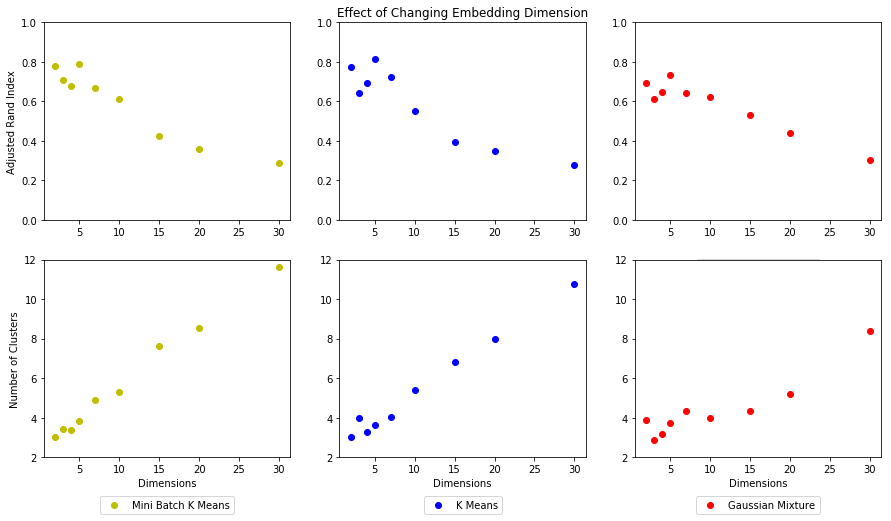

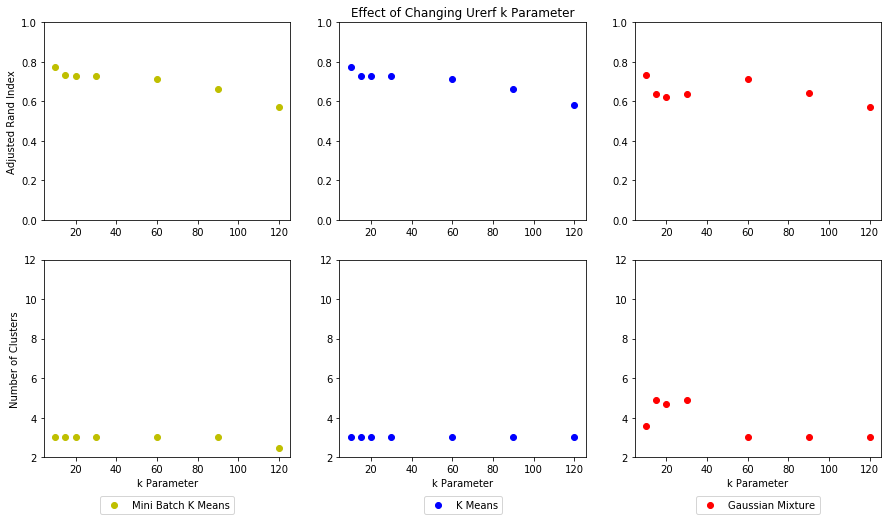

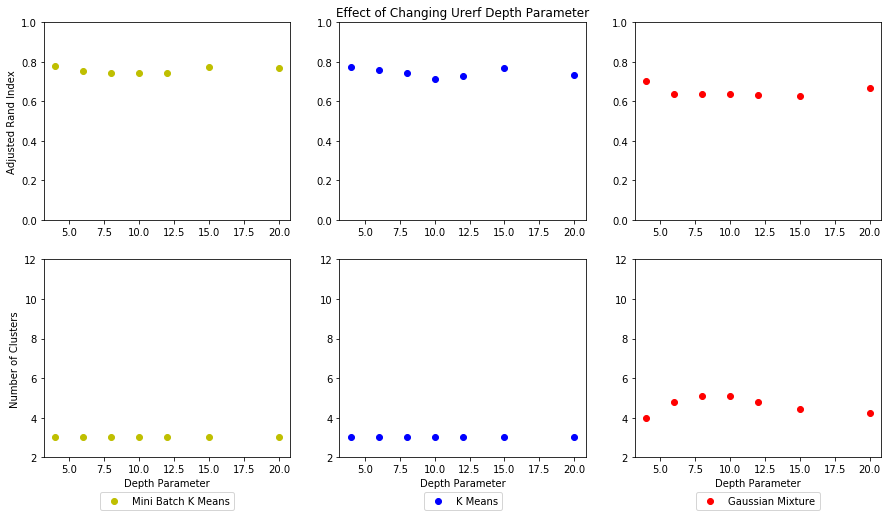

In [30]:
dataMini_depth = np.matrix(dataMini_depth)
dataKmeans_depth = np.matrix(dataKmeans_depth)
dataGMM_depth = np.matrix(dataGMM_depth)
dataMini_kvalue = np.matrix(dataMini_kvalue)
dataKmeans_kvalue = np.matrix(dataKmeans_kvalue)
dataGMM_kvalue = np.matrix(dataGMM_kvalue)
dataMini_dim = np.matrix(dataMini_dim)
dataKmeans_dim = np.matrix(dataKmeans_dim)
dataGMM_dim = np.matrix(dataGMM_dim)
print(dataMini_depth)
print(dataKmeans_depth)
print(dataGMM_depth)
print(dataMini_kvalue)
print(dataKmeans_kvalue)
print(dataGMM_kvalue)
print(dataMini_dim)
print(dataKmeans_dim)
print(dataGMM_dim)

plt.figure(figsize=(15, 8))
plt.subplot(2,3,1)
plt.scatter(dim, dataMini_dim[:,2].tolist(), c = 'y', label='Mini Batch K Means')
plt.ylabel('Adjusted Rand Index')
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.subplot(2,3,2)
plt.scatter(dim, dataKmeans_dim[:,2].tolist(), c = 'b', label='K Means')
plt.title("Effect of Changing Embedding Dimension")
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.subplot(2,3,3)
plt.scatter(dim, dataGMM_dim[:,2].tolist(), c = 'r', label='Gaussian Mixture')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.17))
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.subplot(2,3,4)
plt.scatter(dim, dataMini_dim[:,1].tolist(), c = 'y', label='Mini Batch K Means')
plt.xlabel('Dimensions')
plt.ylabel('Number of Clusters')
ax = plt.gca()
ax.set_ylim(2,12)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.17))
plt.subplot(2,3,5)
plt.scatter(dim, dataKmeans_dim[:,1].tolist(), c = 'b', label='K Means')
plt.xlabel('Dimensions')
ax = plt.gca()
ax.set_ylim(2,12)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.17))
plt.subplot(2,3,6)
plt.scatter(dim, dataGMM_dim[:,1].tolist(), c = 'r', label='Gaussian Mixture')
plt.xlabel('Dimensions')
ax = plt.gca()
ax.set_ylim(2,12)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.17))


plt.figure(figsize=(15, 8))
plt.subplot(2,3,1)
plt.scatter(k_varying, dataMini_kvalue[:,2].tolist(), c = 'y', label='Mini Batch K Means')
plt.ylabel('Adjusted Rand Index')
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.subplot(2,3,2)
plt.scatter(k_varying, dataKmeans_kvalue[:,2].tolist(), c = 'b', label='K Means')
plt.title("Effect of Changing Urerf k Parameter")
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.subplot(2,3,3)
plt.scatter(k_varying, dataGMM_kvalue[:,2].tolist(), c = 'r', label='Gaussian Mixture')
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.subplot(2,3,4)
plt.scatter(k_varying, dataMini_kvalue[:,1].tolist(), c = 'y', label='Mini Batch K Means')
plt.xlabel('k Parameter')
plt.ylabel('Number of Clusters')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.17))
ax = plt.gca()
ax.set_ylim(2,12)
plt.subplot(2,3,5)
plt.scatter(k_varying, dataKmeans_kvalue[:,1].tolist(), c = 'b', label='K Means')
plt.xlabel('k Parameter')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.17))
ax = plt.gca()
ax.set_ylim(2,12)
plt.subplot(2,3,6)
plt.scatter(k_varying, dataGMM_kvalue[:,1].tolist(), c = 'r', label='Gaussian Mixture')
plt.xlabel('k Parameter')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.17))
ax = plt.gca()
ax.set_ylim(2,12)

plt.figure(figsize=(15, 8))
plt.subplot(2,3,1)
plt.scatter(depth_varying, dataMini_depth[:,2].tolist(), c = 'y', label='Mini Batch K Means')
plt.ylabel('Adjusted Rand Index')
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.subplot(2,3,2)
plt.scatter(depth_varying, dataKmeans_depth[:,2].tolist(), c = 'b', label='K Means')
plt.title("Effect of Changing Urerf Depth Parameter")
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.subplot(2,3,3)
plt.scatter(depth_varying, dataGMM_depth[:,2].tolist(), c = 'r', label='Gaussian Mixture')
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.subplot(2,3,4)
plt.scatter(depth_varying, dataMini_depth[:,1].tolist(), c = 'y', label='Mini Batch K Means')
plt.xlabel('Depth Parameter')
plt.ylabel('Number of Clusters')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15))
ax = plt.gca()
ax.set_ylim(2,12)
plt.subplot(2,3,5)
plt.scatter(depth_varying, dataKmeans_depth[:,1].tolist(), c = 'b', label='K Means')
plt.xlabel('Depth Parameter')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15))
ax = plt.gca()
ax.set_ylim(2,12)
plt.subplot(2,3,6)
plt.scatter(depth_varying, dataGMM_depth[:,1].tolist(), c = 'r', label='Gaussian Mixture')
plt.xlabel('Depth Parameter')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15))
ax = plt.gca()
ax.set_ylim(2,12)


### Performance of Sklearn algorithms directly on features (including spectral embedding algorithm)


In [37]:
spectralC = []
miniB = []
kM = []
gaussianM = []
trial_num = 25
t = float(trial_num)

maxClusters = 0
maxSize = 0
maxAri = 0
print("SPECTRAL CLUSTERING")
for j in range(0, trial_num):
    x, z = SpectralClust(mat, 1, 1)
    maxClusters += x
    maxAri += z
spectralC.append([maxClusters/t,  maxAri/t])
maxClusters = 0
maxSize = 0
maxAri = 0
print("MINI BATCH K MEANS")
for j in range(0, trial_num):
    x, y, z = MiniBatchKMeansClustering(mat, 1, 1, 0, 50)
    maxClusters += x
    maxSize += y
    maxAri += z
miniB.append([maxClusters/t,  maxAri/t])
maxClusters = 0
maxAri = 0
print("K MEANS")
for j in range(0, trial_num):
    x, y = KMeansClustering(mat, 1, 1)
    maxClusters+= x
    maxAri += y 
kM.append([maxClusters/t,  maxAri/t])
maxClusters = 0
maxAri = 0
print("GMM")
for j in range(0, trial_num):
    x, y = GMMClustering(mat, 1, 1)
    maxClusters += x
    maxAri += y
gaussianM.append([maxClusters/t,  maxAri/t])

SPECTRAL CLUSTERING
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.744 |
| Clusters |  4.0 | ARI |  0.608 |
| Clusters |  5.0 | ARI |  0.606 |
| Clusters |  6.0 | ARI |  0.444 |
| Clusters |  7.0 | ARI |  0.426 |
| Clusters |  8.0 | ARI |  0.446 |
| Clusters |  9.0 | ARI |  0.445 |
| Clusters |  10.0 | ARI |  0.384 |
| Clusters |  11.0 | ARI |  0.348 |
| Clusters |  12.0 | ARI |  0.328 |
| Clusters |  13.0 | ARI |  0.305 |
| Clusters |  14.0 | ARI |  0.291 |
| Clusters |  15.0 | ARI |  0.239 |
| Clusters |  16.0 | ARI |  0.237 |
| Clusters |  17.0 | ARI |  0.201 |
| Clusters |  18.0 | ARI |  0.179 |
| Clusters |  19.0 | ARI |  0.172 |
| Clusters |  20.0 | ARI |  0.158 |
| Clusters |  21.0 | ARI |  0.159 |
| Clusters |  22.0 | ARI |  0.154 |
| Clusters |  23.0 | ARI |  0.157 |
| Clusters |  24.0 | ARI |  0.138 |
| Clusters |  25.0 | ARI |  0.139 |
| Clusters |  26.0 | ARI |  0.133 |
| Clusters |  27.0 | ARI |  0.124 |
| Clusters |  28.0 | ARI |  0.126 |
| Clusters |  29

| Clusters |  9.0 | ARI |  0.403 |
| Clusters |  10.0 | ARI |  0.390 |
| Clusters |  11.0 | ARI |  0.336 |
| Clusters |  12.0 | ARI |  0.337 |
| Clusters |  13.0 | ARI |  0.272 |
| Clusters |  14.0 | ARI |  0.280 |
| Clusters |  15.0 | ARI |  0.238 |
| Clusters |  16.0 | ARI |  0.210 |
| Clusters |  17.0 | ARI |  0.214 |
| Clusters |  18.0 | ARI |  0.189 |
| Clusters |  19.0 | ARI |  0.177 |
| Clusters |  20.0 | ARI |  0.157 |
| Clusters |  21.0 | ARI |  0.157 |
| Clusters |  22.0 | ARI |  0.150 |
| Clusters |  23.0 | ARI |  0.163 |
| Clusters |  24.0 | ARI |  0.136 |
| Clusters |  25.0 | ARI |  0.143 |
| Clusters |  26.0 | ARI |  0.124 |
| Clusters |  27.0 | ARI |  0.131 |
| Clusters |  28.0 | ARI |  0.123 |
| Clusters |  29.0 | ARI |  0.125 |
| Clusters |  30.0 | ARI |  0.108 |
| Clusters |  31.0 | ARI |  0.116 |
| Clusters |  32.0 | ARI |  0.144 |
| Clusters |  33.0 | ARI |  0.121 |
| Clusters |  34.0 | ARI |  0.132 |
| Clusters |  35.0 | ARI |  0.105 |
| Clusters |  36.0 | ARI |  0

| Clusters |  14.0 | ARI |  0.272 |
| Clusters |  15.0 | ARI |  0.237 |
| Clusters |  16.0 | ARI |  0.229 |
| Clusters |  17.0 | ARI |  0.206 |
| Clusters |  18.0 | ARI |  0.167 |
| Clusters |  19.0 | ARI |  0.180 |
| Clusters |  20.0 | ARI |  0.163 |
| Clusters |  21.0 | ARI |  0.147 |
| Clusters |  22.0 | ARI |  0.159 |
| Clusters |  23.0 | ARI |  0.138 |
| Clusters |  24.0 | ARI |  0.138 |
| Clusters |  25.0 | ARI |  0.155 |
| Clusters |  26.0 | ARI |  0.137 |
| Clusters |  27.0 | ARI |  0.132 |
| Clusters |  28.0 | ARI |  0.128 |
| Clusters |  29.0 | ARI |  0.130 |
| Clusters |  30.0 | ARI |  0.123 |
| Clusters |  31.0 | ARI |  0.116 |
| Clusters |  32.0 | ARI |  0.112 |
| Clusters |  33.0 | ARI |  0.126 |
| Clusters |  34.0 | ARI |  0.134 |
| Clusters |  35.0 | ARI |  0.125 |
| Clusters |  36.0 | ARI |  0.115 |
| Clusters |  37.0 | ARI |  0.120 |
| Clusters |  38.0 | ARI |  0.115 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.744 |
| Cluster

| Clusters |  18.0 | ARI |  0.176 |
| Clusters |  19.0 | ARI |  0.188 |
| Clusters |  20.0 | ARI |  0.178 |
| Clusters |  21.0 | ARI |  0.161 |
| Clusters |  22.0 | ARI |  0.148 |
| Clusters |  23.0 | ARI |  0.144 |
| Clusters |  24.0 | ARI |  0.141 |
| Clusters |  25.0 | ARI |  0.145 |
| Clusters |  26.0 | ARI |  0.136 |
| Clusters |  27.0 | ARI |  0.138 |
| Clusters |  28.0 | ARI |  0.140 |
| Clusters |  29.0 | ARI |  0.125 |
| Clusters |  30.0 | ARI |  0.120 |
| Clusters |  31.0 | ARI |  0.138 |
| Clusters |  32.0 | ARI |  0.120 |
| Clusters |  33.0 | ARI |  0.141 |
| Clusters |  34.0 | ARI |  0.147 |
| Clusters |  35.0 | ARI |  0.130 |
| Clusters |  36.0 | ARI |  0.119 |
| Clusters |  37.0 | ARI |  0.122 |
| Clusters |  38.0 | ARI |  0.108 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.744 |
| Clusters |  4.0 | ARI |  0.608 |
| Clusters |  5.0 | ARI |  0.606 |
| Clusters |  6.0 | ARI |  0.444 |
| Clusters |  7.0 | ARI |  0.420 |
| Clusters | 

| Clusters |  24.0 | ARI |  0.132 |
| Clusters |  25.0 | ARI |  0.146 |
| Clusters |  26.0 | ARI |  0.134 |
| Clusters |  27.0 | ARI |  0.134 |
| Clusters |  28.0 | ARI |  0.133 |
| Clusters |  29.0 | ARI |  0.127 |
| Clusters |  30.0 | ARI |  0.124 |
| Clusters |  31.0 | ARI |  0.117 |
| Clusters |  32.0 | ARI |  0.119 |
| Clusters |  33.0 | ARI |  0.115 |
| Clusters |  34.0 | ARI |  0.119 |
| Clusters |  35.0 | ARI |  0.146 |
| Clusters |  36.0 | ARI |  0.123 |
| Clusters |  37.0 | ARI |  0.104 |
| Clusters |  38.0 | ARI |  0.108 |
Best Num Clusters: 3
MINI BATCH K MEANS
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.745 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.744 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.650 |
|BatchSize | 100.00 | Clusters |  4.0 

|BatchSize | 50.00 | Clusters |  11.0 | ARI |  0.355 |
|BatchSize | 100.00 | Clusters |  11.0 | ARI |  0.368 |
|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.371 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.314 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.351 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.338 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.264 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.306 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.308 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.290 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.348 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.290 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.284 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.279 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.272 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.275 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.271 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.298 

|BatchSize | 150.00 | Clusters |  23.0 | ARI |  0.188 |
|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.169 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.179 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.182 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.186 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.194 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.172 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.189 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.163 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.179 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.152 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.156 

|BatchSize | 150.00 | Clusters |  35.0 | ARI |  0.138 |
|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.121 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.109 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.131 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.136 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.133 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.117 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.126 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.110 |
Best Batch Size: 100 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.716 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.650 |
|BatchSize | 100.00

|BatchSize | 150.00 | Clusters |  11.0 | ARI |  0.427 |
|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.291 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.268 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.361 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.351 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.289 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.326 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.310 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.321 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.274 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.276 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.276 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.272 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.268 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.273 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.263 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.245 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.260 

|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.177 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.197 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.199 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.154 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.178 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.158 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.167 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.153 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.168 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.157 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.173 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.152 

|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.113 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.117 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.115 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.125 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.107 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.716 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.638 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.635 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.656 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.615 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.608 |
|BatchSize | 150.00 | Cl

|BatchSize | 50.00 | Clusters |  12.0 | ARI |  0.310 |
|BatchSize | 100.00 | Clusters |  12.0 | ARI |  0.334 |
|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.289 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.288 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.320 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.325 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.285 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.288 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.291 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.292 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.278 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.297 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.277 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.257 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.272 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.285 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.283 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.238 

|BatchSize | 50.00 | Clusters |  24.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  24.0 | ARI |  0.190 |
|BatchSize | 150.00 | Clusters |  24.0 | ARI |  0.187 |
|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.204 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.173 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.158 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.161 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.169 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.159 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.168 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.143 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.164 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.187 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.144 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.158 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.152 

|BatchSize | 50.00 | Clusters |  36.0 | ARI |  0.122 |
|BatchSize | 100.00 | Clusters |  36.0 | ARI |  0.110 |
|BatchSize | 150.00 | Clusters |  36.0 | ARI |  0.127 |
|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.113 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.125 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.131 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.117 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.756 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.646 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.650 |
|BatchSize | 150.00 |

|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.315 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.348 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.291 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.283 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.293 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.313 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.261 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.273 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.236 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.320 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.286 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.268 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.279 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.245 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.240 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.245 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.268 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.237 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.167 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.168 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.170 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.140 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.188 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.160 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.167 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.164 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.170 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.155 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.159 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.156 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.137 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.140 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.159 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.140 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.145 

|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.110 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.129 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.121 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.113 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.716 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.611 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.640 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.617 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.652 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.616 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.606 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.570 |
|BatchSize | 100.00 | Clus

|BatchSize | 150.00 | Clusters |  12.0 | ARI |  0.341 |
|BatchSize | 50.00 | Clusters |  13.0 | ARI |  0.314 |
|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.325 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.273 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.273 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.279 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.298 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.283 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.236 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.278 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.239 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.249 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.283 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.243 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.216 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.237 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.235 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.256 

|BatchSize | 50.00 | Clusters |  25.0 | ARI |  0.178 |
|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.165 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.205 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.167 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.184 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.190 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.160 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.162 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.165 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.159 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.174 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.159 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.157 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.135 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.138 

|BatchSize | 50.00 | Clusters |  37.0 | ARI |  0.120 |
|BatchSize | 100.00 | Clusters |  37.0 | ARI |  0.108 |
|BatchSize | 150.00 | Clusters |  37.0 | ARI |  0.105 |
|BatchSize | 50.00 | Clusters |  38.0 | ARI |  0.118 |
|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.116 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.130 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.716 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.786 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.716 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.598 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.727 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.650 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.612 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.613 |
|BatchSize | 150.00 | Cl

|BatchSize | 100.00 | Clusters |  13.0 | ARI |  0.310 |
|BatchSize | 150.00 | Clusters |  13.0 | ARI |  0.329 |
|BatchSize | 50.00 | Clusters |  14.0 | ARI |  0.260 |
|BatchSize | 100.00 | Clusters |  14.0 | ARI |  0.293 |
|BatchSize | 150.00 | Clusters |  14.0 | ARI |  0.288 |
|BatchSize | 50.00 | Clusters |  15.0 | ARI |  0.272 |
|BatchSize | 100.00 | Clusters |  15.0 | ARI |  0.276 |
|BatchSize | 150.00 | Clusters |  15.0 | ARI |  0.268 |
|BatchSize | 50.00 | Clusters |  16.0 | ARI |  0.259 |
|BatchSize | 100.00 | Clusters |  16.0 | ARI |  0.266 |
|BatchSize | 150.00 | Clusters |  16.0 | ARI |  0.261 |
|BatchSize | 50.00 | Clusters |  17.0 | ARI |  0.257 |
|BatchSize | 100.00 | Clusters |  17.0 | ARI |  0.241 |
|BatchSize | 150.00 | Clusters |  17.0 | ARI |  0.246 |
|BatchSize | 50.00 | Clusters |  18.0 | ARI |  0.249 |
|BatchSize | 100.00 | Clusters |  18.0 | ARI |  0.233 |
|BatchSize | 150.00 | Clusters |  18.0 | ARI |  0.238 |
|BatchSize | 50.00 | Clusters |  19.0 | ARI |  0.214 

|BatchSize | 100.00 | Clusters |  25.0 | ARI |  0.170 |
|BatchSize | 150.00 | Clusters |  25.0 | ARI |  0.193 |
|BatchSize | 50.00 | Clusters |  26.0 | ARI |  0.188 |
|BatchSize | 100.00 | Clusters |  26.0 | ARI |  0.195 |
|BatchSize | 150.00 | Clusters |  26.0 | ARI |  0.158 |
|BatchSize | 50.00 | Clusters |  27.0 | ARI |  0.196 |
|BatchSize | 100.00 | Clusters |  27.0 | ARI |  0.157 |
|BatchSize | 150.00 | Clusters |  27.0 | ARI |  0.205 |
|BatchSize | 50.00 | Clusters |  28.0 | ARI |  0.185 |
|BatchSize | 100.00 | Clusters |  28.0 | ARI |  0.175 |
|BatchSize | 150.00 | Clusters |  28.0 | ARI |  0.156 |
|BatchSize | 50.00 | Clusters |  29.0 | ARI |  0.155 |
|BatchSize | 100.00 | Clusters |  29.0 | ARI |  0.166 |
|BatchSize | 150.00 | Clusters |  29.0 | ARI |  0.147 |
|BatchSize | 50.00 | Clusters |  30.0 | ARI |  0.177 |
|BatchSize | 100.00 | Clusters |  30.0 | ARI |  0.156 |
|BatchSize | 150.00 | Clusters |  30.0 | ARI |  0.153 |
|BatchSize | 50.00 | Clusters |  31.0 | ARI |  0.160 

|BatchSize | 100.00 | Clusters |  38.0 | ARI |  0.120 |
|BatchSize | 150.00 | Clusters |  38.0 | ARI |  0.125 |
Best Batch Size: 50 Best Num Clusters: 3
|BatchSize | 50.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 100.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 150.00 | Clusters |  2.0 | ARI |  0.540 |
|BatchSize | 50.00 | Clusters |  3.0 | ARI |  0.802 |
|BatchSize | 100.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 150.00 | Clusters |  3.0 | ARI |  0.730 |
|BatchSize | 50.00 | Clusters |  4.0 | ARI |  0.646 |
|BatchSize | 100.00 | Clusters |  4.0 | ARI |  0.624 |
|BatchSize | 150.00 | Clusters |  4.0 | ARI |  0.650 |
|BatchSize | 50.00 | Clusters |  5.0 | ARI |  0.612 |
|BatchSize | 100.00 | Clusters |  5.0 | ARI |  0.607 |
|BatchSize | 150.00 | Clusters |  5.0 | ARI |  0.675 |
|BatchSize | 50.00 | Clusters |  6.0 | ARI |  0.643 |
|BatchSize | 100.00 | Clusters |  6.0 | ARI |  0.577 |
|BatchSize | 150.00 | Clusters |  6.0 | ARI |  0.467 |
|BatchSize | 50.00 | Cluste

| Clusters |  19.0 | ARI |  0.226 |
| Clusters |  20.0 | ARI |  0.194 |
| Clusters |  21.0 | ARI |  0.215 |
| Clusters |  22.0 | ARI |  0.228 |
| Clusters |  23.0 | ARI |  0.216 |
| Clusters |  24.0 | ARI |  0.166 |
| Clusters |  25.0 | ARI |  0.172 |
| Clusters |  26.0 | ARI |  0.165 |
| Clusters |  27.0 | ARI |  0.173 |
| Clusters |  28.0 | ARI |  0.157 |
| Clusters |  29.0 | ARI |  0.172 |
| Clusters |  30.0 | ARI |  0.143 |
| Clusters |  31.0 | ARI |  0.139 |
| Clusters |  32.0 | ARI |  0.121 |
| Clusters |  33.0 | ARI |  0.128 |
| Clusters |  34.0 | ARI |  0.146 |
| Clusters |  35.0 | ARI |  0.130 |
| Clusters |  36.0 | ARI |  0.105 |
| Clusters |  37.0 | ARI |  0.127 |
| Clusters |  38.0 | ARI |  0.105 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.540 |
| Clusters |  3.0 | ARI |  0.730 |
| Clusters |  4.0 | ARI |  0.635 |
| Clusters |  5.0 | ARI |  0.608 |
| Clusters |  6.0 | ARI |  0.448 |
| Clusters |  7.0 | ARI |  0.486 |
| Clusters |  8.0 | ARI |  0.438 |
| Clusters |  

| Clusters |  23.0 | ARI |  0.194 |
| Clusters |  24.0 | ARI |  0.176 |
| Clusters |  25.0 | ARI |  0.223 |
| Clusters |  26.0 | ARI |  0.157 |
| Clusters |  27.0 | ARI |  0.170 |
| Clusters |  28.0 | ARI |  0.152 |
| Clusters |  29.0 | ARI |  0.154 |
| Clusters |  30.0 | ARI |  0.147 |
| Clusters |  31.0 | ARI |  0.120 |
| Clusters |  32.0 | ARI |  0.153 |
| Clusters |  33.0 | ARI |  0.128 |
| Clusters |  34.0 | ARI |  0.139 |
| Clusters |  35.0 | ARI |  0.120 |
| Clusters |  36.0 | ARI |  0.120 |
| Clusters |  37.0 | ARI |  0.118 |
| Clusters |  38.0 | ARI |  0.114 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.540 |
| Clusters |  3.0 | ARI |  0.730 |
| Clusters |  4.0 | ARI |  0.650 |
| Clusters |  5.0 | ARI |  0.608 |
| Clusters |  6.0 | ARI |  0.446 |
| Clusters |  7.0 | ARI |  0.478 |
| Clusters |  8.0 | ARI |  0.442 |
| Clusters |  9.0 | ARI |  0.439 |
| Clusters |  10.0 | ARI |  0.380 |
| Clusters |  11.0 | ARI |  0.356 |
| Clusters |  12.0 | ARI |  0.354 |
| Clusters |  1

| Clusters |  27.0 | ARI |  0.166 |
| Clusters |  28.0 | ARI |  0.147 |
| Clusters |  29.0 | ARI |  0.152 |
| Clusters |  30.0 | ARI |  0.135 |
| Clusters |  31.0 | ARI |  0.168 |
| Clusters |  32.0 | ARI |  0.139 |
| Clusters |  33.0 | ARI |  0.143 |
| Clusters |  34.0 | ARI |  0.135 |
| Clusters |  35.0 | ARI |  0.119 |
| Clusters |  36.0 | ARI |  0.115 |
| Clusters |  37.0 | ARI |  0.118 |
| Clusters |  38.0 | ARI |  0.115 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.540 |
| Clusters |  3.0 | ARI |  0.730 |
| Clusters |  4.0 | ARI |  0.650 |
| Clusters |  5.0 | ARI |  0.608 |
| Clusters |  6.0 | ARI |  0.454 |
| Clusters |  7.0 | ARI |  0.479 |
| Clusters |  8.0 | ARI |  0.442 |
| Clusters |  9.0 | ARI |  0.402 |
| Clusters |  10.0 | ARI |  0.362 |
| Clusters |  11.0 | ARI |  0.374 |
| Clusters |  12.0 | ARI |  0.331 |
| Clusters |  13.0 | ARI |  0.311 |
| Clusters |  14.0 | ARI |  0.276 |
| Clusters |  15.0 | ARI |  0.280 |
| Clusters |  16.0 | ARI |  0.252 |
| Clusters |  1

| Clusters |  31.0 | ARI |  0.138 |
| Clusters |  32.0 | ARI |  0.139 |
| Clusters |  33.0 | ARI |  0.140 |
| Clusters |  34.0 | ARI |  0.131 |
| Clusters |  35.0 | ARI |  0.111 |
| Clusters |  36.0 | ARI |  0.117 |
| Clusters |  37.0 | ARI |  0.118 |
| Clusters |  38.0 | ARI |  0.121 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.540 |
| Clusters |  3.0 | ARI |  0.730 |
| Clusters |  4.0 | ARI |  0.650 |
| Clusters |  5.0 | ARI |  0.608 |
| Clusters |  6.0 | ARI |  0.446 |
| Clusters |  7.0 | ARI |  0.486 |
| Clusters |  8.0 | ARI |  0.438 |
| Clusters |  9.0 | ARI |  0.405 |
| Clusters |  10.0 | ARI |  0.364 |
| Clusters |  11.0 | ARI |  0.319 |
| Clusters |  12.0 | ARI |  0.329 |
| Clusters |  13.0 | ARI |  0.307 |
| Clusters |  14.0 | ARI |  0.311 |
| Clusters |  15.0 | ARI |  0.282 |
| Clusters |  16.0 | ARI |  0.277 |
| Clusters |  17.0 | ARI |  0.251 |
| Clusters |  18.0 | ARI |  0.254 |
| Clusters |  19.0 | ARI |  0.224 |
| Clusters |  20.0 | ARI |  0.230 |
| Clusters |  2

| Clusters |  38.0 | ARI |  0.113 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.904 |
| Clusters |  4.0 | ARI |  0.764 |
| Clusters |  5.0 | ARI |  0.685 |
| Clusters |  6.0 | ARI |  0.643 |
| Clusters |  7.0 | ARI |  0.445 |
| Clusters |  8.0 | ARI |  0.457 |
| Clusters |  9.0 | ARI |  0.442 |
| Clusters |  10.0 | ARI |  0.447 |
| Clusters |  11.0 | ARI |  0.411 |
| Clusters |  12.0 | ARI |  0.382 |
| Clusters |  13.0 | ARI |  0.323 |
| Clusters |  14.0 | ARI |  0.309 |
| Clusters |  15.0 | ARI |  0.312 |
| Clusters |  16.0 | ARI |  0.250 |
| Clusters |  17.0 | ARI |  0.204 |
| Clusters |  18.0 | ARI |  0.223 |
| Clusters |  19.0 | ARI |  0.199 |
| Clusters |  20.0 | ARI |  0.211 |
| Clusters |  21.0 | ARI |  0.302 |
| Clusters |  22.0 | ARI |  0.207 |
| Clusters |  23.0 | ARI |  0.201 |
| Clusters |  24.0 | ARI |  0.181 |
| Clusters |  25.0 | ARI |  0.160 |
| Clusters |  26.0 | ARI |  0.161 |
| Clusters |  27.0 | ARI |  0.183 |
| Clusters |  2

| Clusters |  11.0 | ARI |  0.380 |
| Clusters |  12.0 | ARI |  0.414 |
| Clusters |  13.0 | ARI |  0.369 |
| Clusters |  14.0 | ARI |  0.376 |
| Clusters |  15.0 | ARI |  0.264 |
| Clusters |  16.0 | ARI |  0.262 |
| Clusters |  17.0 | ARI |  0.234 |
| Clusters |  18.0 | ARI |  0.243 |
| Clusters |  19.0 | ARI |  0.226 |
| Clusters |  20.0 | ARI |  0.220 |
| Clusters |  21.0 | ARI |  0.257 |
| Clusters |  22.0 | ARI |  0.198 |
| Clusters |  23.0 | ARI |  0.173 |
| Clusters |  24.0 | ARI |  0.187 |
| Clusters |  25.0 | ARI |  0.171 |
| Clusters |  26.0 | ARI |  0.166 |
| Clusters |  27.0 | ARI |  0.165 |
| Clusters |  28.0 | ARI |  0.169 |
| Clusters |  29.0 | ARI |  0.158 |
| Clusters |  30.0 | ARI |  0.144 |
| Clusters |  31.0 | ARI |  0.158 |
| Clusters |  32.0 | ARI |  0.121 |
| Clusters |  33.0 | ARI |  0.159 |
| Clusters |  34.0 | ARI |  0.120 |
| Clusters |  35.0 | ARI |  0.127 |
| Clusters |  36.0 | ARI |  0.144 |
| Clusters |  37.0 | ARI |  0.138 |
| Clusters |  38.0 | ARI |  

| Clusters |  16.0 | ARI |  0.348 |
| Clusters |  17.0 | ARI |  0.332 |
| Clusters |  18.0 | ARI |  0.233 |
| Clusters |  19.0 | ARI |  0.203 |
| Clusters |  20.0 | ARI |  0.259 |
| Clusters |  21.0 | ARI |  0.183 |
| Clusters |  22.0 | ARI |  0.198 |
| Clusters |  23.0 | ARI |  0.178 |
| Clusters |  24.0 | ARI |  0.212 |
| Clusters |  25.0 | ARI |  0.183 |
| Clusters |  26.0 | ARI |  0.165 |
| Clusters |  27.0 | ARI |  0.167 |
| Clusters |  28.0 | ARI |  0.182 |
| Clusters |  29.0 | ARI |  0.155 |
| Clusters |  30.0 | ARI |  0.134 |
| Clusters |  31.0 | ARI |  0.152 |
| Clusters |  32.0 | ARI |  0.132 |
| Clusters |  33.0 | ARI |  0.117 |
| Clusters |  34.0 | ARI |  0.136 |
| Clusters |  35.0 | ARI |  0.126 |
| Clusters |  36.0 | ARI |  0.130 |
| Clusters |  37.0 | ARI |  0.114 |
| Clusters |  38.0 | ARI |  0.164 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.904 |
| Clusters |  4.0 | ARI |  0.764 |
| Clusters |  5.0 | ARI |  0.685 |
| Clusters 

| Clusters |  21.0 | ARI |  0.192 |
| Clusters |  22.0 | ARI |  0.205 |
| Clusters |  23.0 | ARI |  0.214 |
| Clusters |  24.0 | ARI |  0.168 |
| Clusters |  25.0 | ARI |  0.178 |
| Clusters |  26.0 | ARI |  0.192 |
| Clusters |  27.0 | ARI |  0.165 |
| Clusters |  28.0 | ARI |  0.184 |
| Clusters |  29.0 | ARI |  0.149 |
| Clusters |  30.0 | ARI |  0.145 |
| Clusters |  31.0 | ARI |  0.132 |
| Clusters |  32.0 | ARI |  0.147 |
| Clusters |  33.0 | ARI |  0.143 |
| Clusters |  34.0 | ARI |  0.139 |
| Clusters |  35.0 | ARI |  0.128 |
| Clusters |  36.0 | ARI |  0.125 |
| Clusters |  37.0 | ARI |  0.121 |
| Clusters |  38.0 | ARI |  0.107 |
Best Num Clusters: 3
| Clusters |  2.0 | ARI |  0.568 |
| Clusters |  3.0 | ARI |  0.904 |
| Clusters |  4.0 | ARI |  0.764 |
| Clusters |  5.0 | ARI |  0.700 |
| Clusters |  6.0 | ARI |  0.524 |
| Clusters |  7.0 | ARI |  0.544 |
| Clusters |  8.0 | ARI |  0.431 |
| Clusters |  9.0 | ARI |  0.432 |
| Clusters |  10.0 | ARI |  0.451 |
| Clusters |  1

In [36]:
### The number of clusters and ARI for each of the other algorithms ###
print(spectralC, miniB, kM, gaussianM)

[[3.0, 0.74368263194323558]] [[3.0, 0.75170651922750764]] [[3.0, 0.73023827228346971]] [[3.0, 0.90387423177481208]]
